# Introduction

## Table of Contents:
* [1. Installing Packages](#first-bullet)
* [2. Importing Packages](#second-bullet)
* [3. Exploratory Data Analysis](#third-bullet)
    * [3.1 Web Scraping](#fourth-bullet)
    * [3.2 Data Preparation of Scraped Images](#fifth-bullet)
        * [3.2.1 Filtering out Large Images](#sixth-bullet)
        * [3.2.2 Removing Duplicate Images](#seventh-bullet)
        * [3.2.3 Extracting Text from memes using OCR methods](#eighth-bullet)
        * [3.2.4 ](#ninth-bullet)
* [Exploratory Data Analysis](#tenth-bullet)

## 1. Installing Packages <a class="anchor" id="first-bullet"></a>

In [43]:
# %pip install git+https://github.com/JaidedAI/EasyOCR.git
# %pip install -U git+https://github.com/madmaze/pytesseract.git
# %pip install language-tool-python
# %pip install mlx-lm
# %pip install transformers
# !pip install git+https://github.com/casics/nostril.git
# !pip install wordsegment
# !pip install wordninja
# ! pip install python-doctr
# ! pip install "python-doctr[tf]"
# %pip install -U symspellpy
# %pip install fast-langdetect
# %pip install lingua-language-detector
# %conda install -c conda-forge spacy
# !python -m spacy download en_core_web_sm
# !pip install nltk
# !pip install wordcloud

## 2. Importing Packages <a class="anchor" id="second-bullet"></a>

In [77]:
import pandas as pd
from datasets import load_dataset, get_dataset_split_names
import polars as pl
from sklearn.cluster import KMeans
import easyocr
import hashlib
import string
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud
import spacy
import warnings
from bing_image_downloader import downloader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pytesseract
from matplotlib.cm import viridis
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer
import re
from language_tool_python import LanguageTool
from mlx_lm import load, generate
import language_tool_python  # For grammar correction
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.image as mpimg
from tqdm import tqdm
from doctr.io import DocumentFile
from fast_langdetect import detect_language
from doctr.models import ocr_predictor
from lingua import LanguageDetectorBuilder, Language, IsoCode639_1, IsoCode639_3
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string


nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Step 1: Preprocess the meme text
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

nlp = spacy.load('en_core_web_sm')
detector = LanguageDetectorBuilder.from_all_languages().build()


model = ocr_predictor(det_arch = 'db_resnet50',
                      reco_arch = 'crnn_vgg16_bn',
                      pretrained = True
                     )

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
    
reader = easyocr.Reader(['en'], gpu=False)
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'

[nltk_data] Downloading package stopwords to /Users/daaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/daaa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
Us

## 3. Web Scraping <a class="anchor" id="third-bullet"></a>

I have visually shown the need for web scraping due to the data imbalance

In [825]:
!git clone https://huggingface.co/datasets/neuralcatcher/hateful_memes
# downloading the dataset locally as well

Cloning into 'hateful_memes'...
remote: Enumerating objects: 9700, done.
remote: Total 9700 (delta 0), reused 0 (delta 0), pack-reused 9700 (from 1)
Receiving objects: 100% (9700/9700), 1.83 MiB | 2.88 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Updating files: 100% (9672/9672), done.
Filtering content: 100% (9664/9664), 3.13 GiB | 5.79 MiB/s, done.


In [896]:
train_df = pd.read_json('./hateful_memes/train.jsonl', lines=True)
train_df.head()

id            img  label  \
0  42953  img/42953.png      0   
1  23058  img/23058.png      0   
2  13894  img/13894.png      0   
3  37408  img/37408.png      0   
4  82403  img/82403.png      0   

                                                text  
0   its their character not their color that matters  
1  don't be afraid to love again everyone is not ...  
2                           putting bows on your pet  
3  i love everything and everybody! except for sq...  
4  everybody loves chocolate chip cookies, even h...

In [894]:
label_counts = train_df['label'].value_counts()
label_counts.index = label_counts.index.map({0: 'Not Hate', 1: 'Hate'})
label_counts

label
Not Hate    5481
Hate        3019
Name: count, dtype: int64

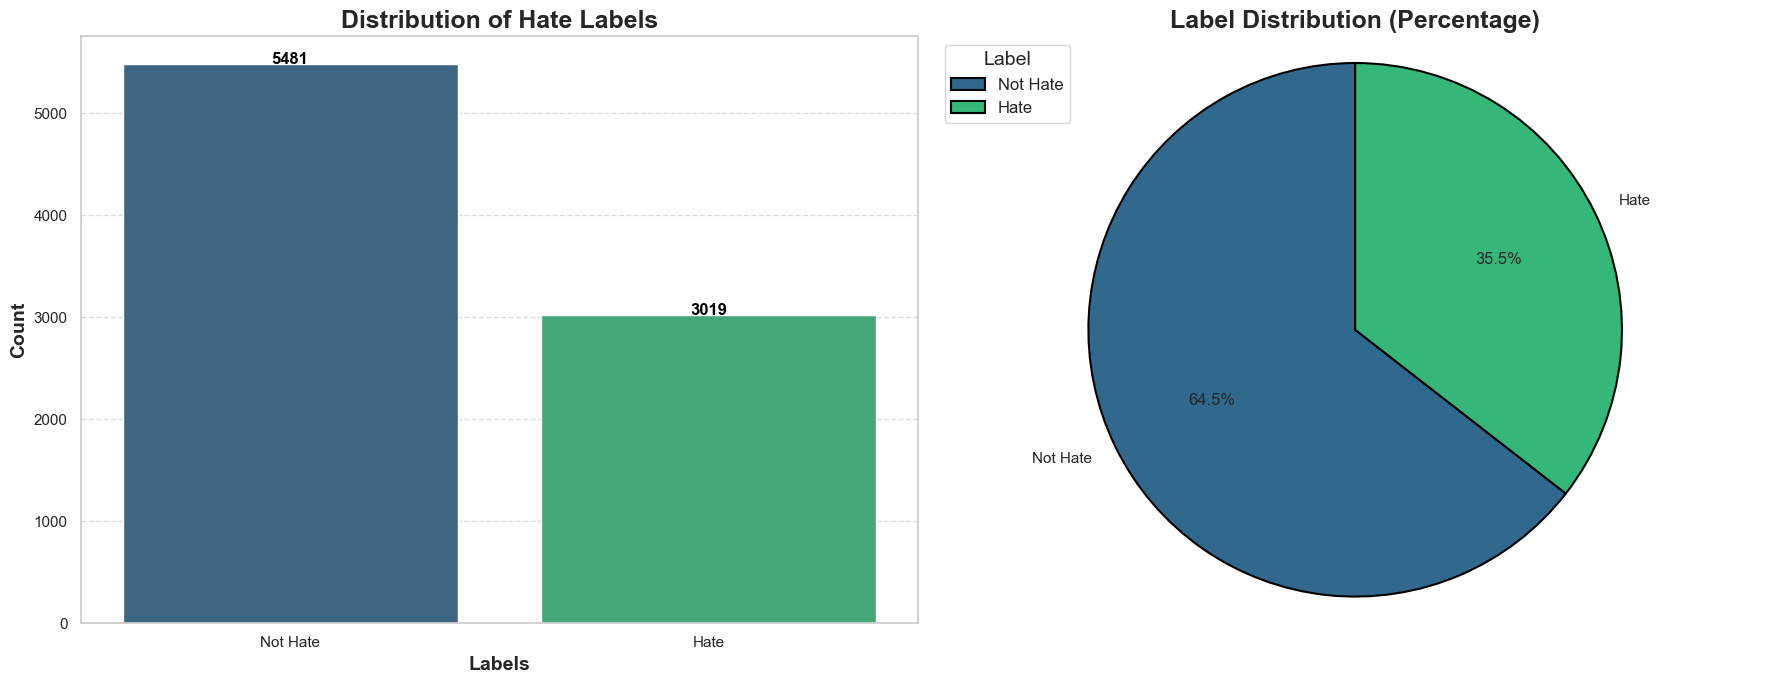

In [895]:
label_counts = label_counts.reset_index()
label_counts.columns = ['label', 'count']

viridis_palette = sns.color_palette("viridis", len(label_counts))
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# the bar chart
sns.barplot(
    x='label', 
    y='count', 
    data=label_counts, 
    ax=axes[0], 
    palette=viridis_palette
)

for i, row in label_counts.iterrows():
    axes[0].text(
        i, 
        row['count'] + 0.2, 
        str(row['count']), 
        ha='center', 
        fontsize=12, 
        color='black', 
        fontweight='bold'
    )

axes[0].set_title("Distribution of Hate Labels", fontsize=18, fontweight='bold')
axes[0].set_xlabel("Labels", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Count", fontsize=14, fontweight='bold')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)

# the pie chart
axes[1].pie(
    label_counts['count'], 
    labels=label_counts['label'], 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=viridis_palette, 
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)
axes[1].axis('equal')
axes[1].set_title("Label Distribution (Percentage)", fontsize=18, fontweight='bold')

axes[1].legend(
    labels=label_counts['label'], 
    loc="upper left", 
    title="Label", 
    fontsize=12, 
    title_fontsize=14
)

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
The data is significantly imbalanced as seen in the above image. To resolve this, instead of undersampling and losing data as well as using ineffective oversampling techniques such as smote or random oversampling, let's utilize web scraping to scrape around ~2000 harmful meme images from the internet to augment and balance the dataset. 
</div>

### 3.1 Web Scraping <a class="anchor" id="fourth-bullet"></a>

In [156]:
queries = [
    "racism", "sexism", "homophobia", "transphobia", "hate speech", "violence", 
    "bullying", "body shaming", "mental illness stigma", "discrimination", 
    "hate crime", "toxic masculinity", "misogyny", "misandry", "anti-Semitism", "xenophobia", "ageism", "ableism", "fatphobia", 
    "nazi", "white supremacy", "KKK", "neo-nazi", "terrorism", 
    "gun violence", "school shootings", "abortion debate", "anti-vaccine", "conspiracy theories", 
    "covid misinformation", "climate change denial", "fake news", "radicalization", "ISIS", 
    "extremism", "terrorist attacks", "hate speech speech", "slut-shaming",
     "domestic violence", "racist humor", "sexist jokes", 
    "anti-LGBTQ", "transgender jokes", "homophobic jokes", "feminist hate", 
    "bullying memes", "stereotypes", "meme harassment", "dark humor", "graphic violence", 
    "gore", "death threats", "self-harm", "drug abuse", 
    "alcoholism", "profanity", "racist memes", "antisocial behavior", "trolling", 
    "catfishing", "scams", "hoaxes", "online abuse", "cults", "hate groups", 
    "gang violence", "organized crime", "gangster memes", "drug memes", "brutality", 
    "war crimes", "warfare memes", "militant memes", "extreme political views", "dictatorships", 
    "communism", "authoritarianism", "conspiracy theories memes", "unethical practices", 
    "greed", "wealth inequality", "anti-government", "radical political movements", 
    "controversial figures", "corruption", "violence against women",
    "illegal activities", "terrorist organizations", "online radicalization", 
    "extreme nationalism", "fake conspiracy theories", "death cults", "survivalism", "racist caricatures", 
    "cultural appropriation", "toxic fandoms", "misogynistic memes", "victim blaming", "hate symbols", 
    "swastika memes", "confederate flag memes", "bullying at school", "online hate speech", "terrorist memes", 
    "hate groups propaganda", "violent video games", "social media addiction", "toxic online communities", 
    "misinformation", "disinformation", "polarization", "online harassment", "cancel culture", 
    "outrage culture", "online shaming", "meme trolling", "internet mobs", "internet censorship", 
    "memes on controversial issues", "memes about mental health", 
    "memes mocking minorities", "celebrity abuse scandals", "gossip memes", "cultural criticism memes", 
    "historical revisionism", "disrespect towards the elderly", "harassment of public figures", 
    "toxic influencer culture", "fake beauty standards", "self-hate", "biphobia", "misogynoir"
]

<div class="alert alert-info" role="alert">
Above is a list of around 100+ harmful/toxic topics that was generated using chatgpt. The goal is to gather around 20 meme images from these topics which will come to around 2000 images, just enough to balance the dataset.
</div>

In [157]:
for query in tqdm(queries, desc="downloading memes from query", unit="query"):
    if "meme" not in query:
        query += " meme offensive"
    
    downloader.download(query, limit=20,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

downloading memes from query:   0%|                                                                | 0/132 [00:00<?, ?query/s]

[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/racism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-807f-7f4d5eb3b431-Minnesota_Ave_Protest_009.JPG?crop=5519,3105,x0,y280&amp;width=3200&amp;height=1801&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-807f-7f4d5eb3b431-Minnesota_Ave_Protest_009.JPG?crop=5519,3105,x0,y280&amp;width=3200&amp;height=1801&amp;format=pjpg&amp;auto=webp
[!] Error:: HTTP Error 406: Not Acceptable
[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/1024/branded_news/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/976/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://ichef

downloading memes from query:   1%|▍                                                       | 1/132 [00:26<56:51, 26.04s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/sexism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.gannett-cdn.com/presto/2018/08/19/USAT/09e5037b-6ca2-4022-8495-e12374490284-VPC_SEXIST_SCHOOL_DESK_THUMB.png?width=3200&amp;height=1800&amp;fit=crop
[!] Issue getting: https://www.gannett-cdn.com/presto/2018/08/19/USAT/09e5037b-6ca2-4022-8495-e12374490284-VPC_SEXIST_SCHOOL_DESK_THUMB.png?width=3200&amp;height=1800&amp;fit=crop
[!] Error:: HTTP Error 406: Not Acceptable
[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-co

downloading memes from query:   2%|▊                                                       | 2/132 [00:47<50:34, 23.34s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/homophobia meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #2 from http://images7.memedroid.com/images/UPLOADED95/53b37388ca6c3.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.redd.it/3yi1dzoeofj51.jpg
[Error]Invalid image, not saving https://i.redd.it/3yi1dzoeofj51.jpg

[!] Issue getting: https://i.redd.it/3yi1dzoeofj51.jpg
[!] Error:: Invalid image, not saving https://i.redd.it/3yi1dzoeofj51.jpg

[%] Downloading Image #3 from https://cdn.vox-cdn.com/thumbor/8gzt6uLQIjordJb7UdByOjvsb9E=/0x0:3716x2500/920x0/filters:focal(0x0:3716x2500):no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/11538307/mbb_co

downloading memes from query:   2%|█▎                                                      | 3/132 [01:05<45:25, 21.13s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/transphobia meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/976/cpsprodpb/AE8D/production/_103458644_3aed7c2f-8c04-446d-85a2-cb91c4c83c9f.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #3 from https://static01.nyt.com/images/2018/10/22/us/23xp-trans3/23xp-trans3-videoSixteenByNine3000.jpg?year=2018&amp;h=1686&amp;w=3000&amp;sig=0x7243ca8bfe58af443aeeab4f34a96cc0&amp;tw=1
[%] File Downloaded !

[%] Downloading Image #4 from http://images7.memedroid.com/images/UPLOADED95/53b37388ca6c3.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://thepinknews.com/wp-content/uploads/ima

downloading memes from query:   3%|█▋                                                      | 4/132 [01:39<55:10, 25.87s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate speech meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://uberhumor.com/wp-content/uploads/2019/05/zKzhMBF.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://venturebeat.com/wp-content/uploads/2020/05/hateful-memes-challlenge.png?w=1200&amp;strip=all
[%] File Downloaded !

[%] Downloading Image #4 from https://images.theconversation.com/files/243088/original/file-20181030-76416-1vp01ih.jpg?ixlib=rb-1.1.0&amp;q=15&amp;auto=format&amp;w=754&amp;h=698&amp;fit=crop&amp;dpr=3
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] Fi

downloading memes from query:   4%|██                                                      | 5/132 [02:00<50:59, 24.09s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/violence meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from https://images.squarespace-cdn.com/content/v1/5b05730bf407b4d26de71655/1604046944172-WUAZVQTFNLBNJ1GZW70S/Tory+Lanez+Meg+Thee+Stallion+Meme
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] Fi

downloading memes from query:   5%|██▍                                                   | 6/132 [02:41<1:03:17, 30.14s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/bullying meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://images3.memedroid.com/images/UPLOADED868/60598e7667b32.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://s3.us-east-1.amazonaws.com/world-website-storage/wng-prod/_1500x937_crop_center-center_82_line/nu9e2uq.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-27-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://www.schulranzen.n

downloading memes from query:   5%|██▉                                                     | 7/132 [03:05<58:05, 27.89s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/body shaming meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/1024/branded_news/A52A/production/_93028224_funnyrugbyleague.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/976/cpsprodpb/124C9/production/_93035947_ynfa_asylum_pixelated_5.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://ichef.bbci.co.uk/news/976/cpsprodpb/13CA3/production/_92995018_littlelizziev.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.thehealthy.com/wp-content/uploads/2018/04/10-Best-Ever-Comebacks-to-Body-Shaming-1.jpg?resize=1024
[!] Issue getting: https://www.thehealthy.com/wp-content/uploads/2018/04/10-Best-Ever-Comebacks-to-Body-Shaming-1.jpg?resize=1024
[!] Error:: HTTP Error 403: Forbidden
[%] Do

downloading memes from query:   6%|███▍                                                    | 8/132 [03:26<53:03, 25.68s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://akashgautam.com/wp-content/uploads/2018/10/meme-on-body-shaming.png
[!] Issue getting: https://akashgautam.com/wp-content/uploads/2018/10/meme-on-body-shaming.png
[!] Error:: Remote end closed connection without response
[%] Downloading Image #20 from https://static.wikia.nocookie.net/starwars/images/4/4e/ObiWanHS-SWE.jpg/revision/latest?cb=20111115052816
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/mental illness stigma meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from http://sova.pitt.edu/wp-content/uploads/2018/08/Charlie.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://themighty.com/wp-content/uploads/2017/01/Photo-Jan-27-8-28-14-AM.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.al.com/resizer/LbxNFj5BEQ7td-okWTDOCWzntd4=

downloading memes from query:   7%|███▊                                                    | 9/132 [03:45<48:45, 23.79s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/discrimination meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-28-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.gannett-cdn.com/presto/2018/10/15/PSTP/48608442-6fa6-454e-bfb3-09672263b66d-6EC17B91-BB58-461A-8A82-40D0BD6439ED.png?crop=749,427,x0,y465&amp;width=3200&amp;height=1680&amp;fit=bounds
[!] Issue getting: https://www.gannett-cdn.com/presto/2018/10/15/PSTP/48608442-6fa6-454e-bfb3-09672263b66d-6EC17B91-

downloading memes from query:   8%|████▏                                                  | 10/132 [04:08<47:33, 23.39s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate crime meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://cdn.cnn.com/cnnnext/dam/assets/150618184401-what-is-a-hate-crime-00001618-super-169.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.westyorkshire.police.uk/sites/default/files/2017-10/hate-crime-infographic-final-image.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.gannett-cdn.com/presto/2023/01/18/USAT/8c3e1fdd-ed35-49da-a49b-acfd28c1b9ce-AP_Anti_Asian_Hate_Crimes.jpg?crop=2999,1687,x0,y112&amp;width=2999&amp;height=1687&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.gannett-cdn.com/presto/2023/01/18/USAT/8c3e1fdd-ed35-49da-a49b-acfd28c1b9ce-AP_Anti_Asian_Hate_Crimes.jpg?crop=2999,1687,x0,y112&amp;width=2999&amp;height=1687&amp;format=pjpg&amp;auto=webp
[!

downloading memes from query:   8%|████▌                                                  | 11/132 [04:32<47:38, 23.63s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/toxic masculinity meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://shrink4men.com/wp-content/uploads/2018/11/Shrink4Men_masculinity-isnt-toxic-narcissists-of-both-genders-are-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://images.theconversation.com/files/257264/original/file-20190205-86202-1pb321c.jpg?ixlib=rb-1.1.0&amp;rect=0%2C313%2C4989%2C2494&amp;q=45&amp;auto=format&amp;w=1356&amp;h=668&amp;fit=crop
[%] File Downloaded !

[%] Downloading Image #3 from https://uploads.dailydot.com/2018/05/im_gay_straight_meme.jpg?q=65&amp;auto=format&amp;w=2270&amp;ar=2:1&amp;fit=crop
[%] File Downloaded !

[%] Downloading Image #4 from https://i.imgflip.com/2q7cyc.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.mememaker.net/static/images/meme

downloading memes from query:   9%|█████                                                  | 12/132 [04:59<49:11, 24.59s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/misogyny meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/news/the-intersect/wp-content/uploads/sites/32/2014/08/fark2.jpg
[!] Issue getting: https://www.washingtonpost.com/news/the-intersect/wp-content/uploads/sites/32/2014/08/fark2.jpg
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from http://images.huffingtonpost.com/2016-06-02-1464896909-2416723-IMG_5439.PNG
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/

downloading memes from query:  10%|█████▍                                                 | 13/132 [05:39<57:53, 29.19s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/misandry meme offensive


[!!]Indexing page: 1

[%] Indexed 23 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-feat-1-620x400.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://absolutelymaybe.plos.org/wp-content/uploads/sites/8/legacy-featured-images/Sexist-club-16x9.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://cdn.quotesgram.com/img/4/31/1819713416-tumblr_m5884d4rzR1rp5vopo1_1280.png
[%] File Downloaded !

[%] Downloading Image #6 from https:

downloading memes from query:  11%|█████▊                                                 | 14/132 [05:51<47:36, 24.21s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/anti-Semitism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2018/10/29/us/29ANTISEMITISM-1/merlin_145979652_c7906428-8d36-4094-a9b7-072522e7f500-videoSixteenByNine3000.jpg?year=2018&amp;h=1687&amp;w=3000&amp;s=e22b38b5db390c0729d15a6f9a7ba8036724961959e6979b79c3f52fc9fbf7da&amp;k=ZQJBKqZ0VN&amp;tw=1
[%] File Downloaded !

[%] Downloading Image #2 from https://static01.nyt.com/images/2021/05/24/opinion/24stephens-lead/24stephens-lead-videoSixteenByNineJumbo1600.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static01.nyt.com/images/2019/02/20/world/20FRANCE1/20FRANCE1-videoSixteenByNine3000.jpg?year=2019&amp;h=1689&amp;w=3000&amp;sig=0x4e698ff2f061a33fefc259efe6836e8d&amp;tw=1
[%] File Downloaded !

[%] Downloading Image #4 from

downloading memes from query:  11%|██████▎                                                | 15/132 [06:09<43:18, 22.21s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/xenophobia meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://pbs.twimg.com/media/FtidoLpWAAQ31v8.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://img.haikudeck.com/mg/187C0033-8905-4F5A-B81A-2FF8851A718C.jpg?theme=Illuminati&amp;rasterSignature=48f8109906b836ec3312aced161754de&amp;imageFilter=false
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/originals/3f/cb/40/3fcb40fd5af62e2f538a5356f949db43.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.memecreator.org/static/images/memes/3897313.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://i.imgflip.com/2vtt55.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://imageproxy.ifunny.co/crop:x-20,resize:320x,crop:x800,quality:90x75/images/86

downloading memes from query:  12%|██████▋                                                | 16/132 [06:44<50:34, 26.16s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/ageism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.slidegeeks.com/pics/dgm/l/m/Meme_For_Ageism_Prejudice_At_Offices_Training_Ppt_Slide_1-.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://media.istockphoto.com/vectors/ageism-age-discrimination-the-boss-fires-the-grandfather-fire-the-old-vector-id1370650427?k=20&amp;m=1370650427&amp;s=612x612&amp;w=0&amp;h=DcNa1CS_tBRZUqc27wQ3_GhezsPrWr_O6FUEuOQ4w6A=
[!] Issue getting: https://media.istockphoto.com/vectors/ageism-age-discrimination-the-boss-fires-the-grandfather-fire-the-old-vector-id1370650427?k=20&amp;m=1370650427&amp;s=612x612&amp;w=0&amp;h=DcNa1CS_tBRZUqc27wQ3_GhezsPrWr_O6FUEuOQ4w6A=
[!] Error:: HTTP Error 400: Bad Request
[%] Downloading Image #2 from https://media.istockphoto.com/vectors/agei

downloading memes from query:  13%|███████                                                | 17/132 [07:19<54:54, 28.65s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/ableism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://wordpressua.uark.edu/uofapartners/files/2017/05/Ableism-poster-thumbnail-768x1024.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://dasg7xwmldix6.cloudfront.net/episodes/285483_ilBklSGe.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://events.wm.edu/images/event_uploads/caanderson_2023_04_25_17_25_40.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://pbs.twimg.com/media/FYNE-m2WIAA4wsK?format=jpg&

downloading memes from query:  14%|███████▍                                               | 18/132 [07:45<53:02, 27.92s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/fatphobia meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.imgflip.com/7ukfqw.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://media.thetab.com/blogs.dir/90/files/2022/08/untitled-design-2022-08-05t112941272.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://media.glamour.com/photos/5e8802832b61c800089a18bb/master/w_1600,c_limit/embed.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.lboro.ac.uk/media/wwwlboroacuk/external/content/mediacentre/pressreleases/2018/10/Fat-women-logic.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://media-cldnry.s-nbcnews.com/image/upload/t_nbcnews-fp-1200-630,f_auto,q_auto:best/streams/2013/July/130725/8C8394699-obesity_backlash-710064554_v2.jpg
[%] File Downloaded !

[%] Dow

downloading memes from query:  14%|███████▉                                               | 19/132 [07:59<44:49, 23.80s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/nazi meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://israelnoticias.com/wp-content/uploads/2022/11/tuit-de-Musk.webp
[%] File Downloaded !

[%] Downloading Image #2 from https://www.gannett-cdn.com/-mm-/2cb55a089d6d2387f73d0f3f895c4f132e602bfc/c=253-0-1050-450/local/-/media/2015/01/13/USATODAY/USATODAY/635567614190653488-Screen-Shot-2015-01-13-at-3.52.20-PM.jpg?width=3200&amp;height=1680&amp;fit=crop
[%] File Downloaded !

[%] Downloading Image #3 from https://www.washingtonpost.com/wp-apps/imrs.php?src=http://www.washingtonpost.com/news/grade-point/wp-content/uploads/sites/42/2017/02/Capture.jpg&amp;w=1440
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=http://www.washingtonpost.com/news/grade-point/wp-content/uploads/sites/42/2017/02/Capture.jpg

downloading memes from query:  15%|████████▎                                              | 20/132 [08:31<48:56, 26.22s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/white supremacy meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2017/08/16/us/16dc-assess-alpha/16dc-assess-alpha-videoSixteenByNine3000.jpg?year=2017&amp;h=1687&amp;w=3000&amp;sig=0x1e06202609bb53319e086c907de08cdb&amp;tw=1
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/640/cpsprodpb/15CF3/production/_97313398_kkk.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://images3.memedroid.com/images/UPLOADED765/606c89b7a5078.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.redd.it/lbpid4kybvq61.png
[Error]Invalid image, not saving https://i.redd.it/lbpid4kybvq61.png

[!] Issue getting: https://i.redd.it/lbpid4kybvq61.png
[!] Error:: Invalid image, not saving https://i.redd.it/lbpid4ky

downloading memes from query:  16%|████████▊                                              | 21/132 [08:53<46:06, 24.93s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://www.isdglobal.org/wp-content/uploads/2022/10/Screenshot-2022-10-04-at-13.59.15.png
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/KKK meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://cdn.cnn.com/cnnnext/dam/assets/120613122520-kkk-14-horizontal-large-gallery.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://static01.nyt.com/images/2016/02/29/opinion/29chappatte/29chappatte-articleLarge.jpg?quality=75&amp;auto=webp&amp;disable=upscale
[%] File Downloaded !

[%] Downloading Image #3 from https://content.attn.com/sites/default/files/trump-meme.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://us-east-1.tchyn.io/snopes-production/uploads/2017/01/trump-kkk.jpg
[!] Issue getting: https://us-east-1.tchyn.io/snopes-production/uploads/

downloading memes from query:  17%|████████▊                                            | 22/132 [10:17<1:18:32, 42.84s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/neo-nazi meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://israelnoticias.com/wp-content/uploads/2022/11/tuit-de-Musk.webp
[%] File Downloaded !

[%] Downloading Image #2 from https://www.washingtonpost.com/pbox.php?url=http://www.washingtonpost.com/news/grade-point/wp-content/uploads/sites/42/2017/02/Capture.jpg&amp;w=1484&amp;op=resize&amp;opt=1&amp;filter=antialias&amp;t=20170517
[!] Issue getting: https://www.washingtonpost.com/pbox.php?url=http://www.washingtonpost.com/news/grade-point/wp-content/uploads/sites/42/2017/02/Capture.jpg&amp;w=1484&amp;op=resize&amp;opt=1&amp;filter=antialias&amp;t=20170517
[!] Error:: Remote end closed connection without response
[%] Downloading Image #2 from https://i.guim.co.uk/img/media/a38d271773409b7ac7383b493a7283b7ec57bee7/0_30_46

downloading memes from query:  17%|█████████▏                                           | 23/132 [10:49<1:11:47, 39.52s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/terrorism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Error:: The read operation timed out
[%] Downloading Image #1 from http://www.gannett-cdn.com/-mm-/6f2262319540bf69a02d5ce0139cad27e53e5991/c=0-10-768-444&amp;r=x633&amp;c=1200x630/local/-/media/2016/01/19/USATODAY/USATODAY/635888143020110643-terror.JPG
[%] File Downloaded !

[%] Downloading Image #2 from https://ctc.westpoint.edu/wp-content/uploads/2016/07/CTC-SENTINEL_Vol9Iss7

downloading memes from query:  18%|█████████▋                                           | 24/132 [12:15<1:35:59, 53.33s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/gun violence meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: The read operation timed out
[%] Downloading Image #1 from http://publisher.attn.com/sites/default/files/10387018_773089182726543_8370823349900418606_o.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.usnews.com/dims4/USNEWS/74383cf/2147483647/resize/1200x&gt;/quality/85/?url=http:%2F%2Fcom-usnews-beam-media.s3.amazonaws.com%2F21%2F28%2F9

downloading memes from query:  19%|██████████                                           | 25/132 [15:42<2:57:25, 99.50s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/school shootings meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://cdn.cnn.com/cnnnext/dam/assets/180216112715-01-luckovich-cartoons-super-169.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://cdn.cnn.com/cnnnext/dam/assets/180216113154-04-luckovich-cartoons-super-169.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://cdn.cnn.com/cnnnext/dam/assets/180216112715-01-luckovich-cartoons-live-video.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://m.wsj.net/video/20180216/021618victims/021618victims_1280x720.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/M3NM2NRYAE2APNNBOCB7RN2GKQ.jpg&amp;w=767
[!] Issue 

downloading memes from query:  20%|██████████▏                                         | 26/132 [17:48<3:09:40, 107.36s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/abortion debate meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.gannett-cdn.com/media/USATODAY/USATODAY/2013/01/22/012213indy-abortion-16_9.jpg?width=3200&amp;height=1680&amp;fit=crop
[!] Issue getting: https://www.gannett-cdn.com/media/USATODAY/USATODAY/2013/01/22/012213indy-abortion-16_9.jpg?width=3200&amp;height=1680&amp;fit=crop
[!] Error:: HTTP Error 406: Not Acceptable
[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/ZC7AHZEOYEI6TD3JUJ4V7SRTIM.jpg&amp;w=1440
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/ZC7AHZEOYEI6TD3JUJ4V7SRTIM.jpg&amp;w=1440
[!] Error:: The read 

downloading memes from query:  20%|██████████▋                                         | 27/132 [22:15<4:31:47, 155.31s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/anti-vaccine meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/480/cpsprodpb/F3DC/production/_115682426_control-comp-nc.png.webp
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/480/cpsprodpb/A5BC/production/_115682424_drake-false-nc.png.webp
[%] File Downloaded !

[%] Downloading Image #3 from https://www.gannett-cdn.com/-mm-/eb34b9888702cb3f4641b6ee49362a859a5dfd45/c=0-0-2309-1299/local/-/media/2020/09/13/USATODAY/usatsports/hand-picking-up-covid-19-vaccine-bottle.jpg?width=2309&amp;height=1299&amp;fit=crop&amp;format=pjpg&amp;auto=webp
[%] File Downloaded !

[%] Downloading Image #4 from https://ichef.bbci.co.uk/news/640/cpsprodpb/11AEC/production/_115682427_gates-scaremongering-nc.png
[%] File Downloaded !

[%] D

downloading memes from query:  21%|███████████                                         | 28/132 [22:44<3:23:54, 117.64s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/conspiracy theories meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2016/02/28/us/trump-conspiraciesALT/trump-conspiraciesALT-superJumbo-v2.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://breakforbuzz.com/wp-content/uploads/2020/09/3426937-33-9.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-Ohfo9rufhyhbRL8o0Y.jpg
[!] Issue getting: https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-Ohfo9rufhyhbRL8o0Y.jpg
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading Image #3 from https://static3.thethingsimages.com/wordpress/wp-content/uploads/2016/09/conspiracy.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://rightedition.com/wp-content/uploads/2015/05/conspiracy-t

downloading memes from query:  22%|███████████▍                                        | 29/132 [24:12<3:06:33, 108.67s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/covid misinformation meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static.foxnews.com/foxnews.com/content/uploads/2021/11/not-funny-didnt-laugh.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.stura.uni-heidelberg.de/wp-content/uploads/VS/Corona/Handwaschanleitung.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://ichef.bbci.co.uk/news/640/cpsprodpb/A5BC/production/_115682424_drake-false-nc.png
[%] File Downloaded !

[%] Downloading Image #4 from https://forums.somd.com/attachments/disinfo-jpg.158301/
[Error]Invalid image, not saving https://forums.somd.com/attachments/disinfo-jpg.158301/

[!] Issue getting: https://forums.somd.com/attachments/disinfo-jpg.158301/
[!] Error:: Invalid image, not saving https://forums.somd.com/attachment

downloading memes from query:  23%|████████████                                         | 30/132 [24:40<2:23:21, 84.33s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/climate change denial meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://shoutslogans.com/wp-content/uploads/2015/04/global-warming-meme.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/976/cpsprodpb/106DD/production/_123939276_b25cddbc-6a9b-42d9-bbf0-3ce2ad070287.png
[%] File Downloaded !

[%] Downloading Image #3 from https://umd-today.transforms.svdcdn.com/production/hero/climate-change-memes_1920x1080.jpg?w=1200&amp;h=630&amp;q=82&amp;auto=format&amp;fit=crop&amp;dm=1681916392&amp;s=c694ff8af4b112a0a62fffdcde104994
[!] Issue getting: https://umd-today.transforms.svdcdn.com/production/hero/climate-change-memes_1920x1080.jpg?w=1200&amp;h=630&amp;q=82&amp;auto=format&amp;fit=crop&amp;dm=1681916392&amp;s=c694ff8af4b112a0a62fffdcde10499

downloading memes from query:  23%|████████████▍                                        | 31/132 [25:03<1:51:14, 66.09s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/fake news meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/C7MVQXSRMIZZXKNYEFPXQNX3IY.jpg&amp;w=1440
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/C7MVQXSRMIZZXKNYEFPXQNX3IY.jpg&amp;w=1440
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from http://mediad.publicbroadcasting.net/p/wxxi/files/styles/x_large/public/201801/ntk_18_01_18_segment_2_fake_news_still.jpg
[!] Issue getting: http://mediad.publicbroadcasting.net/p/wxxi/files/styles/x_large/public/201801/ntk_18_01_18_segment_2_fake_news_still.jpg
[!] Error:: HTTP Error 503: Serv

downloading memes from query:  24%|████████████▊                                        | 32/132 [25:57<1:44:07, 62.47s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/radicalization meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.gannett-cdn.com/presto/2018/10/15/PSTP/48608442-6fa6-454e-bfb3-09672263b66d-6EC17B91-BB58-461A-8A82-40D0BD6439ED.png?crop=749,427,x0,y465&amp;width=3200&amp;height=1680&amp;fit=bounds
[!] Issue getting: https://www.gannett-cdn.com/presto/2018/10/15/PSTP/48608442-6fa6-454e-bfb3-09672263b66d-6EC17B91-BB58-461A-8A82-40D0BD6439ED.png?crop=749,427,x0,y465&amp;width=3200&amp;height=1680&amp;fit=bounds
[!] Error:: HTTP Error 406: Not Ac

downloading memes from query:  25%|█████████████▎                                       | 33/132 [26:22<1:24:15, 51.06s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/ISIS meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://metro.co.uk/wp-content/uploads/2015/11/isis-mercedes.jpg?quality=90&amp;strip=all&amp;zoom=1&amp;resize=540%2C357
[%] File Downloaded !

[%] Downloading Image #2 from https://tm.usembassy.gov/wp-content/uploads/sites/124/ISIS_Meme_twitter.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static.nexilia.it/giornalettismo/2015/11/ISIS-paperette-duckdaesh-spazzoloni.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://static.timesofisrael.com/www/uploads/2014/08/BvlCVP5IYAAAWjo.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://images-na.ssl-images-amazon.com/images/S/compressed.photo.goodreads.com/books/1425328180i/25056545.jpg
[%] File Downloaded !

[%] Downloading Image #6 from

downloading memes from query:  26%|█████████████▋                                       | 34/132 [26:41<1:07:59, 41.63s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/extremism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://3.bp.blogspot.com/-xLawsaV3b4Q/UWdhXvt2p0I/AAAAAAAAADs/_5LZ4tx5RhI/s1600/IMG_1597.PNG
[%] File Downloaded !

[%] Downloading Image #2 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-32-1.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomeda

downloading memes from query:  27%|██████████████▌                                        | 35/132 [26:58<55:15, 34.18s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/terrorist attacks meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from http://www.gannett-cdn.com/-mm-/6f2262319540bf69a02d5ce0139cad27e53e5991/c=0-10-768-444&amp;r=x633&amp;c=1200x630/local/-/media/2016/01/19/USATODAY/USATODAY/635888143020110643-terror.JPG
[%] File Downloaded !

[%] Downloading Image #2 from https://ctc.westpoint.edu/wp-content/uploads/2016

downloading memes from query:  27%|██████████████▉                                        | 36/132 [27:38<57:31, 35.95s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate speech speech meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://uberhumor.com/wp-content/uploads/2019/05/zKzhMBF.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://venturebeat.com/wp-content/uploads/2020/05/hateful-memes-challlenge.png?w=1200&amp;strip=all
[%] File Downloaded !

[%] Downloading Image #4 from https://images.theconversation.com/files/243088/original/file-20181030-76416-1vp01ih.jpg?ixlib=rb-1.1.0&amp;q=15&amp;auto=format&amp;w=754&amp;h=698&amp;fit=crop&amp;dpr=3
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] 

downloading memes from query:  28%|███████████████▍                                       | 37/132 [27:58<49:17, 31.13s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/slut-shaming meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://elite.nyc3.cdn.digitaloceanspaces.com/2017/10/slut-shaming-meme-10.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://imgix.mic.com/mic/qdwxesh82vtgayxnfxjgbdra0hee8o8gcxzhk4m4xhymssvthau4wsvklwmbme7b.jpg?w=349&amp;fit=max&amp;auto=format%2Ccompress&amp;cs=srgb&amp;q=70&amp;dpr=2
[%] File Downloaded !

[%] Downloading Image #3 from https://bullygeneration.files.wordpress.com/2017/03/slutshaming2.png
[Error]Invalid image, not saving https://bullygeneration.files.wordpress.com/2017/03/slutshaming2.png

[!] Issue getting: https://bullygeneration.files.wordpress.com/2017/03/slutshaming2.png
[!] Error:: Invalid image, not saving https://bullygeneration.files.wordpress.com/2017/03/slutshaming2.png

[%]

downloading memes from query:  29%|███████████████▊                                       | 38/132 [28:15<42:10, 26.92s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/domestic violence meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from https://bythebaykinesiology.com.au/wp-content/uploads/2021/02/Domestic-Violence-meme.png
[!] Issue getting: https://bythebaykinesiology.com.au/wp-content/uploads/2021/02/Domestic-Violence-meme.png
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1

downloading memes from query:  30%|████████████████▎                                      | 39/132 [29:11<55:03, 35.52s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/racist humor meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.imgflip.com/1u1641.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.thewrap.com/wp-content/uploads/2017/03/16996082_995760150524887_5296235299214348721_n.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://bloximages.chicago2.vip.townnews.com/nwitimes.com/content/tncms/assets/v3/editorial/3/08/308736bd-c3c4-52b5-921f-01747bbd6a16/5ebb0ecab037f.image.jpg?resize=1200%2C1384
[%] File Downloaded !

[%] Downloading Image #4 from https://uberhumor.com/wp-content/uploads/2015/03/XDqtm15.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.gannett-cdn.com/presto/2018/10/15/PSTP/48608442-6fa6-454e-bfb3-09672263b66d-6EC17B91-BB58-461A-8A82-40D0BD6439ED.png?crop=749,427,

downloading memes from query:  30%|████████████████▋                                      | 40/132 [29:29<46:41, 30.45s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://ichef.bbci.co.uk/news/1024/branded_news/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/sexist jokes meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/TH7RD7S5CBDUNL4CH7QIKX5KYQ.png&amp;w=1484
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/TH7RD7S5CBDUNL4CH7QIKX5KYQ.png&amp;w=1484
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://images.indianexpress.com/2016/09/feminism-meme-ad-e1475052946594.jpg
[!] Issue getting: https://images.indianexpress.com/2016/09/feminism-meme-ad-e147505294659

downloading memes from query:  31%|████████████████▍                                    | 41/132 [30:48<1:08:00, 44.84s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/anti-LGBTQ meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.gannett-cdn.com/presto/2019/06/14/USAT/4714d889-bd2a-4ec9-988a-ff931ce05b3a-RectThumb03.png?quality=10
[%] File Downloaded !

[%] Downloading Image #2 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #3 from https://www.washingtonpost.com/resizer/vuS8prQEpR805tEascMtTm2pRT8=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/FOL7BHNHWAY4LK2OYOWZXXYAXY.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/vuS8prQEpR805tEascMtTm2pRT8=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/FOL7BHNHWAY4LK2OYOWZXXYAXY.jpg
[!] Error:: The read operation timed out
[

downloading memes from query:  32%|████████████████▊                                    | 42/132 [32:24<1:30:15, 60.18s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://i.pinimg.com/736x/5b/e9/5a/5be95aa4b71c8a141257552e45d763c5.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/transgender jokes meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #2 from https://img.elephantjournal.com/wp-content/uploads/2018/12/transmeme4-700x394.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://images7.memedroid.com/images/UPLOADED95/53b37388ca6c3.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://media.them.us/photos/5a54391172247200117e593f/master/w_1600%2Cc_limit/undefined
[%] File Downloaded !

[%] Downloading Image #5 from https://media.them.us/photos/5a544365

downloading memes from query:  33%|█████████████████▎                                   | 43/132 [32:43<1:10:56, 47.83s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/homophobic jokes meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/52N4A4TIZUI6ZE4Q5LRED5GIWE.jpg&amp;w=1440
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/52N4A4TIZUI6ZE4Q5LRED5GIWE.jpg&amp;w=1440
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #2 from https://cdn.vox-cdn.com/thumbor/3XqAhy108g--43Va6qpG9WCgYPU=/0x0:3716x2500/1520x0/filters:focal(0x0:3716x2500):no_upscale()/cdn.vox-cdn.com/u

downloading memes from query:  33%|█████████████████▋                                   | 44/132 [33:56<1:21:08, 55.33s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/feminist hate meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.gannett-cdn.com/presto/2019/06/14/USAT/4714d889-bd2a-4ec9-988a-ff931ce05b3a-RectThumb03.png?quality=10
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.buzzfeed.de/bilder/2022/10/26/91875984/30144211-tradwife-meme-OUBG.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images.indianexpress.com/2016/09/feminism-meme-ad-e1475052946594.jpg?w=759&amp;h=840&amp;imflag=true
[!] Issue getting: https://images.indianexpress.com/2016/09/feminism-meme-ad-e1475052946594.jpg?w=759&amp;h=840&amp;imflag=true
[!] Error:: HTTP Error 403: Forbidden
[%] Downlo

downloading memes from query:  34%|██████████████████                                   | 45/132 [34:15<1:04:35, 44.55s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/bullying memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s3.us-east-1.amazonaws.com/world-website-storage/wng-prod/_1500x937_crop_center-center_82_line/nu9e2uq.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://images3.memedroid.com/images/UPLOADED868/60598e7667b32.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.schulranzen.net/blog/wp-content/uploads/Mobbing-in-der-Schule.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://starecat.com/content/wp-content/uploads/when-you-have-the-corona-virus-and-the-school-bully-bullies-you-coughing-intensifies.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://cdn.memes.com/up/13144121655500162/i/1655550914503.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://images

downloading memes from query:  35%|███████████████████▏                                   | 46/132 [34:45<57:36, 40.19s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/stereotypes meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://d2dfxqxblmblx4.cloudfront.net/wp-content/uploads/2016/09/18150841/WhatPeopleThinkIDo_Cosmetologists_Good.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-28-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http

downloading memes from query:  36%|███████████████████▌                                   | 47/132 [34:57<44:44, 31.58s/query]

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #20 from https://vignette.wikia.nocookie.net/unturned-bunker/images/6/6f/Offensive8.jpg/revision/latest?cb=20170728070349
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/meme harassment


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.kym-cdn.com/entries/icons/original/000/042/772/rizzharassment.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.highflyerhr.com/wp-content/uploads/2017/12/4-Tips-To-Maximize-The-Impact-of-Sexual-Harassment-Training.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://static.boredpanda.com/blog/wp-content/uploads/2017/08/double-standards-comic-illustrations-fb7__700-png.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://cdn2.careeraddict.com/uploads/article/61381/27-bad-boss-meme.jpg
[%] File Downloade

downloading memes from query:  36%|████████████████████                                   | 48/132 [35:19<40:33, 28.97s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/dark humor meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/800/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.boredpanda.com/blog/wp-content/uploads/2022/08/best-dark-humour-jokes-cover_800.png
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/08/dark-humor-memes-5-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/08/dark-humor-memes-32-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/08/dark-humor-memes-23-1-796x1024.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://theawesomedaily.com/wp-

downloading memes from query:  37%|████████████████████▍                                  | 49/132 [35:44<38:07, 27.56s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://cdn.ebaumsworld.com/mediaFiles/picture/2483755/85892496.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/graphic violence meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://images.squarespace-cdn.com/content/v1/5b05730bf407b4d26de71655/1604046944172-WUAZVQTFNLBNJ1GZW70S/Tory+Lanez+Meg+Thee+Stallion+Meme
[%] File Downloaded !

[%] Download

downloading memes from query:  38%|████████████████████▊                                  | 50/132 [37:00<57:44, 42.25s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/gore meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://3.bp.blogspot.com/-xLawsaV3b4Q/UWdhXvt2p0I/AAAAAAAAADs/_5LZ4tx5RhI/s1600/IMG_1597.PNG
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-13-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-28-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp-c

downloading memes from query:  39%|█████████████████████▎                                 | 51/132 [37:15<46:03, 34.11s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://i.kym-cdn.com/photos/images/original/002/683/085/559.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/death threats meme offensive


[!!]Indexing page: 1

[%] Indexed 28 Images on Page 1.


[%] Downloading Image #1 from http://morningmail.org/wp-content/uploads/2017/02/Trump-threat.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.motherjones.com/wp-content/uploads/2021/02/noosefapgreene.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://media.tenor.com/HNiRon_Nf_cAAAAM/death-threats.gif
[%] File Downloaded !

[%] Downloading Image #4 from https://www.bing.com/th/id/OGC.fc3ff95bd066d3097cc3f4dcfd6aadda?pid=1.7&amp;rurl=https%3a%2f%2fmedia.tenor.com%2fHNiRon_Nf_cAAAAM%2fdeath-threats.gif&amp;ehk=rJZ0MWEXBJRWr8pbdwKdb5tg%2f474GrPSyBVfu8vhxVQ%3d
[!] Issue getting: https://www.bing.com/t

downloading memes from query:  39%|█████████████████████▋                                 | 52/132 [37:38<40:58, 30.73s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/self-harm meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s.yimg.com/ny/api/res/1.2/GzEsu92nMwyaISqEBeVAYA--/YXBwaWQ9aGlnaGxhbmRlcjt3PTY0MDtoPTQ4MA--/https://media.zenfs.com/en/insider_articles_922/8950ca31910bce9350ae65af4d2a9843
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://themighty.com/wp-content/uploads/2017/03/C52NLMjVMAAx8rA-750x750.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] Fi

downloading memes from query:  40%|██████████████████████                                 | 53/132 [37:53<34:19, 26.07s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/drug abuse meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://shoutslogans.com/wp-content/uploads/2016/10/funny-drug-free.gif
[%] File Downloaded !

[%] Downloading Image #2 from http://i2.cdn.turner.com/cnnnext/dam/assets/140813193919-exp-erin-intv-amen-robin-williams-addition-brain-scans-00002001-story-top.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i2.wp.com/metro.co.uk/wp-content/uploads/2019/06/PRI_72167416.jpg?quality=90&amp;strip=all&amp;zoom=1&amp;resize=540%2C633&amp;ssl=1
[%] File Downloaded !

[%] Downloading Image #4 from https://wechc.org/wp-content/uploads/2020/01/drugsabuse-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://imgix.bustle.com/inverse/57/dc/4f/71/5f8d/4c84/861b/ae52a997f89d/a-cocaine-meme.png?w=375&amp;h=200

downloading memes from query:  41%|██████████████████████▌                                | 54/132 [38:16<32:20, 24.87s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/alcoholism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://cdn.guff.com/site_0/media/32000/31950/items/22e23fdcef2ffb23e9bfc411.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://www.dumpaday.com/wp-content/uploads/2016/08/funny-liver.jpg
[!] Issue getting: http://www.dumpaday.com/wp-content/uploads/2016/08/funny-liver.jpg
[!] Error:: HTTP Error 522: 
[%] Downloading Image #2 from https://cdn.vox-cdn.com/thumbor/jZk1gTS5sLK9eZCVzhW1obEwJsU=/0x10:4208x3166/1200x800/filters:focal(0x10:4208x3166)/cdn.vox-cdn.com/uploads/chorus_image/image/46495848/shutterstock_97293317.0.0.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://images7.memedroid.com/images/UPLOADED524/60428209e3e49.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://meme

downloading memes from query:  42%|██████████████████████▉                                | 55/132 [39:09<42:52, 33.41s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/profanity meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-27-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp-content/

downloading memes from query:  42%|███████████████████████▎                               | 56/132 [39:21<34:12, 27.01s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://media.tenor.com/7R0cugwI7k0AAAAM/watch-your-mouth-watch-your-profanity.gif
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/racist memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/1024/branded_news/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/976/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://ichef.bbci.co.uk/news/976/cpsprodpb/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.imgflip.com/4lr89x.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.thewrap.com/wp-content/uploads/2017/03/Screen-Shot-2017-03-16-at-6.36.07-PM.jpg
[%] File 

downloading memes from query:  43%|███████████████████████▊                               | 57/132 [40:03<39:15, 31.41s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/antisocial behavior meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/zAZI4izGUz5dwTXVubmbwzaBM9s=/608x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4ME53YUBKJAVNA4LC42XGJQNAU.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/zAZI4izGUz5dwTXVubmbwzaBM9s=/608x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4ME53YUBKJAVNA4LC42XGJQNAU.jpg
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://www.boredpanda.com/blog/wp-content/uploads/2022/12/CiZhx2IM6mK-png__700.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.boredpanda.com/blog/wp-content/uploads/2022/12/CfE4jLGMnL9-png__700.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda

downloading memes from query:  44%|████████████████████████▏                              | 58/132 [41:27<58:20, 47.31s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/trolling meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2020/05/really-offensive-jokes.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp-con

downloading memes from query:  45%|████████████████████████▌                              | 59/132 [41:45<46:58, 38.61s/query]

[Error]Invalid image, not saving https://preview.redd.it/we-do-a-bit-of-trolling-v0-qilkuaymxru91.jpg?width=1280&amp;format=pjpg&amp;auto=webp&amp;s=7a5ec37bf9152dec539cac017446349840f2272c

[!] Issue getting: https://preview.redd.it/we-do-a-bit-of-trolling-v0-qilkuaymxru91.jpg?width=1280&amp;format=pjpg&amp;auto=webp&amp;s=7a5ec37bf9152dec539cac017446349840f2272c
[!] Error:: Invalid image, not saving https://preview.redd.it/we-do-a-bit-of-trolling-v0-qilkuaymxru91.jpg?width=1280&amp;format=pjpg&amp;auto=webp&amp;s=7a5ec37bf9152dec539cac017446349840f2272c

[%] Downloading Image #20 from https://www.researchgate.net/publication/343568005/figure/fig3/AS:923185914585090@1597116082960/An-offensive-meme-on-woman-dressed-in-Hijab-It-is-difficult-to-label-this-as-offensive_Q320.jpg
[!] Issue getting: https://www.researchgate.net/publication/343568005/figure/fig3/AS:923185914585090@1597116082960/An-offensive-meme-on-woman-dressed-in-Hijab-It-is-difficult-to-label-this-as-offensive_Q320.jpg
[!]

downloading memes from query:  45%|█████████████████████████                              | 60/132 [42:08<40:28, 33.72s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/scams meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-27-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://www.brett-tek.com/wp-content/uploads/2018/12/scam-meme.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://images.squarespace-cdn.com/content/v1/5c9051237d0c9173e4e58a19/1600178607497-1EEE10KTRXZP4LWG2VLD/covid%2Bphishing%2Bmeme.png
[%] File Downloaded !

[%] Downloading Image #6 from https:

downloading memes from query:  46%|█████████████████████████▍                             | 61/132 [42:28<35:17, 29.82s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hoaxes meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.boredpanda.com/blog/wp-content/uploads/2022/03/6243eec4a7fa5.png
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp-content/upl

downloading memes from query:  47%|█████████████████████████▊                             | 62/132 [42:41<28:42, 24.60s/query]

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #20 from https://st1.latestly.com/wp-content/uploads/2018/12/kim.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/online abuse meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.injurylawyer.com/wp-content/uploads/2018/04/Nursing_Home_Abuse_Meme.png
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://content.api.news/v3/images/bin/6aa2f37feb99

downloading memes from query:  48%|██████████████████████████▎                            | 63/132 [42:59<26:11, 22.77s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/cults meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://pbs.twimg.com/media/FnLp1lBacAIphul.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.snopes.com/tachyon/2020/01/trump_defer.jpg
[Error]Invalid image, not saving https://www.snopes.com/tachyon/2020/01/trump_defer.jpg

[!] Issue getting: https://www.snopes.com/tachyon/2020/01/trump_defer.jpg
[!] Error:: Invalid image, not saving https://www.snopes.com/tachyon/2020/01/trump_defer.jpg

[%] Downloading Image #2 from http://www.gannett-cdn.com/-mm-/a69fff02cfcdb6a94e95722c97002840527f33cb/c=0-605-3590-2633&amp;r=x1683&amp;c=3200x1680/local/-/media/2016/08/05/Phoenix/Phoenix/636059851920046506-Benson-Trump-Crying-Baby-08-15-16.jpg
[!] Issue getting: http://www.gannett-cdn.com/-mm-/a69fff02cfcdb6a94e95722

downloading memes from query:  48%|██████████████████████████▋                            | 64/132 [43:31<28:53, 25.49s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate groups meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-18-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://i2.wp.com/revealnews.org/

downloading memes from query:  49%|███████████████████████████                            | 65/132 [43:48<25:33, 22.88s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/gang violence meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://m.media-amazon.com/images/I/71LHdhdaWIL.png
[%] File Downloaded !

[%] Downloading Image #2 from https://images.squarespace-cdn.com/content/v1/5b05730bf407b4d26de71655/1604046944172-WUAZVQTFNLBNJ1GZW70S/Tory+Lanez+Meg+Thee+Stallion+Meme
[%] File Downloaded !

[%] Downloading Image #3 from ht

downloading memes from query:  50%|██████████████████████████▌                          | 66/132 [47:04<1:22:25, 74.93s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/organized crime meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-4-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-18-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://isitfunnyoroffensive.com

downloading memes from query:  51%|██████████████████████████▉                          | 67/132 [47:26<1:03:50, 58.93s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://www.dailymoss.com/wp-content/uploads/2017/12/IMG-9171.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/gangster memes


[!!]Indexing page: 1

[%] Indexed 80 Images on Page 1.


[%] Downloading Image #1 from https://i0.wp.com/picsmine.com/wp-content/uploads/2016/11/Gangster-duck-face-yee-yee-Hilarious-Gangster-Meme-Photo.jpg
[!] Issue getting: https://i0.wp.com/picsmine.com/wp-content/uploads/2016/11/Gangster-duck-face-yee-yee-Hilarious-Gangster-Meme-Photo.jpg
[!] Error:: HTTP Error 400: Bad Request
[%] Downloading Image #1 from https://i0.wp.com/picsmine.com/wp-content/uploads/2016/11/Hilarious-Gangster-Meme-Im-so-gangster-my-mom-ignored-me-Image.jpg
[!] Issue getting: https://i0.wp.com/picsmine.com/wp-content/uploads/2016/11/Hilarious-Gangster-Meme-Im-so-gangster-my-mom-ignored-me-Image.jpg
[!] Error:: HTTP Error 4

downloading memes from query:  52%|████████████████████████████▎                          | 68/132 [47:48<51:03, 47.86s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/drug memes


[!!]Indexing page: 1

[%] Indexed 80 Images on Page 1.


[%] Downloading Image #1 from https://thechronicbeaver.ca/wp-content/uploads/2018/07/jim-carrey-drug-meme.jpg
[Error]Invalid image, not saving https://thechronicbeaver.ca/wp-content/uploads/2018/07/jim-carrey-drug-meme.jpg

[!] Issue getting: https://thechronicbeaver.ca/wp-content/uploads/2018/07/jim-carrey-drug-meme.jpg
[!] Error:: Invalid image, not saving https://thechronicbeaver.ca/wp-content/uploads/2018/07/jim-carrey-drug-meme.jpg

[%] Downloading Image #1 from https://www.americandrugrehabs.com/wp-content/uploads/2020/09/drug-memes-4.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://reportingtexas.com/wp-content/uploads/2019/04/meme-final-1-800x522.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/564x/da/08/03/da0

downloading memes from query:  52%|████████████████████████████▊                          | 69/132 [48:08<41:31, 39.54s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/brutality meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-807f-7f4d5eb3b431-Minnesota_Ave_Protest_009.JPG?crop=5519,3105,x0,y280&amp;width=3200&amp;height=1801&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-807f-7f4d5eb3b431-Minnesota_Ave_Protest_009.JPG?crop=5519,3105,x0,y280&amp;width=3200&amp;height=1801&amp;format=pjpg&amp;auto=webp
[!] Error:: HTTP Error 406: Not Acceptable
[%] Downloading Image #1 from https://static01.nyt.com/images/2020/06/28/nyregion/28nypride-2/merlin_174011568_465ef4f9-b0b3-42d7-8f77-73d2467407b8-videoSixteenByNine3000.jpg?video-overlay
[%] File Downloaded !

[%] Downloading Image #2 from https://ih1.redbubble.

downloading memes from query:  53%|█████████████████████████████▏                         | 70/132 [49:27<53:01, 51.32s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/war crimes meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://3.bp.blogspot.com/-wRoireEkabo/UlLxzAzOnRI/AAAAAAAAFb4/ekrD10DYgow/s1600/crimes-are-crimes-no-matter-who-does-them-crimes-under-Bush-are-crimes-under-Obama-and-must-be-resisted-by-anyone-who-claims-a-shref-of-conscience.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://pbs.twimg.com/media/Fvwn70PWYAAcurr.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.imgflip.com/5va254.png
[%] File Downloaded !

[%] Downloading Image #4 from https://www.memecreator.org/static/images/memes/5619735.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://images3.memedroid.com/images/UPLOADED33/5c95a5e44a45b.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from https://images7.memedroi

downloading memes from query:  54%|█████████████████████████████▌                         | 71/132 [50:35<57:25, 56.48s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/warfare memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://assets.hardwarezone.com/img/2019/10/reddit-2_0.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://static0.gamerantimages.com/wordpress/wp-content/uploads/2020/10/modern-warfare-memes-feature.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static0.gamerantimages.com/wordpress/wp-content/uploads/2020/09/10-Call-Of-Duty-Modern-Warfare-Memes-That-Prove-The-Game-Makes-No-Sense-Featured-Image.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://static1.thegamerimages.com/wordpress/wp-content/uploads/2020/05/Modern-Warfare-2-remastered-memes-World-War-III-feature.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://remote-tools-images.s3.amazonaws.com/warzone-memes/3.jpg
[%] F

downloading memes from query:  55%|█████████████████████████████▉                         | 72/132 [51:00<46:53, 46.89s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/militant memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://images7.memedroid.com/images/UPLOADED625/614e55b9bfd12.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://piximus.net/media2/51575/military-memes-3-14.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://2.bp.blogspot.com/-SDvqllrJMro/Ua_NYv5a4oI/AAAAAAAAANc/VSXmQA8Qd9E/s640/Militants.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images7.memedroid.com/images/UPLOADED758/62ed89196ad48.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from http://images3.memedroid.com/images/UPLOADED471/5bc4dfcc0e993.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from https://i.pinimg.com/originals/12/70/17/12701785ef236841c0bb38812aee4702.jpg
[%] File Downloaded !

[%] Downloading Image

downloading memes from query:  55%|██████████████████████████████▍                        | 73/132 [51:26<39:57, 40.63s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/extreme political views meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://3.bp.blogspot.com/-xLawsaV3b4Q/UWdhXvt2p0I/AAAAAAAAADs/_5LZ4tx5RhI/s1600/IMG_1597.PNG
[%] File Downloaded !

[%] Downloading Image #2 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda.com/blog/wp-content/uploads/2022/03/6243eec4a7fa5.png
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-41-1.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedai

downloading memes from query:  56%|██████████████████████████████▊                        | 74/132 [51:43<32:22, 33.49s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/dictatorships meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.imgflip.com/834su9.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://s3media.247sports.com/Uploads/Assets/380/612/9612380.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from http://s.rfi.fr/media/display/8a9506ac-0d2f-11ea-8619-005056a9aa4d/w:2480/kadhafi_3.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.meme-arsenal.com/memes/0df8c56ea6ea14367e61bf111c2d2411.jpg
[%] File Downloaded !

[%] Downloading Image #5 from http://images7.memedroid.com/images/UPLOADED176/562bfc6d36230.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from http://www.quickmeme.com/img/f5/f556350eb6db8c29e4896d5599ee05e9c1dcc26fa7f97ecd6bee49d5007ef844.jpg
[%] File Downloaded !

[%] Downloa

downloading memes from query:  57%|███████████████████████████████▎                       | 75/132 [52:07<29:16, 30.82s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/communism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.redd.it/akbovf26cqo41.png
[Error]Invalid image, not saving https://i.redd.it/akbovf26cqo41.png

[!] Issue getting: https://i.redd.it/akbovf26cqo41.png
[!] Error:: Invalid image, not saving https://i.redd.it/akbovf26cqo41.png

[%] Downloading Image #1 from https://i2.wp.com/politicallyincorrecthumor.com/wp-content/uploads/2019/06/bernie-explains-difference-socialism-democratic-this-one-has-sprinkles-on-it.jpg?resize=491%2C610&amp;ssl=1
[%] File Downloaded !

[%] Downloading Image #2 from http://www.dailymoss.com/wp-content/uploads/2018/03/IMG-0633.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/736x/ee/46/71/ee46717201f6f440560b8ac3a566b1ca.jpg
[%] File Downloaded !

[%] Downloading

downloading memes from query:  58%|███████████████████████████████▋                       | 76/132 [52:33<27:16, 29.22s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/authoritarianism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://us-tuna-sounds-images.voicemod.net/185c4069-2673-4f09-bcef-99da9cace851.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://wp.production.patheos.com/blogs/laughingindisbelief/files/2015/09/I-am-an-atheist.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://pileusblog.files.wordpress.com/2013/09/libertarian-logic-weed-guns-ban-pineapple-politics-1364612547.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.imgflip.com/3p43p1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://img.ifunny.co/images/e16d72261a436dd196dbded3e0646ab75f7a4638465a0cb8fe5ef3fcd159b4fb_1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://img.ifunny.co/images/a52ed95

downloading memes from query:  58%|████████████████████████████████                       | 77/132 [53:06<27:54, 30.44s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/conspiracy theories memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.usatoday.com/gcdn/presto/2019/06/28/USAT/cdbac22f-0fe5-408f-b72f-a786aac2516e-RectThumb.png?crop=1919,1079,x0,y0&amp;width=1919&amp;height=1079&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.usatoday.com/gcdn/presto/2019/06/28/USAT/cdbac22f-0fe5-408f-b72f-a786aac2516e-RectThumb.png?crop=1919,1079,x0,y0&amp;width=1919&amp;height=1079&amp;format=pjpg&amp;auto=webp
[!] Error:: HTTP Error 406: Not Acceptable
[%] Downloading Image #1 from https://breakforbuzz.com/wp-content/uploads/2020/09/3426937-33-9.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-Ohfo9rufhyhbRL8o0Y.jpg
[!] Issue getting: https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-O

downloading memes from query:  59%|████████████████████████████████▌                      | 78/132 [54:29<41:32, 46.16s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/unethical practices meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://imageserve.babycenter.com/0/000/275/QliBVT496JxJhjdfSfqoCKcDfVhQbBH5_lg.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-36-1.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp-con

downloading memes from query:  60%|████████████████████████████████▉                      | 79/132 [54:40<31:33, 35.72s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/greed meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images3.memedroid.com/images/UPLOADED330/5ddcb80ebb164.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://fiverr-res.cloudinary.com/images/t_main1,q_auto,f_auto/gigs/117452137/original/8aa06e24e20b540042748c90f6ea72b211b73adf/redraw-memes-and-cursed-images.jpg
[%] File Downloaded !

[%] Downloadin

downloading memes from query:  61%|█████████████████████████████████▎                     | 80/132 [54:54<25:19, 29.21s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/wealth inequality meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://blogs.baruch.cuny.edu/3156inequality/files/2016/01/5881_10208181732606868_6061531348856488039_n.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://content.imageresizer.com/images/memes/fat-guy-drinking-water-meme-5.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda.com/blog/wp-content/uploads/2023/09/facts-about-billionaires-and-the-wealth-gap-27-6516801c577af__700.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://funnypicsindia.files.wordpress.com/2012/02/diff_poor_rich-716904.jpg
[Error]Invalid image, not saving http://funnypicsindia.files.wordpress.com/2012/02/diff_poor_rich-716904.jpg

[!] Issue getting: http://funnypicsindia.files.wordpress.com

downloading memes from query:  61%|█████████████████████████████████▊                     | 81/132 [55:25<25:09, 29.59s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/anti-government meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/pbox.php?url=http://www.washingtonpost.com/news/comic-riffs/wp-content/uploads/sites/15/2016/07/GOPCON-carlson.jpg&amp;w=1484&amp;op=resize&amp;opt=1&amp;filter=antialias&amp;t=20170517
[!] Issue getting: https://www.washingtonpost.com/pbox.php?url=http://www.washingtonpost.com/news/comic-riffs/wp-content/uploads/sites/15/2016/07/GOPCON-carlson.jpg&amp;w=1484&amp;op=resize&amp;opt=1&amp;filter=antialias&amp;t=20170517
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://static.boredpanda.com/blog/wp-content/uploads/2021/

downloading memes from query:  62%|██████████████████████████████████▏                    | 82/132 [56:48<37:57, 45.55s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/radical political movements meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://quotesbae.com/wp-content/uploads/2017/12/Funniest-very-offensive-memes-photo.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://quotesbae.com/wp-content/uploads/2017/12/Funniest-very-offensive-memes-picture.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://quotesbae.com/wp-content/uploads/2017/12/Very-funny-offensive-memes-joke.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.imgflip.com/2rv8ch.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-28-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://3.bp.blogspot.com/-xLawsaV3b4Q/UWdhXvt2p0I/AAAAAAAAADs/_5

downloading memes from query:  63%|██████████████████████████████████▌                    | 83/132 [57:17<33:10, 40.62s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/controversial figures meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://instoremag.com/wp-content/uploads/2021/10/ins-RetailDogMeme2.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-18-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-27-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://theawesomedaily.com/wp-content/upl

downloading memes from query:  64%|███████████████████████████████████                    | 84/132 [57:31<26:08, 32.68s/query]

[Error]Invalid image, not saving https://cdn.ebaumsworld.com/2020/08/12/113238/86346127/offensive-memes-round-two22.jpg

[!] Issue getting: https://cdn.ebaumsworld.com/2020/08/12/113238/86346127/offensive-memes-round-two22.jpg
[!] Error:: Invalid image, not saving https://cdn.ebaumsworld.com/2020/08/12/113238/86346127/offensive-memes-round-two22.jpg

[%] Downloading Image #20 from https://cdn.ebaumsworld.com/2020/08/05/103301/86338461/offensive-memes14.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/corruption meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://media.sanjuan8.com/p/6db29b25c1c8a46247da35844dc3dd0b/adjuntos/303/imagenes/006/583/0006583513/0022453133jpg.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.imgflip.com/41jzga.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://

downloading memes from query:  64%|███████████████████████████████████▍                   | 85/132 [57:50<22:21, 28.54s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/violence against women meme offensive


[!!]Indexing page: 1

[%] Indexed 22 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/t_tbqu9FS7m42LD_Nc2Wr7WmDS4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/UPO4HUU6PIZHNK3XZTMKEKMHB4.jpg
[!] Error:: The read operation timed out
[%] Downloading Image #1 from https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-807f-7f4d5eb3b431-Minnesota_Ave_Protest_009.JPG?crop=5519,3105,x0,y280&amp;width=3200&amp;height=1801&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.gannett-cdn.com/presto/2020/06/13/PSIF/32f21d6b-c709-48df-

downloading memes from query:  65%|███████████████████████████████████▊                   | 86/132 [59:11<33:53, 44.21s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/illegal activities meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-18-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp

downloading memes from query:  66%|████████████████████████████████████▎                  | 87/132 [59:23<26:01, 34.70s/query]

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #20 from https://cdn.ebaumsworld.com/mediaFiles/picture/1015945/85827692.png
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/terrorist organizations meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from http://www.gannett-cdn.com/-mm-/6f2262319540bf69a02d5ce0139cad27e53e5991/c=0-10-768-444&amp;r=x633&amp;c=1200x630/local/-/media/2016/01/19/USATODAY/U

downloading memes from query:  67%|████████████████████████████████████▋                  | 88/132 [59:59<25:49, 35.23s/query]

[Error]Invalid image, not saving https://i.imgur.com/Njg95Wn.jpg

[!] Issue getting: https://i.imgur.com/Njg95Wn.jpg
[!] Error:: Invalid image, not saving https://i.imgur.com/Njg95Wn.jpg

[%] Downloading Image #19 from https://pbs.twimg.com/media/EEKxirxWsAAm7HJ.jpg
[%] File Downloaded !

[%] Downloading Image #20 from http://images7.memedroid.com/images/UPLOADED883/5d5dafcfcf72e.jpeg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/online radicalization meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2017/08/24/business/24STATE/24STATE-superJumbo.gif?quality=75&amp;auto=webp
[%] File Downloaded !

[%] Downloading Image #2 from https://www.bing.com/th/id/OGC.9ff4d4c287fb73a513c5a13d66cf7327?pid=1.7&amp;rurl=https%3a%2f%2fstatic01.nyt.com%2fimages%2f2017%2f08%2f24%2fbusiness%2f24STATE%2f24STATE-

downloading memes from query:  67%|███████████████████████████████████▋                 | 89/132 [1:00:28<23:50, 33.26s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/extreme nationalism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.boredpanda.com/blog/wp-content/uploads/2022/03/6243eec4a7fa5.png
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-41-1.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://theawesomedaily.com/wp

downloading memes from query:  68%|████████████████████████████████████▏                | 90/132 [1:00:47<20:13, 28.89s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/fake conspiracy theories meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://breakforbuzz.com/wp-content/uploads/2020/09/3426937-33-9.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-Ohfo9rufhyhbRL8o0Y.jpg
[!] Issue getting: https://saidit.net/media/9gIQUNVMiLJfrPJ4LrDg5X9H-Ohfo9rufhyhbRL8o0Y.jpg
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading Image #2 from https://static3.thethingsimages.com/wordpress/wp-content/uploads/2016/09/conspiracy.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://rightedition.com/wp-content/uploads/2015/05/conspiracy-theory.jpg
[!] Issue getting: http://rightedition.com/wp-content/uploads/2015/05/conspiracy-theory.jpg
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading 

downloading memes from query:  69%|████████████████████████████████████▌                | 91/132 [1:02:05<29:54, 43.76s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/death cults meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://leunig.com.au/images/recent-cartoons/death-cult-2w.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://images.fanart.tv/fanart/death-cult-63223ae50d1ff.png
[!] Issue getting: https://images.fanart.tv/fanart/death-cult-63223ae50d1ff.png
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading Image #2 from https://pbs.twimg.com/media/FnLp1lBacAIphul.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.snopes.com/tachyon/2020/01/trump_defer.jpg
[Error]Invalid image, not saving https://www.snopes.com/tachyon/2020/01/trump_defer.jpg

[!] Issue getting: https://www.snopes.com/tachyon/2020/01/trump_defer.jpg
[!] Error:: Invalid image, not saving https://www.snopes.com/tachyon/2020/01/trump_de

downloading memes from query:  70%|████████████████████████████████████▉                | 92/132 [1:02:43<27:56, 41.91s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/survivalism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.redd.it/7kha7190syo61.jpg
[Error]Invalid image, not saving https://i.redd.it/7kha7190syo61.jpg

[!] Issue getting: https://i.redd.it/7kha7190syo61.jpg
[!] Error:: Invalid image, not saving https://i.redd.it/7kha7190syo61.jpg

[%] Downloading Image #2 from http://s2.quickmeme.com/img/48/48491d5578e3235aa3c918b47384318fcf4e1ff69f42c1bc31a819f9b51d85a3.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://quotesbae.com/wp-content/uploads/2017/12/Very-funny-offensive-memes-joke.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.meme-arsenal.com/meme

downloading memes from query:  70%|█████████████████████████████████████▎               | 93/132 [1:03:02<22:52, 35.18s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/racist caricatures meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/resizer/qToUbMj04rXABkjtx0P3FrCdqAo=/1440x0/smart/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/7YLJPTCSCEZQXBI6DPJPXNMCXQ.jpg
[!] Issue getting: https://www.washingtonpost.com/resizer/qToUbMj04rXABkjtx0P3FrCdqAo=/1440x0/smart/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/7YLJPTCSCEZQXBI6DPJPXNMCXQ.jpg
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/1024/branded_news/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading

downloading memes from query:  71%|█████████████████████████████████████▋               | 94/132 [1:03:37<22:16, 35.16s/query]

[%] File Downloaded !

[%] Downloading Image #20 from http://quotesbae.com/wp-content/uploads/2018/01/Hilarious-really-most-offensive-racist-memes-jokes.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/cultural appropriation meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://publish.illinois.edu/iaslibrary/files/2016/02/twitter.png
[%] File Downloaded !

[%] Downloading Image #2 from http://eidclassblog.weebly.com/uploads/1/1/1/5/111517971/cultural-appropriation_orig.png
[%] File Downloaded !

[%] Downloading Image #3 from https://patch.com/img/cdn20/inline_images/22895508/1478819804.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://atlantablackstar.com/wp-content/uploads/2015/12/Amandla-Stenberg-on-Cultural-Appropriation.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://thegatewayonline.

downloading memes from query:  72%|██████████████████████████████████████▏              | 95/132 [1:04:03<19:49, 32.14s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://i.kym-cdn.com/photos/images/original/001/403/491/3fb.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/toxic fandoms meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/976/cpsprodpb/12AF9/production/_102773567_peteinsta976_v2.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomedaily.com/wp-content/uploads

downloading memes from query:  73%|██████████████████████████████████████▌              | 96/132 [1:04:14<15:32, 25.90s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://st1.latestly.com/wp-content/uploads/2018/12/kim.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/misogynistic memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/news/the-intersect/wp-content/uploads/sites/32/2014/08/fark2.jpg
[!] Issue getting: https://www.washingtonpost.com/news/the-intersect/wp-content/uploads/sites/32/2014/08/fark2.jpg
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from https://static.boredpanda.com/blog/wp-content/uploads/2017/03/making-america-misogynistic-again-fb.png
[%] File Downloaded !

[%] Downloading Image #2 from https://thecontentauthority.com/wp-content/uploads/2023/06/narcissistic-vs-misogynistic.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://pbs.twimg.com/

downloading memes from query:  73%|██████████████████████████████████████▉              | 97/132 [1:05:14<21:07, 36.22s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/victim blaming meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.learning-mind.com/wp-content/uploads/2017/06/victim-blaming.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://metro.co.uk/wp-content/uploads/2016/10/pointthefingers_illustration_liberty-antonia-sadler_metro.png?quality=90&amp;strip=all&amp;zoom=1&amp;resize=644,455
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Do

downloading memes from query:  74%|███████████████████████████████████████▎             | 98/132 [1:05:35<17:57, 31.69s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate symbols meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2016/09/30/opinion/RFDPepe/RFDPepe-articleInline.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.disinfo.eu/wp-content/uploads/2021/02/hate-symbols-twitter-1200.png
[%] File Downloaded !

[%] Downloading Image #3 from https://rlv.zcache.ca/stop_the_hate_with_symbols_of_world_religions_3_inch_round_button-rea7dbdfb2808433da26fcfc7811eec3d_k94r7_540.jpg?rlvnet=1
[%] File Downloaded !

[%] Downloading Image #4 from https://www.eur.nl/sites/corporate/files/styles/open_graph/public/2022-04/20220607-from-meme-to-hate-symbol-4.jpg?h=0813f5ca&amp;itok=CVIv9q8O
[Error]Invalid image, not saving https://www.eur.nl/sites/corporate/files/styles/open_graph/public/2022-04/20220607

downloading memes from query:  75%|███████████████████████████████████████▊             | 99/132 [1:05:52<15:01, 27.33s/query]

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #20 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/swastika memes


[!!]Indexing page: 1

[%] Indexed 22 Images on Page 1.


[%] Downloading Image #1 from https://www.usatoday.com/gcdn/-mm-/138a95a7e430ce5b1c3248ce3dc7c9f568c6e48a/c=0-0-5095-2878/local/-/media/2017/08/18/USATODAY/USATODAY/636386533090897166-EPA-USA-NEW-YORK-TRUMP-TOWERS-PROTEST.jpg?width=3200&amp;height=1808&amp;fit=crop&amp;format=pjpg&amp;auto=webp
[!] Issue getting: https://www.usatoday.com/gcdn/-mm-/138a95a7e430ce5b1c3248ce3dc7c9f568c6e48a/c=0-0-5095-2878/local/-/media/2017/08/18/USATODAY/USATODAY/636386533090897166-EPA-USA-NEW-YORK-TRUMP-TOWERS-PROTEST.jpg?width=3200&amp;height=1808&amp;fit=crop&amp;format=pjpg&amp;auto=webp
[!] Error:: HTTP Error 406: Not Accepta

downloading memes from query:  76%|███████████████████████████████████████▍            | 100/132 [1:06:30<16:16, 30.52s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/confederate flag memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2016/11/18/us/18confederate-1/17confederate1-videoSixteenByNine3000.jpg?year=2016&amp;h=1688&amp;w=3000&amp;s=99caefd6c1a880b7125256cf811ab2a34cca17aff00411e59e3b15a7d4b3efa8&amp;k=ZQJBKqZ0VN&amp;tw=1
[%] File Downloaded !

[%] Downloading Image #2 from https://www.washingtonpost.com/resizer/SQX6iH2Z0SLh12YkVbK0tq2BDn4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/NMFA7KNEE4ZQBM5R75HWUWGAZM.png
[!] Issue getting: https://www.washingtonpost.com/resizer/SQX6iH2Z0SLh12YkVbK0tq2BDn4=/1484x0/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/NMFA7KNEE4ZQBM5R75HWUWGAZM.png
[!] Error:: Remote end closed connection without response
[%] Downloading Image #2 from htt

downloading memes from query:  77%|███████████████████████████████████████▊            | 101/132 [1:08:04<25:31, 49.42s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/bullying at school meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.schulranzen.net/blog/wp-content/uploads/Mobbing-in-der-Schule.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.imgflip.com/7ehtch.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://images7.memedroid.com/images/UPLOADED940/6340d13f007a5.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://media.makeameme.org/created/stop-bullying-me-5c469b.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://images7.memedroid.com/images/UPLOADED692/635bd9c71855e.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from https://i.imgflip.com/4txq4h.jpg
[%] File Downloaded !

[%] Downloading Image #7 from https://i.imgflip.com/2o6w0z.jpg
[%] File Downloaded !

[%]

downloading memes from query:  77%|████████████████████████████████████████▏           | 102/132 [1:08:27<20:40, 41.35s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/online hate speech meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.un.org/sites/un2.un.org/files/hate_speech_in_not_just_virtual.png
[%] File Downloaded !

[%] Downloading Image #3 from https://www.stophateuk.org/wp-content/uploads/2021/09/Speech-Bubble-Montage_2-1-2048x992-1-768x372.png
[%] File Downloaded !

[%] Downloading Image #4 from https://www.stophateuk.org/wp-content/uploads/2021/10/Social-media-cuate.png
[%] File Downloaded !

[%] Downloading Image #5 from https://venturebeat.com/wp-content/uploads/2020/05/hateful-memes-challlenge.png?w=1200&amp;strip=all
[%] File Downloaded !

[%] Downloading Image #6 from https://im

downloading memes from query:  78%|████████████████████████████████████████▌           | 103/132 [1:08:47<17:00, 35.20s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/terrorist memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Issue getting: https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/4CD5AZQWFYYPNBMKKO63WW2PZY.jpg&amp;w=916
[!] Error:: The read operation timed out
[%] Downloading Image #1 from http://www.gannett-cdn.com/-mm-/6f2262319540bf69a02d5ce0139cad27e53e5991/c=0-10-768-444&amp;r=x633&amp;c=1200x630/local/-/media/2016/01/19/USATODAY/USATODAY/635888143020110643-terror.JPG
[%] File Downloaded !

[%] Downloading Image #2 from https://ctc.westpoint.edu/wp-content/uploads/2016/07/CTC-SENTINEL_Vol9Iss73.jpg
[%]

downloading memes from query:  79%|████████████████████████████████████████▉           | 104/132 [1:10:08<22:43, 48.70s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://i.imgflip.com/4uqf2y.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/hate groups propaganda meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static01.nyt.com/images/2016/09/30/opinion/RFDPepe/RFDPepe-articleInline.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/320/cpsprodpb/A277/production/_90819514_newtweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://images.theconversation.com/files/142264/original/image-20161018-15137-1v4j3ds.jpg?ixlib=rb-1.1.0&amp;q=45&amp;auto=format&amp;w=600&amp;h=900&amp;fit=crop&amp;dpr=1
[%] File Downloaded !

[%] Downloading Image #4 from https://www.todaysparent.com/wp-content/uploads/2017/06/when-your-kid-becomes-a-meme-768x432-1497986453.jpg
[%] File Downloade

downloading memes from query:  80%|█████████████████████████████████████████▎          | 105/132 [1:10:27<17:56, 39.87s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/violent video games meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://static.boredpanda.com/blog/wp-content/uploads/2019/08/video-games-cause-violence-shootings-memes-7-5d4accb05a0f9__700.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://static.boredpanda.com/blog/wp-content/uploads/2019/08/video-games-cause-violence-shootings-memes-fb2-png__700.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static.boredpanda.com/blog/wp-content/uploads/2019/08/5d4a6b6a11699_b4mufc5q1te31__700.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://static.boredpanda.com/blog/wp-content/uploads/2019/08/1158587215309463554-png__700.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://static.boredpanda.com/blog/wp-content/uploads/2019/08/

downloading memes from query:  80%|█████████████████████████████████████████▊          | 106/132 [1:11:13<18:09, 41.91s/query]

[Error]Invalid image, not saving https://i.redd.it/vn78i86xkef31.jpg

[!] Issue getting: https://i.redd.it/vn78i86xkef31.jpg
[!] Error:: Invalid image, not saving https://i.redd.it/vn78i86xkef31.jpg

[%] Downloading Image #20 from https://cdn.ebaumsworld.com/2019/08/06/042950/86034488/no-link-between-games-and-aggression-meme.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/social media addiction meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://sites.psu.edu/siowfa15/files/2015/09/Social-Media-Addiction.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://melinatedstyle.files.wordpress.com/2019/04/img_4647.jpg
[Error]Invalid image, not saving https://melinatedstyle.files.wordpress.com/2019/04/img_4647.jpg

[!] Issue getting: https://melinatedstyle.files.wordpress.com/2019/04/img_4647.jpg
[!] Error:: Inv

downloading memes from query:  81%|██████████████████████████████████████████▏         | 107/132 [1:11:41<15:38, 37.55s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/toxic online communities meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://www.simplystacie.net/wp-content/uploads/2016/01/toxic-people6-680x1020.png
[%] File Downloaded !

[%] Downloading Image #2 from https://i.pcmag.com/imagery/articles/07hrAvakaTJrz5dK5CjGpJp-1.fit_lim.size_1600x900.v1674140276.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.betterup.com/hs-fs/hubfs/Imported_Blog_Media/toxic leadership - toxic-leader-traits-toxic-leadership-1.png?width=6203&amp;height=3545&amp;name=toxic leadership - toxic-leader-traits-toxic-leadership-1.png
[!] Issue getting: https://www.betterup.com/hs-fs/hubfs/Imported_Blog_Media/toxic leadership - toxic-leader-traits-toxic-leadership-1.png?width=6203&amp;height=3545&amp;name=toxic leadership - toxic-leader-tra

downloading memes from query:  82%|██████████████████████████████████████████▌         | 108/132 [1:11:58<12:37, 31.55s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/misinformation meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://static.foxnews.com/foxnews.com/content/uploads/2021/11/not-funny-didnt-laugh.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://ichef.bbci.co.uk/news/640/cpsprodpb/A5BC/production/_115682424_drake-false-nc.png
[%] File Downloaded !

[%] Downloading Image #3 from https://www.maltego.com/images/uploads/20201102_misinformation-vs-disinformation-teaser.png
[%] File Downloaded !

[%] Downloading Image #4 from https://www.poynter.org/wp-content/uploads/2022/03/Is-This-Legit-YouTube-Thumbnail-13.png
[%] File Downloaded !

[%] Downloading Image #5 from https://i.imgflip.com/6e9nbh.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://misinforeview.hks.harvard.edu/wp-content/uploads/2020/06/P

downloading memes from query:  83%|██████████████████████████████████████████▉         | 109/132 [1:12:14<10:16, 26.81s/query]

[%] Indexed 36 Images on Page 2.


[%] Downloading Image #20 from https://i.kym-cdn.com/photos/images/original/002/386/382/ab0.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/disinformation meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/640/cpsprodpb/A5BC/production/_115682424_drake-false-nc.png
[%] File Downloaded !

[%] Downloading Image #2 from https://i.imgflip.com/6e9nbh.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.bu.edu/hic/files/2021/05/Screen-Shot-2021-05-25-at-2.57.04-PM-636x365.png
[%] File Downloaded !

[%] Downloading Image #4 from https://utahstatemagazine.usu.edu/wp-content/uploads/2021/02/DisinformationMemes-Pic1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://scx2.b-cdn.net/gfx/news/2020/outofcontext.jpg
[%] File Downloaded !

[%] Do

downloading memes from query:  83%|███████████████████████████████████████████▎        | 110/132 [1:12:42<09:55, 27.05s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/polarization meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://cdn.vox-cdn.com/thumbor/kGbpWPUxW_gXJJatrQ0uJ4DDzww=/0x0:4992x3744/1200x800/filters:focal(0x0:4992x3744)/cdn.vox-cdn.com/uploads/chorus_image/image/47571149/shutterstock_142910095.0.0.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://pbs.twimg.com/media/FzLXtRvWIAEdb2i.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://media.newyorker.com/photos/64da8d1a5d1e7b0eef2ce16c/master/w_1600%2Cc_limit/8_ADT_polariz

downloading memes from query:  84%|███████████████████████████████████████████▋        | 111/132 [1:13:09<09:30, 27.16s/query]

[Error]Invalid image, not saving https://i.redd.it/hba1cnu8wz661.png

[!] Issue getting: https://i.redd.it/hba1cnu8wz661.png
[!] Error:: Invalid image, not saving https://i.redd.it/hba1cnu8wz661.png

[%] Downloading Image #20 from https://cdn.ebaumsworld.com/mediaFiles/picture/2514619/86092604.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/online harassment meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://www.wyattlegalservices.com/wp-content/uploads/2016/01/3-Harassment.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.highf

downloading memes from query:  85%|████████████████████████████████████████████        | 112/132 [1:13:16<07:02, 21.13s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/cancel culture meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://rlv.zcache.com/cancel_cancel_culture_meme_opinion_custom_color_button-r75b2368da39d490688570e924bc6dfbc_k949z_630.jpg?rlvnet=1&amp;view_padding=[285%2C0%2C285%2C0]
[%] File Downloaded !

[%] Downloading Image #2 from https://i.imgur.com/gjwA965.jpg
[Error]Invalid image, not saving https://i.imgur.com/gjwA965.jpg

[!] Issue getting: https://i.imgur.com/gjwA965.jpg
[!] Error:: Invalid image, not saving https://i.imgur.com/gjwA965.jpg

[%] Downloading Image #2 from https://www.pewresearch.org/internet/wp-content/uploads/sites/9/2021/05/PI_2021.05.19_cancel-culture_0-01.png
[%] File Downloaded !

[%] Downloading Image #3 from https://cdn.mos.cms.futurecdn.net/BgCu7w4pXpyYzD5V4aQakQ.jpg
[%] File Downloaded !

[%]

downloading memes from query:  86%|████████████████████████████████████████████▌       | 113/132 [1:13:41<07:02, 22.24s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/outrage culture meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://s-media-cache-ak0.pinimg.com/736x/0c/d1/bb/0cd1bbd4811939465a11d32fbca60fce.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-feat-1-620x400.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.imgflip.com/4a5y10.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://memesbams.com/wp-content/uploads/2017/12/angry-meme.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://quotesbae.com/wp-content/uploads/2017/12/Funniest-very-offensive-memes-picture.jpg
[%]

downloading memes from query:  86%|████████████████████████████████████████████▉       | 114/132 [1:14:10<07:15, 24.21s/query]

[Error]Invalid image, not saving https://i.redd.it/hba1cnu8wz661.png

[!] Issue getting: https://i.redd.it/hba1cnu8wz661.png
[!] Error:: Invalid image, not saving https://i.redd.it/hba1cnu8wz661.png

[%] Downloading Image #20 from https://cdn.ebaumsworld.com/mediaFiles/picture/2514619/86092604.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/online shaming meme offensive


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/976/cpsprodpb/124C9/production/_93035947_ynfa_asylum_pixelated_5.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://media.gq.com/photos/5718ccc43c2c86f474dc9134/16:9/w_1280,c_limit/lenaheadeyshame.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://pbs.twimg.com/media/CkxAG8fWYAAiY6C.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://substackcdn.com/ima

downloading memes from query:  87%|█████████████████████████████████████████████▎      | 115/132 [1:14:21<05:44, 20.25s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/meme trolling


[!!]Indexing page: 1

[%] Indexed 80 Images on Page 1.


[%] Downloading Image #1 from https://cdn.suwalls.com/wallpapers/meme/trolling-8801-1920x1200.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://funny-pictures-blog.com/wp-content/uploads/2011/10/MEME-Trolling.jpg
[!] Issue getting: http://funny-pictures-blog.com/wp-content/uploads/2011/10/MEME-Trolling.jpg
[!] Error:: HTTP Error 520: 
[%] Downloading Image #2 from https://i.kym-cdn.com/entries/icons/original/000/000/177/trolling.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.pngall.com/wp-content/uploads/2016/03/Troll-Face-Meme-PNG.png
[%] File Downloaded !

[%] Downloading Image #4 from https://images7.memedroid.com/images/UPLOADED203/6416f0ad703c4.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://images3.mem

downloading memes from query:  88%|█████████████████████████████████████████████▋      | 116/132 [1:14:43<05:32, 20.80s/query]

[%] File Downloaded !

[%] Downloading Image #20 from https://toppng.com/public/uploads/preview/trollface-troll-face-meme-11563198646gqwhdil7uj.png
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/internet mobs meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-34-1-750x729.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/offensive-memes-36-1.jpeg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-11-1-240x225.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://theawesomed

downloading memes from query:  89%|██████████████████████████████████████████████      | 117/132 [1:14:58<04:47, 19.16s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/internet censorship meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://media.guestofaguest.com/t_article_content/wp-content/uploads/2012/01/sopa.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https://bucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com/public/images/c0f5c058-6add-477a-9a76-f23494714a6b_996x930.png
[%] File Downloaded !

[%] Downloading Image #3 from https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https://bucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com/public/images/c41303ba-0c54-4c1c-9f76-4ef401077081_801x928.jpeg
[%] File Downloaded !

[%] Downloading Image #4 from https://substackcdn.com/image/fetch/w_1456,c_limit,f

downloading memes from query:  89%|██████████████████████████████████████████████▍     | 118/132 [1:15:17<04:26, 19.02s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/memes on controversial issues


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://i.redd.it/z0rulajgwuf11.jpg
[Error]Invalid image, not saving https://i.redd.it/z0rulajgwuf11.jpg

[!] Issue getting: https://i.redd.it/z0rulajgwuf11.jpg
[!] Error:: Invalid image, not saving https://i.redd.it/z0rulajgwuf11.jpg

[%] Downloading Image #1 from https://i.redd.it/xi1ddehi1e271.jpg
[Error]Invalid image, not saving https://i.redd.it/xi1ddehi1e271.jpg

[!] Issue getting: https://i.redd.it/xi1ddehi1e271.jpg
[!] Error:: Invalid image, not saving https://i.redd.it/xi1ddehi1e271.jpg

[%] Downloading Image #1 from https://i.redd.it/mcsd61c337d41.jpg
[Error]Invalid image, not saving https://i.redd.it/mcsd61c337d41.jpg

[!] Issue getting: https://i.redd.it/mcsd61c337d41.jpg
[!] Error:: Invalid image, not s

downloading memes from query:  90%|██████████████████████████████████████████████▉     | 119/132 [1:16:19<06:53, 31.84s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/memes about mental health


[!!]Indexing page: 1

[%] Indexed 21 Images on Page 1.


[%] Downloading Image #1 from http://sova.pitt.edu/wp-content/uploads/2018/08/Charlie.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://cdn.tosavealife.com/wp-content/uploads/2018/04/i.chzbgr.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda.com/blog/wp-content/uploads/2023/06/mental-health-memes-18-648ac41685d11__700.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.boredpanda.com/blog/wp-content/uploads/2023/06/mental-health-memes-16-648ac22566bbe__700.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.boredpanda.com/blog/wp-content/uploads/2023/06/mental-health-memes-22-648acad8aee11__700.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://www.boredpand

downloading memes from query:  91%|███████████████████████████████████████████████▎    | 120/132 [1:16:36<05:31, 27.60s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/memes mocking minorities


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://ichef.bbci.co.uk/news/800/cpsprodpb/7924/production/_90821013_tweet_976.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://i2.cdn.turner.com/cnn/dam/assets/130724230647-newsweek-september-14-2009-horizontal-gallery.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://pics.conservativememes.com/want-to-end-racism-stop-telling-them-theyre-racist-turnin-31911633.png
[!] Issue getting: https://pics.conservativememes.com/want-to-end-racism-stop-telling-them-theyre-racist-turnin-31911633.png
[!] Error:: <urlopen error [Errno 8] nodename nor servname provided, or not known>
[%] Downloading Image #3 from https://www.thewrap.com/wp-content/uploads/2017/03/Screen-Shot-2017-03-16-at-6.33.52-PM.jpg
[

downloading memes from query:  92%|███████████████████████████████████████████████▋    | 121/132 [1:17:13<05:31, 30.16s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/celebrity abuse scandals meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://uberhumor.com/wp-content/uploads/2017/11/4rdhg6gboyyz.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda.com/blog/wp-content/uploads/2023/07/outrage-celebrity-no-big-deal-reddit-fb-64c3d2d92400b__700-png.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.boredpanda.com/blog/wp-content/uploads/2023/07/outrage-celebrity-no-big-deal-reddit_wide-WideImage_3-2-64c7c993ae028.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://content.api.news/v3/images/bin/6aa2f37feb99ca74f3856c1f242ad473
[%] File Downloaded !


downloading memes from query:  92%|████████████████████████████████████████████████    | 122/132 [1:17:37<04:43, 28.36s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/gossip memes


[!!]Indexing page: 1

[%] Indexed 80 Images on Page 1.


[%] Downloading Image #1 from https://media.thetab.com/blogs.dir/90/files/2020/04/gossip-girl-background-940x480.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://media.thetab.com/blogs.dir/90/files/2020/04/screen-shot-2020-04-14-at-112153.png
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/originals/1e/c8/4c/1ec84cd5640c54abe82fe2e6e7585773.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images3.memedroid.com/images/UPLOADED209/60d574ae58669.jpeg
[%] File Downloaded !

[%] Downloading Image #5 from https://images7.memedroid.com/images/UPLOADED629/5d53574343fff.jpeg
[%] File Downloaded !

[%] Downloading Image #6 from https://images3.memedroid.com/images/UPLOADED235/5d1ace3f47d77.jpeg
[%] File Downloaded 

downloading memes from query:  93%|████████████████████████████████████████████████▍   | 123/132 [1:17:58<03:57, 26.36s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/cultural criticism memes


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://images7.memedroid.com/images/UPLOADED124/568e98de702c9.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://ruinmyweek.com/wp-content/uploads/2020/09/cultural-appropriateion-memes-3.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://ruinmyweek.com/wp-content/uploads/2020/09/cultural-appropriateion-memes-14.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.kym-cdn.com/photos/images/newsfeed/001/296/220/67e.png
[%] File Downloaded !

[%] Downloading Image #5 from http://2.bp.blogspot.com/-3nOtrFfkjQo/UAjRUEW0brI/AAAAAAAAAXw/XrLzl7PPPJA/s1600/kcitno.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://2.bp.blogspot.com/-QJKcpfG4ChE/UAjQ7CJIR-I/AAAAAAAAAVg/W8dhTy

downloading memes from query:  94%|████████████████████████████████████████████████▊   | 124/132 [1:18:39<04:05, 30.75s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/historical revisionism meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://www.boredpanda.com/blog/wp-content/uploads/2022/11/637237556ea80_9wykwqw171s91-png__700.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://static.boredpanda.com/blog/wp-content/uploads/2017/06/funny-history-memes-25-5930104a0bd51__700.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.boredpanda.com/blog/wp-content/uploads/2022/09/funny-history-in-memes-20-63199b75ccaff__700.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.boredpanda.com/blog/wp-content/uploads/2022/09/funny-history-in-memes-cover_800.png
[%] File Downloaded !

[%] Downloading Image #5 from https://www.boredpanda.com/blog/wp-content/uploads/2021/10/61729d4f05beb-png__700.jpg
[%] Fil

downloading memes from query:  95%|█████████████████████████████████████████████████▏  | 125/132 [1:19:48<04:54, 42.13s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/disrespect towards the elderly meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://img.washingtonpost.com/rf/image_1484w/2010-2019/WashingtonPost/2015/12/17/Production/LocalLiving/Images/fa-leahy24.jpg?t=20170517
[!] Issue getting: https://img.washingtonpost.com/rf/image_1484w/2010-2019/WashingtonPost/2015/12/17/Production/LocalLiving/Images/fa-leahy24.jpg?t=20170517
[!] Error:: Remote end closed connection without response
[%] Downloading Image #1 from https://i0.wp.com/politicallyincorrecthumor.com/wp-content/uploads/2023/03/tweet-every-day-joints-shocked-disgusted-use-intended-purpose.jpg?fit=538%2C201&amp;ssl=1
[%] File Downloaded !

[%] Downloading Image #2 from http://memequotes.com/wp-content/uploads/2013/04/respectelders.jpg
[%] File Downloaded !

[%] Downloading Im

downloading memes from query:  95%|█████████████████████████████████████████████████▋  | 126/132 [1:20:28<04:07, 41.30s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/harassment of public figures meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-8-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-18-1.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://i.ytimg.com/vi/YyMGO2MO6GU/mqdefault.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12

downloading memes from query:  96%|██████████████████████████████████████████████████  | 127/132 [1:20:36<02:36, 31.34s/query]

[%] File Downloaded !

[%] Downloading Image #19 from https://vignette.wikia.nocookie.net/unturned-bunker/images/6/6f/Offensive8.jpg/revision/latest?cb=20170728070349
[%] File Downloaded !

[%] Downloading Image #20 from https://www.dailymoss.com/wp-content/uploads/2019/07/5d1bfae436f3d.jpeg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/toxic influencer culture meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from http://www.simplystacie.net/wp-content/uploads/2016/01/toxic-people6-680x1020.png
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://isit

downloading memes from query:  97%|██████████████████████████████████████████████████▍ | 128/132 [1:21:00<01:57, 29.29s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/fake beauty standards meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://img.huffingtonpost.com/asset/56604f63210000c9005ac26c.jpeg?cache=AcjZw67SSk&amp;ops=scalefit_960_noupscale
[%] File Downloaded !

[%] Downloading Image #2 from https://assets.teenvogue.com/photos/58a752b7a6b1a81e1e052521/16:9/w_1280,c_limit/screen_shot_2017-02-17_at_2.38.01_pm.png
[%] File Downloaded !

[%] Downloading Image #3 from https://static.boredpanda.com/blog/wp-content/uploads/2020/12/bad-makeup-artists-shaming-15-5fc8a7a4d680d__700.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://www.boredpanda.com/blog/wp-content/uploads/2021/11/funny-bad-makeup-artists-shaming-fb7.png
[%] File Downloaded !

[%] Downloading Image #5 from https://s.hdnux.com/photos/44/47/65/9600342/10/1200x0.

downloading memes from query:  98%|██████████████████████████████████████████████████▊ | 129/132 [1:21:31<01:28, 29.64s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/self-hate meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-20-1.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://theawesomedaily.com/wp-content/uploads/2017/01/most-offensive-memes-9-1.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://us-tuna-sounds-images.voicemod.net/7916a0ab-44d3-4bc4-9b37-631ffe58fc21-1668618292125.png
[%] File Downloaded !

[%] Downloading Image #5 from https://humansoftumblr.com/wp-content/uploads/2018/11/17.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://humansoftumblr.com/wp-content/uploads/2019/0

downloading memes from query:  98%|███████████████████████████████████████████████████▏| 130/132 [1:21:45<00:50, 25.14s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/biphobia meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/04/931/524/lgbtq.jpg?ve=1&amp;tl=1
[%] File Downloaded !

[%] Downloading Image #2 from https://isitfunnyoroffensive.com/wp-content/uploads/2016/12/FB_IMG_1481931880080.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://imgix.bustle.com/uploads/image/2017/9/18/bc2a7c7f-e737-4fbc-ad14-1083f1f1075a-gay-culture-is.jpg?w=1200&amp;h=630&amp;q=70&amp;fit=crop&amp;crop=faces&amp;fm=jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://pbs.twimg.com/media/FrhPlyDWcAQEdj7.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://i.pinimg.com/originals/94/3e/96/943e96fa01a47fef0c80a71aefb3cc38.jpg
[%] File Downloaded !

[%] D

downloading memes from query:  99%|███████████████████████████████████████████████████▌| 131/132 [1:21:56<00:20, 20.82s/query]

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #19 from https://i.pinimg.com/736x/62/24/63/622463d25b97a8758fc6d32c35a4a376.jpg
[%] File Downloaded !

[%] Downloading Image #20 from https://i.pinimg.com/736x/5b/e9/5a/5be95aa4b71c8a141257552e45d763c5.jpg
[%] File Downloaded !



[%] Done. Downloaded 20 images.
[%] Downloading Images to /Users/daaa/Downloads/NYP_Y3S2_Assignments/Applied_AI_Assignment/dataset/misogynoir meme offensive


[!!]Indexing page: 1

[%] Indexed 20 Images on Page 1.


[%] Downloading Image #1 from https://uberhumor.com/wp-content/uploads/2017/02/Very_Misogynist.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://i.pinimg.com/originals/33/66/ca/3366ca53c7068e1a7925b6cc5d22c462.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static.boredpanda.com/blog/wp-content/uploads/2017/03/making-america-misogynistic-again-fb.png
[%] File Downloaded !

[%] Downloading Image #4 from https://i.pinimg.com/736x/e3/f9/48/e3f94846d5658831783621

downloading memes from query: 100%|████████████████████████████████████████████████████| 132/132 [1:22:17<00:00, 37.41s/query]

[%] File Downloaded !



[%] Done. Downloaded 20 images.


In [874]:
def collect_image_paths(folder_path):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    
    image_paths = []
    
    for root, dirs, files in tqdm(os.walk(folder_path), desc='reading directory'):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_paths.append(os.path.join(root, file))
    
    df = pd.DataFrame({'image_path': image_paths, 'label': 1})
    return df

aug_df = collect_image_paths("./dataset")
aug_df.head()

reading directory: 143it [00:00, 3227.83it/s]


image_path  label
0  ./dataset/violence against women meme offensiv...      1
1  ./dataset/violence against women meme offensiv...      1
2  ./dataset/violence against women meme offensiv...      1
3  ./dataset/violence against women meme offensiv...      1
4  ./dataset/violence against women meme offensiv...      1

In [875]:
aug_df.shape

(2668, 2)

<div class="alert alert-info" role="alert">
Parsing complete: All sub-folders have been processed, and the dataset has been structured into a dataframe. 
For labeling, it is assumed that all memes in this dataset are offensive (label = 1), as they were queried 
using offensive topic keywords. However, it is important to note that some memes might not actually be offensive.
<br>
Manually reviewing each meme to verify offensiveness is highly time-consuming and subjective, as the interpretation of what is offensive varies based on individual experiences and cultural context. 
<br>
The goal here is to leverage weakly supervised learning, accepting the inherent label noise, to train a model 
capable of generalizing to a wide range of memes, both offensive and non-offensive, encountered in broader contexts.
</div>

### 3.2 Data Preparation of Scraped Images <a class="anchor" id="fifth-bullet"></a>

Without data preparation, the web scraped data is full of errors and no insight can be extracted from it. The aim of this section is to get the data up to a certain standard before it can be used. 

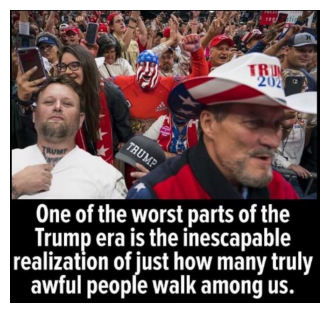

In [877]:
# visualizing a random meme

img_path = aug_df.iloc[215, 0]
img = mpimg.imread(img_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### 3.2.1 Filtering out large images <a class="anchor" id="sixth-bullet"></a>

Extracting image dimensions: 100%|██████████████████████████████████████████████████████| 2668/2668 [00:00<00:00, 4612.14it/s]


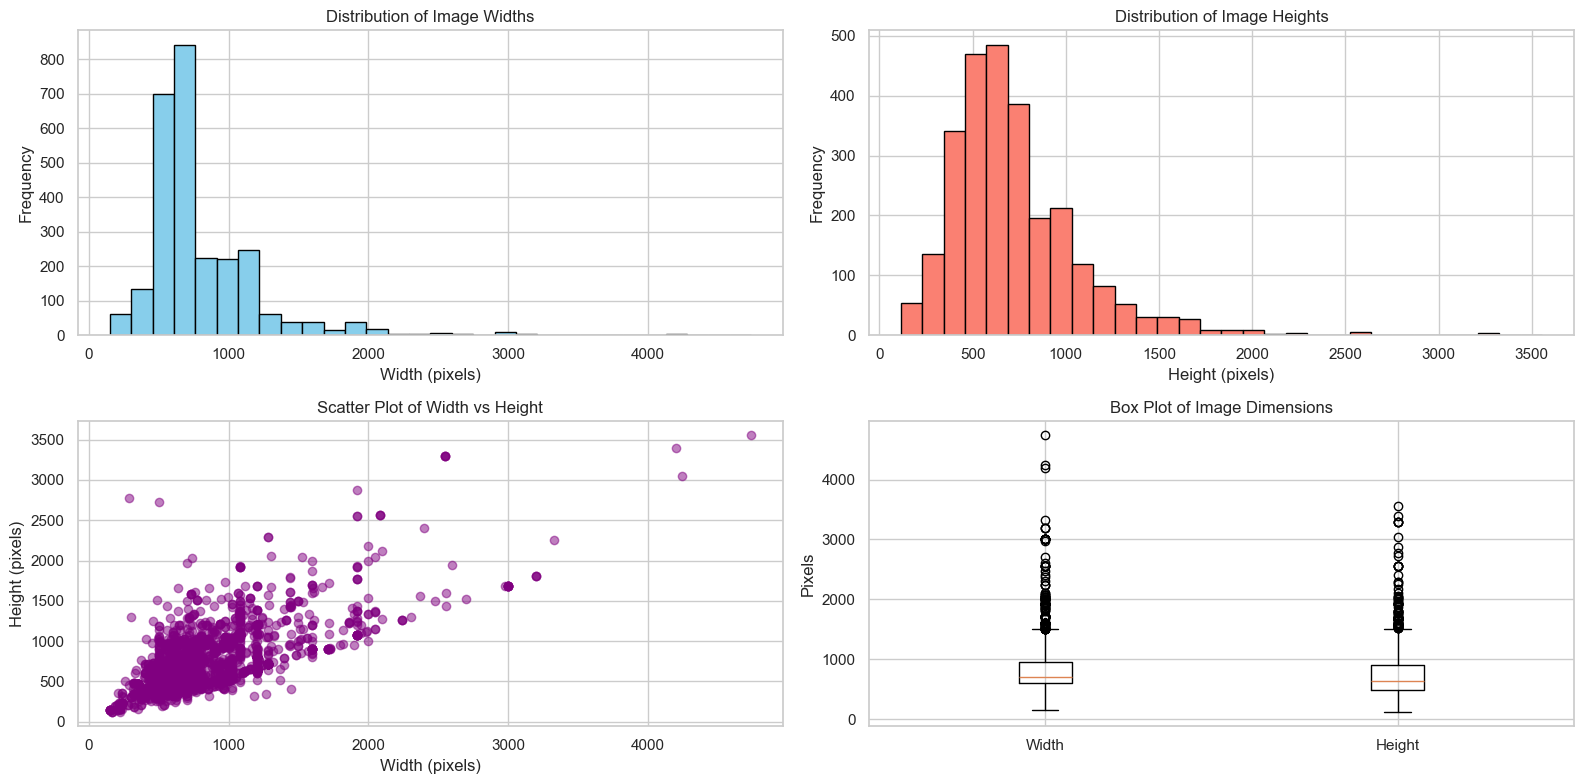

In [878]:
# Add width and height columns to the DataFrame
def extract_image_dimensions(df):
    widths, heights = [], []
    for path in tqdm(df['image_path'], desc="Extracting image dimensions"):
        try:
            with Image.open(path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            widths.append(None)
            heights.append(None)
            print(f"Error with image {path}: {e}")
    df['width'] = widths
    df['height'] = heights
    return df

# Example: Extract dimensions
aug_df = extract_image_dimensions(aug_df)

# Visualization
plt.figure(figsize=(16, 8))

# Histogram for widths
plt.subplot(2, 2, 1)
plt.hist(aug_df['width'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")

# Histogram for heights
plt.subplot(2, 2, 2)
plt.hist(aug_df['height'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")

# Scatter plot for width vs. height
plt.subplot(2, 2, 3)
plt.scatter(aug_df['width'], aug_df['height'], alpha=0.5, color='purple')
plt.title("Scatter Plot of Width vs Height")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")

# Box plot for dimensions
plt.subplot(2, 2, 4)
plt.boxplot([aug_df['width'].dropna(), aug_df['height'].dropna()], labels=['Width', 'Height'])
plt.title("Box Plot of Image Dimensions")
plt.ylabel("Pixels")

plt.tight_layout()
plt.show()


<div class="alert alert-info" role="alert">
There are some images which are outliers in terms of width and height. These images will be removed since resizing them will affect the aspect ratio of the image and affect the optical character recognition (OCR) output. The images which are more than 2000 pixels in width and 2500 pixels in height will be considered as outliers and subsequently removed. 
</div>

In [344]:
too_large = aug_df[(aug_df['width'] > 2000) | (aug_df['height'] > 2500)]
print(f"Number of images with width > 2000 or height > 2500: {len(too_large)}")

aug_df = aug_df[(aug_df['width'] <= 2000) & (aug_df['height'] <= 2500)]
print(f"Number of images after filtering: {len(aug_df)}")

Number of images with width > 2000 or height > 2500: 48
Number of images after filtering: 2588


#### 3.2.2 Removing duplicate images <a class="anchor" id="seventh-bullet"></a>

In [345]:
def image_hash(image_path, size=(256, 256)):
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB').resize(size)
            img_bytes = img.tobytes()
            return hashlib.md5(img_bytes).hexdigest()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
    
def label_duplicates(df, size=(256, 256)):
    tqdm.pandas(desc="Computing image hashes")
    df['image_hash'] = df['image_path'].progress_apply(lambda path: image_hash(path, size))
    duplicate_hashes = df['image_hash'].value_counts()[df['image_hash'].value_counts() > 1].index
    df['duplicate'] = df['image_hash'].apply(lambda x: 1 if x in duplicate_hashes else 0)
    
    return df

aug_df = label_duplicates(aug_df)
aug_df.head()

Computing image hashes: 100%|█████████████████████████████████████████████████████████████| 2588/2588 [00:32<00:00, 78.97it/s]


image_path  label  width  height  \
0  ./dataset/violence against women meme offensiv...      1    575     500   
1  ./dataset/violence against women meme offensiv...      1    600     600   
2  ./dataset/violence against women meme offensiv...      1   1200    1095   
3  ./dataset/violence against women meme offensiv...      1    736     913   
4  ./dataset/violence against women meme offensiv...      1    600     692   

                         image_hash  duplicate  
0  421ba6dc0f109c51b090ca04509bce33          1  
1  aa4d925a75427431921a06ea8729acf5          1  
2  0d8a65051e1764e421af5fc897dd7ed8          0  
3  275ab8de6b3f9f53fb9fb9f3f18f2b4e          1  
4  8b32de0a2b61316aa3b5cda81dcd9fa8          1

<div class="alert alert-info" role="alert">
After looking through the folder with the images, it was observed that some of the scraped images were duplicated. These images will need to be identified and removed since it can lead to overfitting.
<br>
To remove duplicate images, hashing was used to hash the images and these hashes were compared. If the hash is equal it means the images are the same, and therefore only one of them needs to be retained. 
</div>

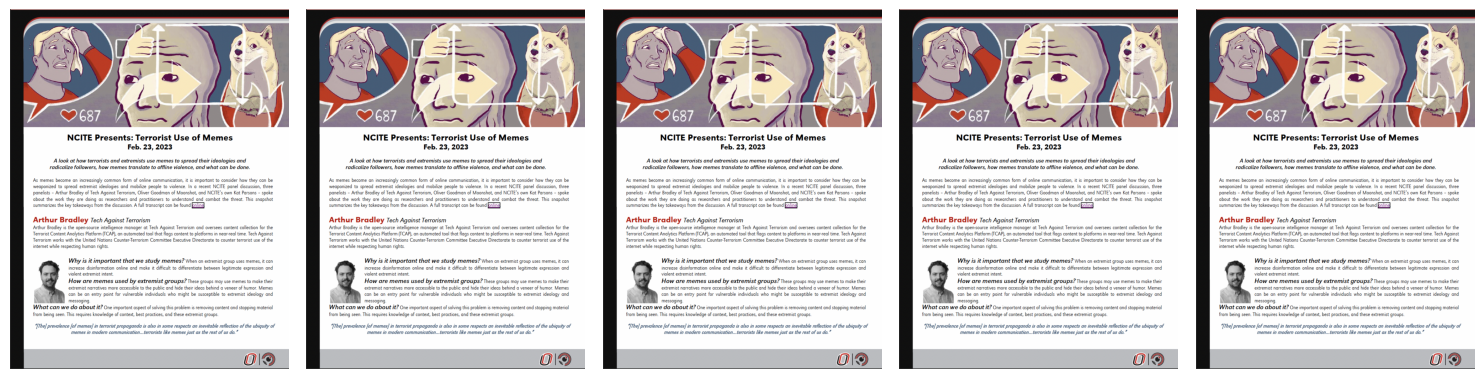

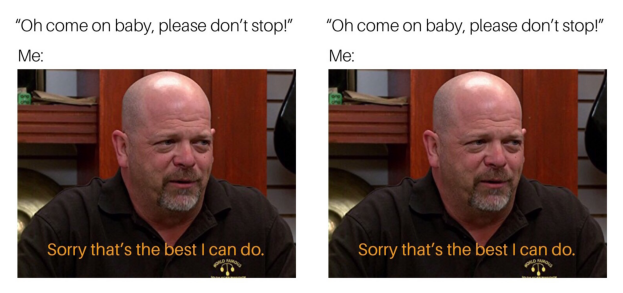

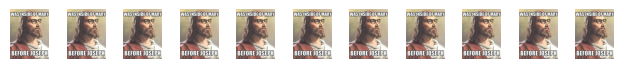

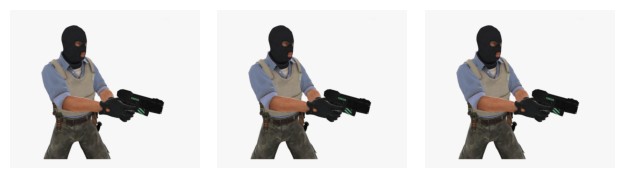

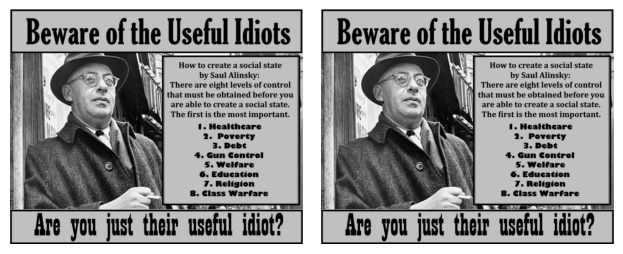

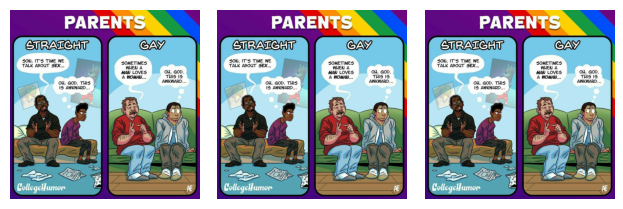

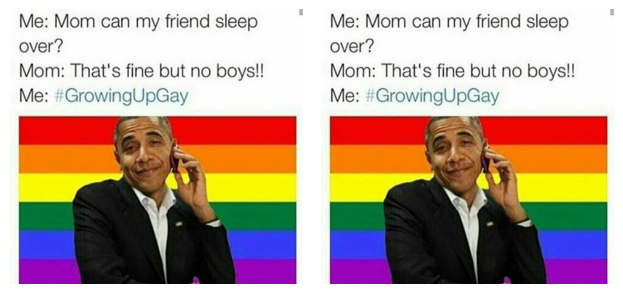

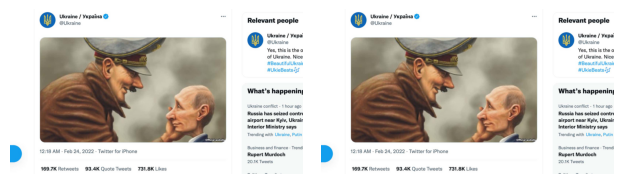

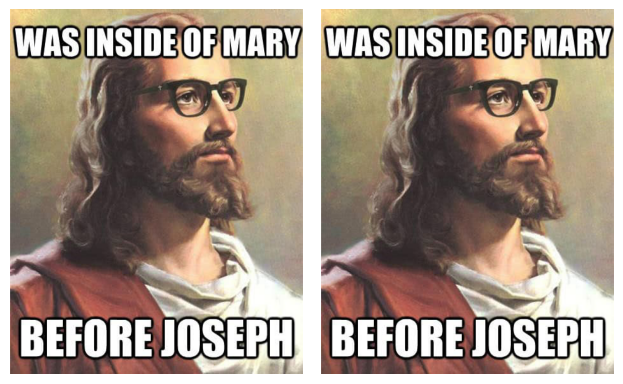

In [346]:
def display_duplicate_pairs(df, limit_num):
    duplicate_images = df[df['duplicate'] == 1]

    duplicate_groups = duplicate_images.groupby('image_hash')['image_path'].apply(list)

    plt.figure(figsize=(15, 5))
    
    i = 1
    for _, image_paths in duplicate_groups.items():
        if i > limit_num:
            break
        if len(image_paths) > 1:
            for j, image_path in enumerate(image_paths):
                img = Image.open(image_path)
                
                plt.subplot(1, len(image_paths), j + 1)
                plt.imshow(img)
                plt.axis('off')
            
            i += 1
            plt.tight_layout()
            plt.show()

display_duplicate_pairs(aug_df, limit_num=10)

In [347]:
def remove_duplicates(df):
    df_unique = df.drop_duplicates(subset='image_hash', keep='first')
    return df_unique

aug_df = remove_duplicates(aug_df)
aug_df.head()

image_path  label  width  height  \
0  ./dataset/violence against women meme offensiv...      1    575     500   
1  ./dataset/violence against women meme offensiv...      1    600     600   
2  ./dataset/violence against women meme offensiv...      1   1200    1095   
3  ./dataset/violence against women meme offensiv...      1    736     913   
4  ./dataset/violence against women meme offensiv...      1    600     692   

                         image_hash  duplicate  
0  421ba6dc0f109c51b090ca04509bce33          1  
1  aa4d925a75427431921a06ea8729acf5          1  
2  0d8a65051e1764e421af5fc897dd7ed8          0  
3  275ab8de6b3f9f53fb9fb9f3f18f2b4e          1  
4  8b32de0a2b61316aa3b5cda81dcd9fa8          1

In [801]:
aug_df.shape

(1750, 6)

In [804]:
aug_df.to_csv("web_scraped_memes.csv", index=False)

#### 3.2.3 Extracting Text from memes using OCR methods <a class="anchor" id="eighth-bullet"></a>

In this stage, experimented with traditional OCR methods and libraries to show that it is ineffective for this task. Instead vision language models (VLM) were used to do the text extraction from the image. 

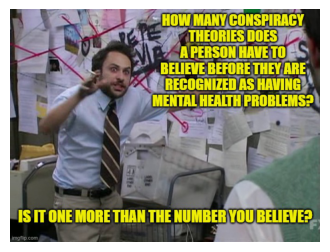

In [742]:
img_path = aug_df.iloc[130, 0]
img = mpimg.imread(img_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

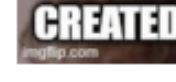
<div class="alert alert-info" role="alert">
The next step in processing is to extract the text from the meme images. The problem here is that the text is embedded on the image, which confuses the OCR, giving poor results. Image processing will need to be done to fix that. 
<br><br>
    
First image processing step will be to remove the watermarks and small texts that do not contribute much to the analysis and affect the OCR output. Like in the above meme, bottom right corner, there is a imgflip.com small text watermark which is unnecessary to the analysis. 
</div>

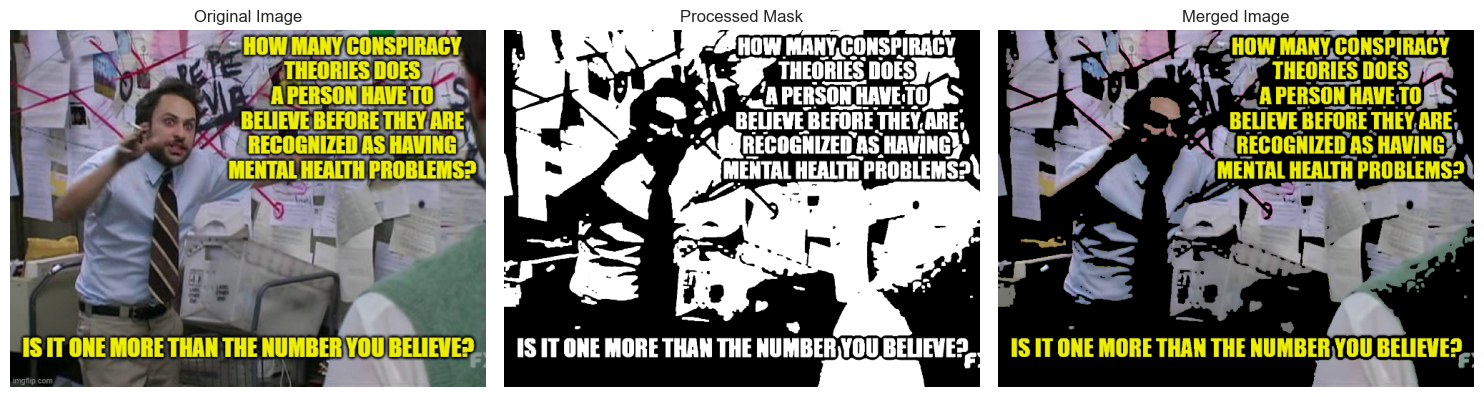

In [784]:
# removing the small watermarks from the images

def preprocess_image_for_ocr(im, resize_dim=(1280, 1024), alpha=1.2, beta=-7):
    im_resized = cv2.resize(im, resize_dim, interpolation=cv2.INTER_LINEAR)
    im_enhanced = cv2.convertScaleAbs(im_resized, alpha=alpha, beta=beta)
    im_gray = cv2.cvtColor(im_enhanced, cv2.COLOR_BGR2GRAY)

    _, im_thresh = cv2.threshold(im_gray, 127, 255, cv2.THRESH_BINARY_INV)
    
    kernel = np.ones((6, 6), np.uint8)
    im_morph = cv2.morphologyEx(im_thresh, cv2.MORPH_CLOSE, kernel)
    
    return cv2.bitwise_not(im_morph)


img_path = aug_df.iloc[131, 0] # 131, 
img = np.array(Image.open(img_path))
processed_img = preprocess_image_for_ocr(img)

original_size = img.shape[:2]
mask_resized = cv2.resize(processed_img, (original_size[1], original_size[0]), interpolation=cv2.INTER_LINEAR)
mask_3channel = cv2.merge([mask_resized, mask_resized, mask_resized])
merged_image = cv2.bitwise_and(img, mask_3channel)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Processed Mask')
plt.imshow(mask_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Merged Image')
plt.imshow(merged_image)
plt.axis('off')

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
From the above, it can be seen that the watermark is gone thanks to the <code>cv2.morphologyEx</code> function which removes small objects from the filter map. For the `cv2.morphologyEx` function to work properly additional steps were also done such as image resizing, thresholding and convertScaleAbs which helps to adjust brightness and contrast. This allows the text to stand out better amongst the image. 

In the next step different techniques will be applied to remove/dim the effect of the image and ensure only the text remains. This will allow the OCR to better find the text. 
</div>

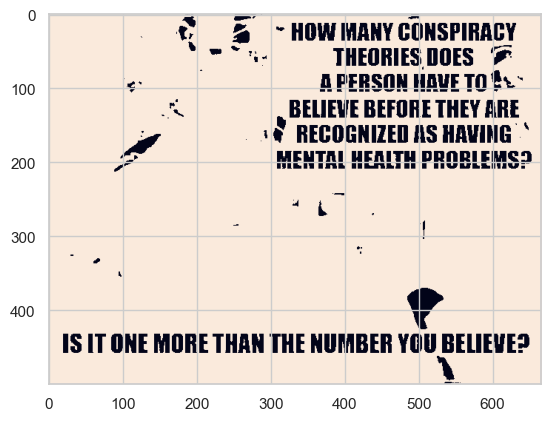

In [791]:
# image processing steps such as thresholding, edge detection, contrast adjustment, etc
# this is done to extract text from the OCR

def img_text_extraction(im):
    im = cv2.bilateralFilter(im, 5, 55, 60)
    
    im = cv2.cvtColor(im, cv2.COLOR_BGR2XYZ)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    _, im_binary = cv2.threshold(im, 180, 255, cv2.THRESH_BINARY)
    plt.imshow(im_binary)

    return im_binary


res = cv2.bitwise_not(img_text_extraction(merged_image))
plt.imshow(res)

<div class="alert alert-info" role="alert">
Successfully managed to separate out the text from the image, now this image will be passed to the docTR ocr model to extract the text. Out of the other free open-source OCR models, docTR is by far the most robust one among them. 
</div>

In [792]:
cv2.imwrite('processed_image.png', res)

# Wrap the image in a DocumentFile for OCR prediction
doc_file = DocumentFile.from_images('processed_image.png')

# Perform OCR
result = model(doc_file)

extract_info = result.export()

In [793]:
from symspellpy import SymSpell, Verbosity
import pkg_resources

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load the dictionary from SymSpell (using the default English dictionary)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Assuming 'extract_info' is the OCR result
res = ""

# Iterate over the OCR results and apply SymSpell correction to each word
for obj1 in extract_info['pages'][0]["blocks"]:
    for obj2 in obj1["lines"]:
        for obj3 in obj2["words"]:
            word = wn.split(obj3["value"])
            for i in word:
                # Apply SymSpell correction
                suggestions = sym_spell.lookup(i, Verbosity.CLOSEST, max_edit_distance=2)
                # Get the closest correction suggestion, or keep the word if no suggestions
                corrected_word = suggestions[0].term if suggestions else i

                print(f"Original Word: {i} | Corrected Word: {corrected_word}")
                res += f" {corrected_word} "

# Print the corrected text
print("\nCORRECTED TEXT:\n", res)

Original Word: HOW | Corrected Word: HOW
Original Word: MANY | Corrected Word: MANY
Original Word: CONSPIRACY | Corrected Word: CONSPIRACY
Original Word: THEORIES | Corrected Word: THEORIES
Original Word: DOES | Corrected Word: DOES
Original Word: A | Corrected Word: a
Original Word: AF | Corrected Word: of
Original Word: PERSON | Corrected Word: PERSON
Original Word: HAVE | Corrected Word: HAVE
Original Word: TO | Corrected Word: of
Original Word: EL | Corrected Word: of
Original Word: BELIEVE | Corrected Word: BELIEVE
Original Word: BEFORE | Corrected Word: BEFORE
Original Word: THEY | Corrected Word: THEY
Original Word: ARE | Corrected Word: ARE
Original Word: RECOGNIZE | Corrected Word: RECOGNIZE
Original Word: U | Corrected Word: a
Original Word: AS | Corrected Word: of
Original Word: HAVING | Corrected Word: HAVING
Original Word: 4 | Corrected Word: a
Original Word: MENTAL | Corrected Word: MENTAL
Original Word: HEALTH | Corrected Word: HEALTH
Original Word: PROBLEMS | Corrected 

In [798]:
# testing model with tesseract

image_path = 'processed_image.png'

image = cv2.imread(image_path)
extracted_text = pytesseract.image_to_string(image)

print("Extracted Text:")
print(extracted_text)

Extracted Text:
% 4 ~ HOW MANY CONSPIRACY
owe THEORIES DOES ¥
% APERSON HAVE TO #=~
wf _ BELIEVE BEFORE THEY ARE
4 .#) RECOGNIZED AS HAVING *
” MENTAL HEALTH PROBLEMS?

“kb

1S IT ONE MORE THAN THE NUMBER YOU BELIEVE?



In [799]:
# testing with easyOCR

reader = easyocr.Reader(['en'])

# Use EasyOCR to extract text from the image
result = reader.readtext(image)

# Extracted text
extracted_text = "\n".join([text[1] for text in result])

print("Extracted Text:")
print(extracted_text)

Extracted Text:
HOW MANY CONSPIRACY
THEORIES DOES
A PERSON HAVE TO 6e
BELIEVE BEFORE THEY ARE
RECOGNIZED AS HAVING `
MENTAL HEALTH PROBLEMS?
IS IT ONE MORE THAN THE NUMBER YOU BELIEVE?


<div class="alert alert-info" role="alert">
As seen, the OCR results are not very accurate, inspite of doing text processing and spelling correction, which means that the model accuracy will be affected. Instead of using traditional OCR methods, let's try a more sophisticated vision language model for OCR. I will be using a smaller model, which is the smol-vlm from HuggingFace. The VLM will be prompted to do OCR and extract the text successfully.
    
<br><br>
    
The VLM workflow is placed in the <code>smol-VLM_ocr_extraction.ipynb</code> file. This was run overnight on google colab so to keep the notebook execution fast and simple I only included the VLM code in it. 
</div>

## 4. Merging Datasets

In [5]:
aug_df = pd.read_csv("./aug_df_with_meme_texts.csv")
aug_df.head()

image_path  label  width  height  \
0  ./dataset/violence against women meme offensiv...      1    575     500   
1  ./dataset/violence against women meme offensiv...      1    600     600   
2  ./dataset/violence against women meme offensiv...      1   1200    1095   
3  ./dataset/violence against women meme offensiv...      1    736     913   
4  ./dataset/violence against women meme offensiv...      1    600     692   

                         image_hash  duplicate  \
0  421ba6dc0f109c51b090ca04509bce33          1   
1  aa4d925a75427431921a06ea8729acf5          1   
2  0d8a65051e1764e421af5fc897dd7ed8          0   
3  275ab8de6b3f9f53fb9fb9f3f18f2b4e          1   
4  8b32de0a2b61316aa3b5cda81dcd9fa8          1   

                                           meme_text     status  
0  User:<image>Extract all the meme text from the...  processed  
1  User:<image>Extract all the meme text from the...  processed  
2  User:<image>Extract all the meme text from the...  processed  
3  User:<image>Extract all the meme text from the...  processed  
4  User:<image>Extract all the meme text from the...  processed

In [6]:
aug_df.status.value_counts()

status
processed    1749
error           1
Name: count, dtype: int64

In [7]:
aug_df = aug_df[aug_df["status"] != "error"]
aug_df.shape

(1749, 8)

In [8]:
unnecessary_col = ['duplicate', 'width', 'height', 'image_hash', 'status']
aug_df.drop(columns=unnecessary_col, errors='coerce', inplace=True)

In [9]:
aug_df.head()

image_path  label  \
0  ./dataset/violence against women meme offensiv...      1   
1  ./dataset/violence against women meme offensiv...      1   
2  ./dataset/violence against women meme offensiv...      1   
3  ./dataset/violence against women meme offensiv...      1   
4  ./dataset/violence against women meme offensiv...      1   

                                           meme_text  
0  User:<image>Extract all the meme text from the...  
1  User:<image>Extract all the meme text from the...  
2  User:<image>Extract all the meme text from the...  
3  User:<image>Extract all the meme text from the...  
4  User:<image>Extract all the meme text from the...

In [10]:
aug_df.meme_text[10]

# all the texts have the user prompt in the start which is noise
# best to remove it

"User:<image>Extract all the meme text from the provided image.\nAssistant: Once you pop...you can't stop."

In [11]:
prefix_to_remove = "User:<image>Extract all the meme text from the provided image.\nAssistant: "

aug_df["meme_text"] = aug_df["meme_text"].str.replace(prefix_to_remove, "", regex=False)

for i in range(3):
    print("CLEANED HARMFUL MEME TEXT:", aug_df.meme_text[i], end="\n\n")

CLEANED HARMFUL MEME TEXT: When mom takes away my fidget spinner.

CLEANED HARMFUL MEME TEXT: Morning wood? You mean my wife's alarm clock.

CLEANED HARMFUL MEME TEXT: Orange house with a person sitting in it.



In [12]:
train_df = pd.read_json('./hateful_memes/train.jsonl', lines=True)
train_df.head()

id            img  label  \
0  42953  img/42953.png      0   
1  23058  img/23058.png      0   
2  13894  img/13894.png      0   
3  37408  img/37408.png      0   
4  82403  img/82403.png      0   

                                                text  
0   its their character not their color that matters  
1  don't be afraid to love again everyone is not ...  
2                           putting bows on your pet  
3  i love everything and everybody! except for sq...  
4  everybody loves chocolate chip cookies, even h...

In [13]:
train_df[train_df.id.duplicated()]

# there are no duplicate IDs

Empty DataFrame
Columns: [id, img, label, text]
Index: []

In [14]:
train_df.drop(columns=['id'], errors='ignore', inplace=True)

In [15]:
train_df['img'] = './hateful_memes/' + train_df['img']
train_df.head()

img  label  \
0  ./hateful_memes/img/42953.png      0   
1  ./hateful_memes/img/23058.png      0   
2  ./hateful_memes/img/13894.png      0   
3  ./hateful_memes/img/37408.png      0   
4  ./hateful_memes/img/82403.png      0   

                                                text  
0   its their character not their color that matters  
1  don't be afraid to love again everyone is not ...  
2                           putting bows on your pet  
3  i love everything and everybody! except for sq...  
4  everybody loves chocolate chip cookies, even h...

In [16]:
aug_df.head()

image_path  label  \
0  ./dataset/violence against women meme offensiv...      1   
1  ./dataset/violence against women meme offensiv...      1   
2  ./dataset/violence against women meme offensiv...      1   
3  ./dataset/violence against women meme offensiv...      1   
4  ./dataset/violence against women meme offensiv...      1   

                                           meme_text  
0             When mom takes away my fidget spinner.  
1      Morning wood? You mean my wife's alarm clock.  
2          Orange house with a person sitting in it.  
3  When captain man calls you to the man cave at ...  
4                                  KILL ALL JEWISHS.

In [17]:
train_df = train_df.rename(columns={
    "img": "image_path",
    "text": "meme_text"
})

train_df = pd.concat([aug_df, train_df], ignore_index=True)
train_df.head()

image_path  label  \
0  ./dataset/violence against women meme offensiv...      1   
1  ./dataset/violence against women meme offensiv...      1   
2  ./dataset/violence against women meme offensiv...      1   
3  ./dataset/violence against women meme offensiv...      1   
4  ./dataset/violence against women meme offensiv...      1   

                                           meme_text  
0             When mom takes away my fidget spinner.  
1      Morning wood? You mean my wife's alarm clock.  
2          Orange house with a person sitting in it.  
3  When captain man calls you to the man cave at ...  
4                                  KILL ALL JEWISHS.

## 5. Exploratory Data Analysis

In [18]:
label_counts = train_df['label'].value_counts()
label_counts.index = label_counts.index.map({0: 'Not Hate', 1: 'Hate'})
label_counts

label
Not Hate    5481
Hate        4768
Name: count, dtype: int64

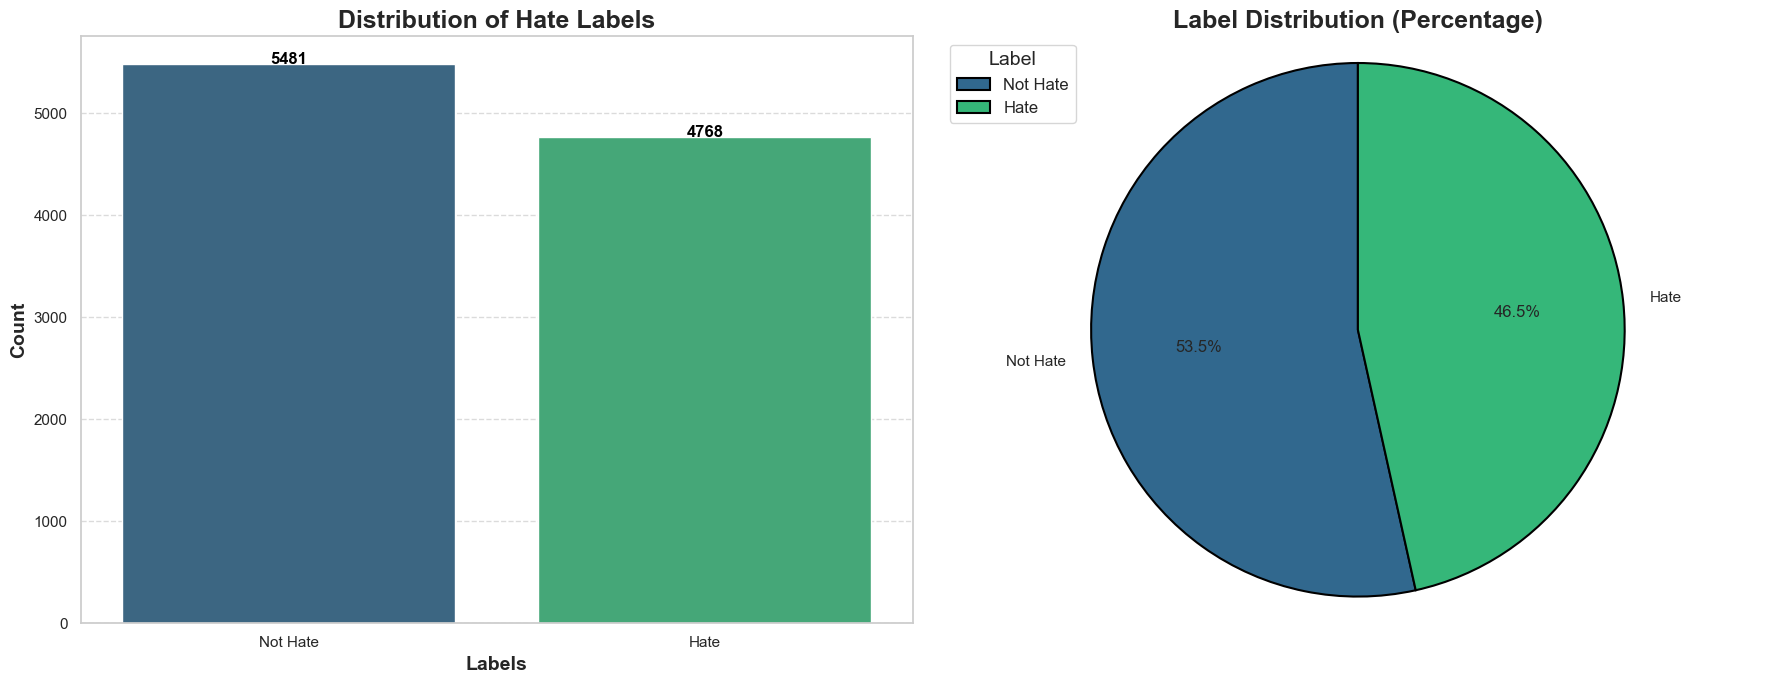

In [19]:
label_counts = label_counts.reset_index()
label_counts.columns = ['label', 'count']

viridis_palette = sns.color_palette("viridis", len(label_counts))
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# the bar chart
sns.barplot(
    x='label', 
    y='count', 
    data=label_counts, 
    ax=axes[0], 
    palette=viridis_palette
)

for i, row in label_counts.iterrows():
    axes[0].text(
        i, 
        row['count'] + 0.2, 
        str(row['count']), 
        ha='center', 
        fontsize=12, 
        color='black', 
        fontweight='bold'
    )

axes[0].set_title("Distribution of Hate Labels", fontsize=18, fontweight='bold')
axes[0].set_xlabel("Labels", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Count", fontsize=14, fontweight='bold')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)

# the pie chart
axes[1].pie(
    label_counts['count'], 
    labels=label_counts['label'], 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=viridis_palette, 
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)
axes[1].axis('equal')
axes[1].set_title("Label Distribution (Percentage)", fontsize=18, fontweight='bold')

axes[1].legend(
    labels=label_counts['label'], 
    loc="upper left", 
    title="Label", 
    fontsize=12, 
    title_fontsize=14
)

plt.tight_layout()
plt.show()

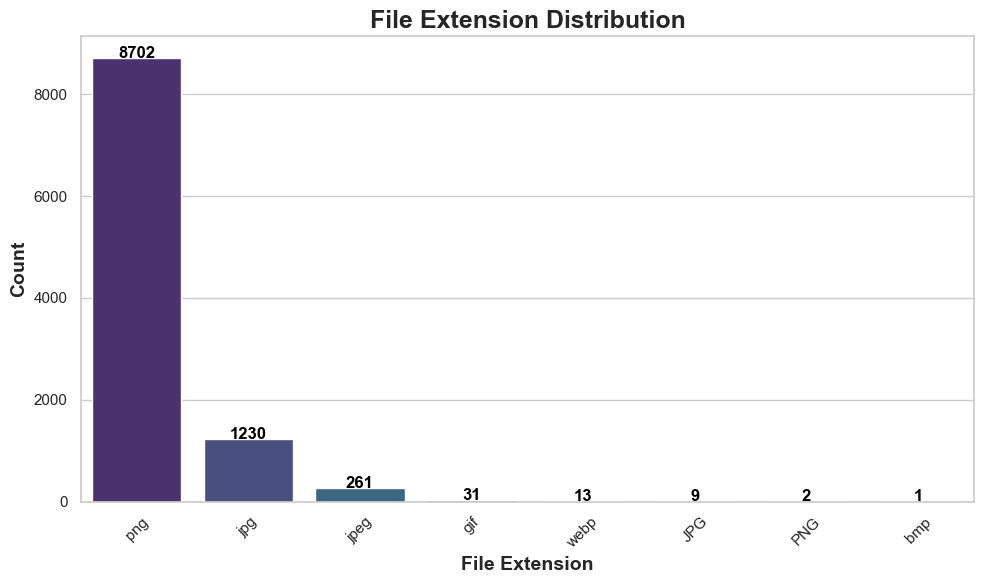

In [20]:
train_df['file_extension'] = train_df['image_path'].apply(lambda path: os.path.splitext(path)[1][1:] if pd.notnull(path) else '')

file_extension_counts = train_df['file_extension'].value_counts().reset_index()
file_extension_counts.columns = ['file_extension', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(x='file_extension', y='count', data=file_extension_counts, palette='viridis')

for i, row in file_extension_counts.iterrows():
    plt.text(i, row['count'] + 0.2, str(row['count']), ha='center', fontsize=12, color='black', fontweight='bold')

plt.title("File Extension Distribution", fontsize=18, fontweight='bold')
plt.xlabel("File Extension", fontsize=14, fontweight='bold')
plt.ylabel("Count", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### 5.1 Text Based EDA

In [21]:
def find_language_codes(text):
    cleaned_text = text.replace("\n", "") 
    return detector.detect_language_of(text)

tqdm.pandas(desc="Detecting language codes")
train_df["language_code"] = train_df["meme_text"].progress_apply(find_language_codes)
train_df.head(3)

Detecting language codes: 100%|███████████████████████████████████████████████████████| 10249/10249 [00:08<00:00, 1166.80it/s]


image_path  label  \
0  ./dataset/violence against women meme offensiv...      1   
1  ./dataset/violence against women meme offensiv...      1   
2  ./dataset/violence against women meme offensiv...      1   

                                       meme_text file_extension  \
0         When mom takes away my fidget spinner.            jpg   
1  Morning wood? You mean my wife's alarm clock.            jpg   
2      Orange house with a person sitting in it.            gif   

      language_code  
0  Language.ENGLISH  
1  Language.ENGLISH  
2  Language.ENGLISH

In [22]:
train_df[train_df['language_code'] != Language.ENGLISH].head(10)

image_path  label  \
24  ./dataset/terrorist organizations meme offensi...      1   
26  ./dataset/terrorist organizations meme offensi...      1   
31  ./dataset/terrorist organizations meme offensi...      1   
35  ./dataset/terrorist organizations meme offensi...      1   
37  ./dataset/terrorist organizations meme offensi...      1   
41  ./dataset/climate change denial meme offensive...      1   
67  ./dataset/gang violence meme offensive/Image_1...      1   
68  ./dataset/gang violence meme offensive/Image_5...      1   
73  ./dataset/gang violence meme offensive/Image_1...      1   
90  ./dataset/cultural appropriation meme offensiv...      1   

              meme_text file_extension        language_code  
24             Facebook            jpg      Language.SLOVAK  
26          PC DVD ROM.           jpeg      Language.SLOVAK  
31                SITE.            JPG      Language.FRENCH  
35       Hamas is ISIS.            jpg      Language.TSONGA  
37        Allahu Akbar!            jpg       Language.MALAY  
41                Time.            jpg    Language.ESTONIAN  
67      Meme them gang.            png        Language.ZULU  
68    Bloodz and Cripz.            jpg      Language.TSONGA  
73  Yes I am in a gang.            jpg     Language.TAGALOG  
90          grande dia.            jpg  Language.PORTUGUESE

In [23]:
def get_sentence_length(sentence):
    return len(sentence.split()) if pd.notnull(sentence) else 0

def get_average_word_length(sentence):
    words = sentence.split()
    return np.mean([len(word) for word in words]) if words else 0

train_df['sentence_length'] = train_df['meme_text'].apply(get_sentence_length)
train_df['average_word_length'] = train_df['meme_text'].apply(get_average_word_length)

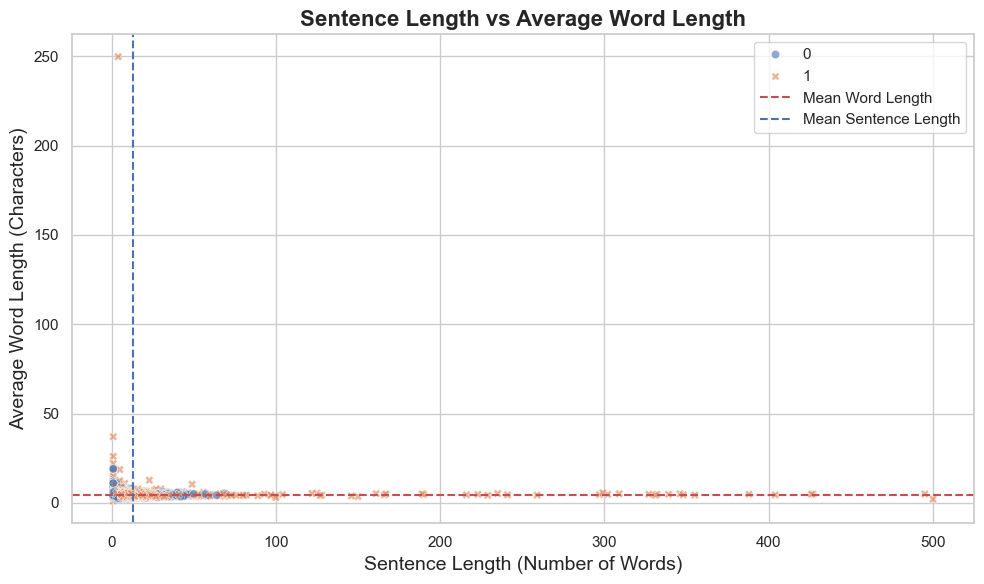

In [24]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=train_df, x='sentence_length', y='average_word_length', color='purple', alpha=0.6, hue='label', style='label')

plt.title('Sentence Length vs Average Word Length', fontsize=16, fontweight='bold')
plt.xlabel('Sentence Length (Number of Words)', fontsize=14)
plt.ylabel('Average Word Length (Characters)', fontsize=14)

plt.axhline(y=train_df['average_word_length'].mean(), color='r', linestyle='--', label='Mean Word Length')
plt.axvline(x=train_df['sentence_length'].mean(), color='b', linestyle='--', label='Mean Sentence Length')

plt.legend()
plt.tight_layout()
plt.show()

In [25]:
def count_punctuation_types(sentence):
    punctuation_count = {punct: 0 for punct in string.punctuation}
    if pd.notnull(sentence):
        for char in sentence:
            if char in string.punctuation:
                punctuation_count[char] += 1
    return punctuation_count

punctuation_data = train_df['meme_text'].apply(count_punctuation_types)
punctuation_df = pd.DataFrame(punctuation_data.tolist())
punctuation_df['label'] = train_df['label']

<Figure size 1200x800 with 0 Axes>

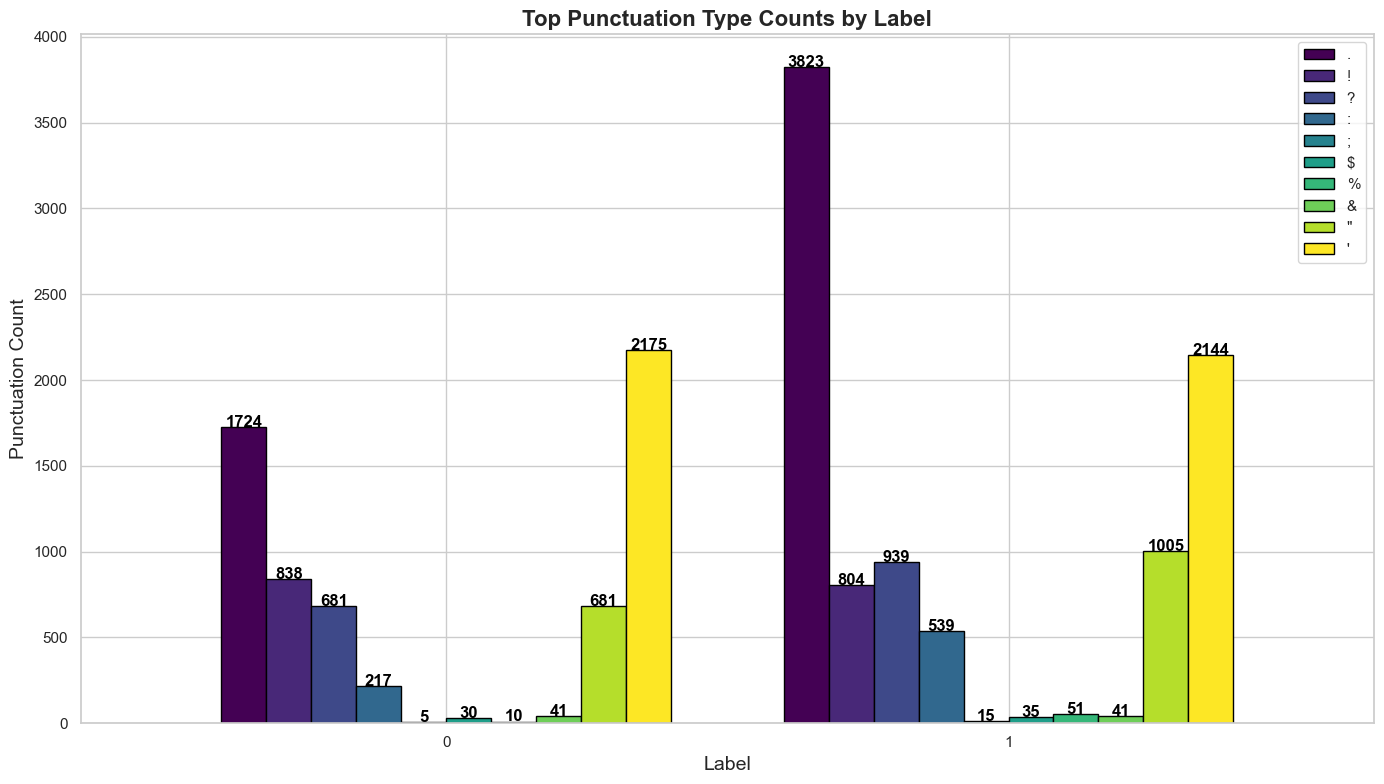

In [26]:
top_punctuations = ['.', '!', '?', ':', ';', '$', '%', '&', '"', "'"]
punctuation_df_top = punctuation_df[top_punctuations + ['label']]

# Group by 'label' and sum punctuation counts for each type
punctuation_by_label = punctuation_df_top.groupby('label').sum()

# Plotting a grouped bar chart for the most common punctuation marks
plt.figure(figsize=(12, 8))

# Plot the grouped bar chart
punctuation_by_label.plot(kind='bar', figsize=(14, 8), edgecolor='black', width=0.8, colormap='viridis')

# Add title and labels
plt.title('Top Punctuation Type Counts by Label', fontsize=16, fontweight='bold')
plt.xlabel('Label', fontsize=14)
plt.ylabel('Punctuation Count', fontsize=14)
plt.xticks(rotation=0)

# Add annotations to show exact counts on top of bars
for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2, p.get_height() + 0.2, 
        str(int(p.get_height())), ha='center', fontsize=12, color='black', fontweight='bold'
    )

# Show the plot
plt.tight_layout()
plt.show()

In [27]:
def extract_features_from_text(text):
    hashtags = len(re.findall(r'#\w+', str(text)))
    emails = len(re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b', str(text)))
    numbers = len(re.findall(r'\b\d+(\.\d+)?\b', str(text)))
    usernames = len(re.findall(r'@\w+', str(text)))
    
    return pd.Series([hashtags, emails, numbers, usernames])

train_df[['hashtags_count', 'emails_count', 'numbers_count', 'usernames_count']] = train_df['meme_text'].apply(extract_features_from_text)

train_df[['meme_text', 'hashtags_count', 'emails_count', 'numbers_count', 'usernames_count']].head()

meme_text  hashtags_count  \
0             When mom takes away my fidget spinner.               0   
1      Morning wood? You mean my wife's alarm clock.               0   
2          Orange house with a person sitting in it.               0   
3  When captain man calls you to the man cave at ...               0   
4                                  KILL ALL JEWISHS.               0   

   emails_count  numbers_count  usernames_count  
0             0              0                0  
1             0              0                0  
2             0              0                0  
3             0              0                0  
4             0              0                0

<Figure size 1400x800 with 0 Axes>

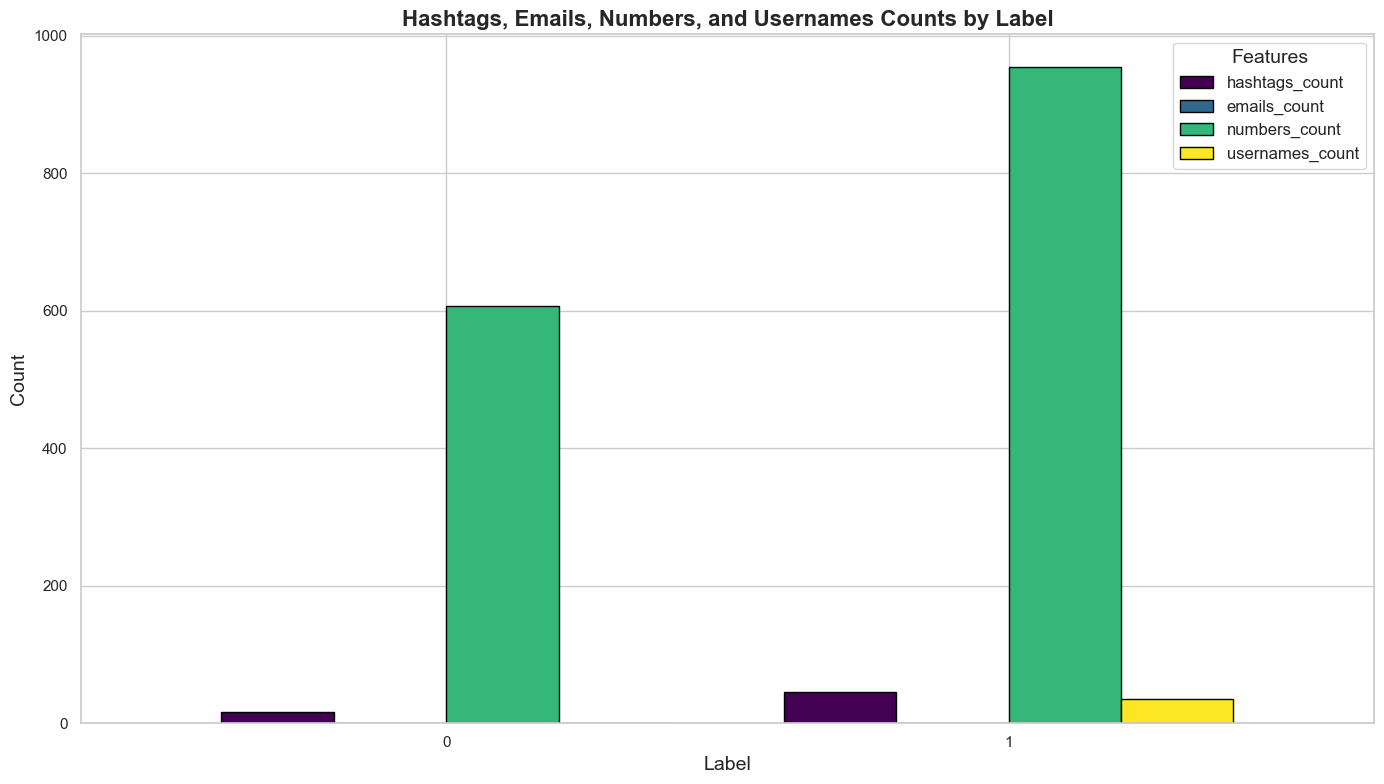

In [28]:
# Group by label and sum the counts for each feature
feature_columns = ['hashtags_count', 'emails_count', 'numbers_count', 'usernames_count']
features_by_label = train_df.groupby('label')[feature_columns].sum()

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot the grouped bar chart
features_by_label.plot(kind='bar', stacked=False, figsize=(14, 8), edgecolor='black', width=0.8, colormap='viridis')

# Add titles and labels
plt.title('Hashtags, Emails, Numbers, and Usernames Counts by Label', fontsize=16, fontweight='bold')
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)

# Add a legend to the chart
plt.legend(title='Features', fontsize=12, title_fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [29]:
def extract_pos_tags(text):
    doc = nlp(str(text))  # Apply spaCy NLP model
    pos_tags = [token.pos_ for token in doc]  # Extract only POS tags
    return pos_tags

tqdm.pandas(desc="POS TAGGING")
train_df['pos_tags'] = train_df['meme_text'].progress_apply(extract_pos_tags)
train_df[['meme_text', 'pos_tags']].head()

POS TAGGING: 100%|█████████████████████████████████████████████████████████████████████| 10249/10249 [00:47<00:00, 216.23it/s]


meme_text  \
0             When mom takes away my fidget spinner.   
1      Morning wood? You mean my wife's alarm clock.   
2          Orange house with a person sitting in it.   
3  When captain man calls you to the man cave at ...   
4                                  KILL ALL JEWISHS.   

                                            pos_tags  
0  [SCONJ, NOUN, VERB, ADV, PRON, NOUN, NOUN, PUNCT]  
1  [NOUN, NOUN, PUNCT, PRON, VERB, PRON, NOUN, PA...  
2  [PROPN, NOUN, ADP, DET, NOUN, VERB, ADP, PRON,...  
3  [SCONJ, NOUN, NOUN, VERB, PRON, ADP, DET, NOUN...  
4                          [VERB, DET, PROPN, PUNCT]

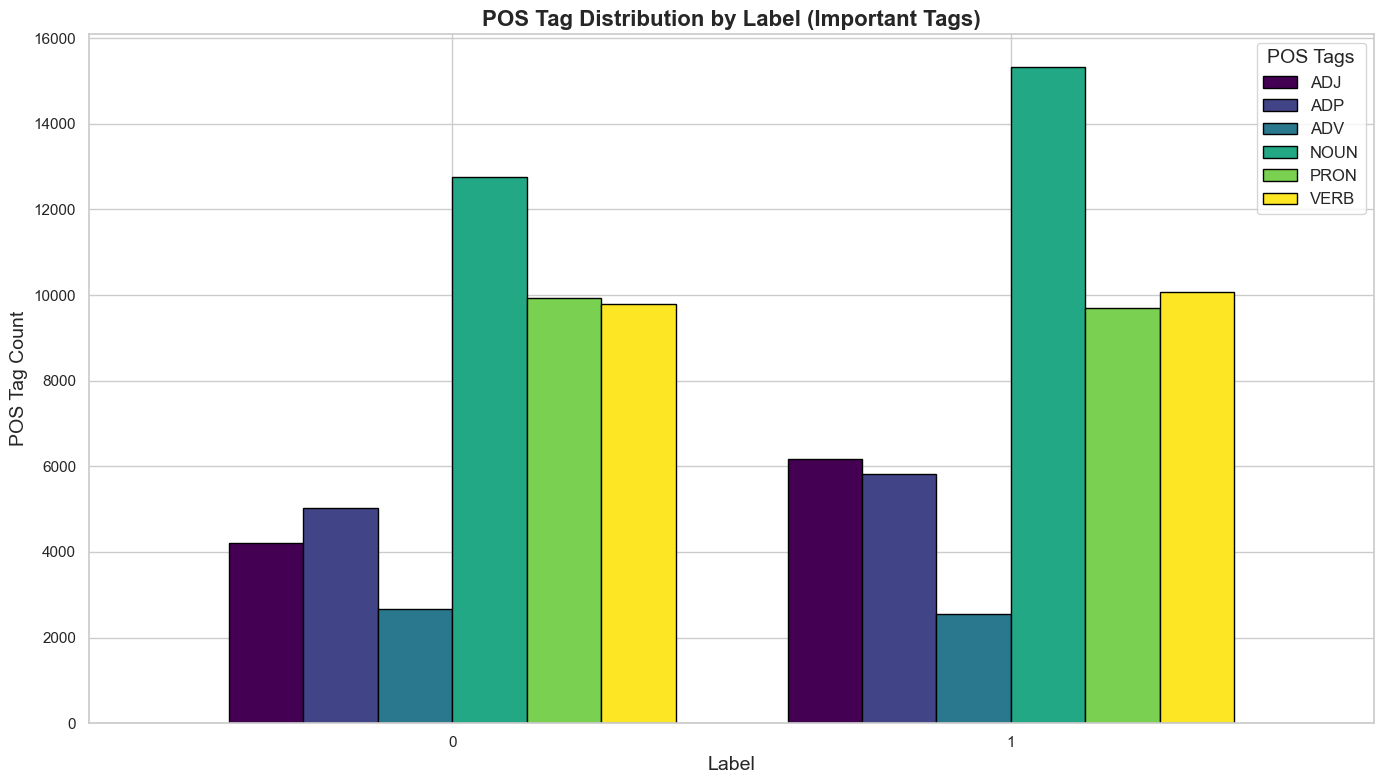

In [30]:
important_pos_tags = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'ADP']
pos_tags_expanded = train_df.explode('pos_tags')

pos_tags_expanded = pos_tags_expanded[pos_tags_expanded['pos_tags'].isin(important_pos_tags)]
pos_tag_counts = pos_tags_expanded.groupby(['label', 'pos_tags']).size().unstack(fill_value=0)

ax = pos_tag_counts.plot(kind='bar', figsize=(14, 8), edgecolor='black', colormap='viridis', width=0.8)

plt.title('POS Tag Distribution by Label (Important Tags)', fontsize=16, fontweight='bold')
plt.xlabel('Label', fontsize=14)
plt.ylabel('POS Tag Count', fontsize=14)
plt.xticks(rotation=0)

plt.legend(title='POS Tags', fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()

In [31]:
def extract_named_entities(text):
    doc = nlp(str(text))  
    entities = [ent.label_ for ent in doc.ents]
    return entities

tqdm.pandas(desc="NER")
train_df['named_entities'] = train_df['meme_text'].progress_apply(extract_named_entities)

NER: 100%|█████████████████████████████████████████████████████████████████████████████| 10249/10249 [00:45<00:00, 225.19it/s]


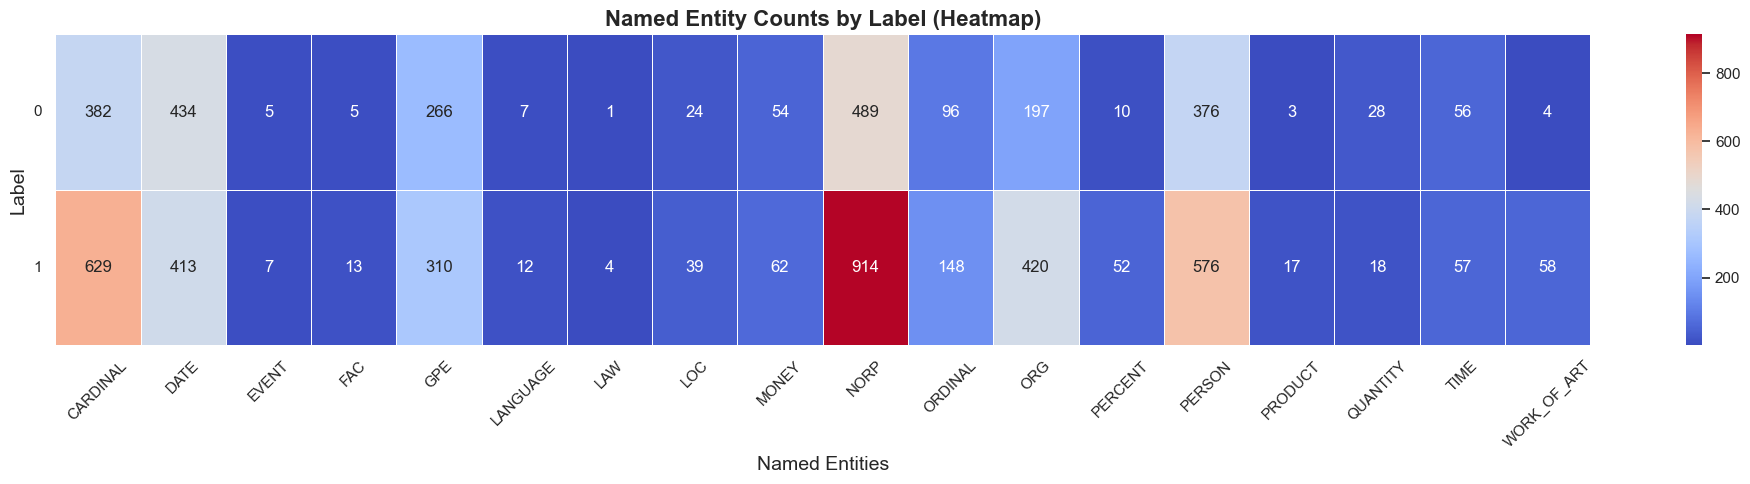

In [33]:
entities_expanded = train_df.explode('named_entities')
entity_counts = entities_expanded.groupby(['label', 'named_entities']).size().unstack(fill_value=0)

plt.figure(figsize=(20, 5))
sns.heatmap(entity_counts, annot=True, cmap='coolwarm', fmt='g', cbar=True, linewidths=0.5)

plt.title('Named Entity Counts by Label (Heatmap)', fontsize=16, fontweight='bold')
plt.xlabel('Named Entities', fontsize=14)
plt.ylabel('Label', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

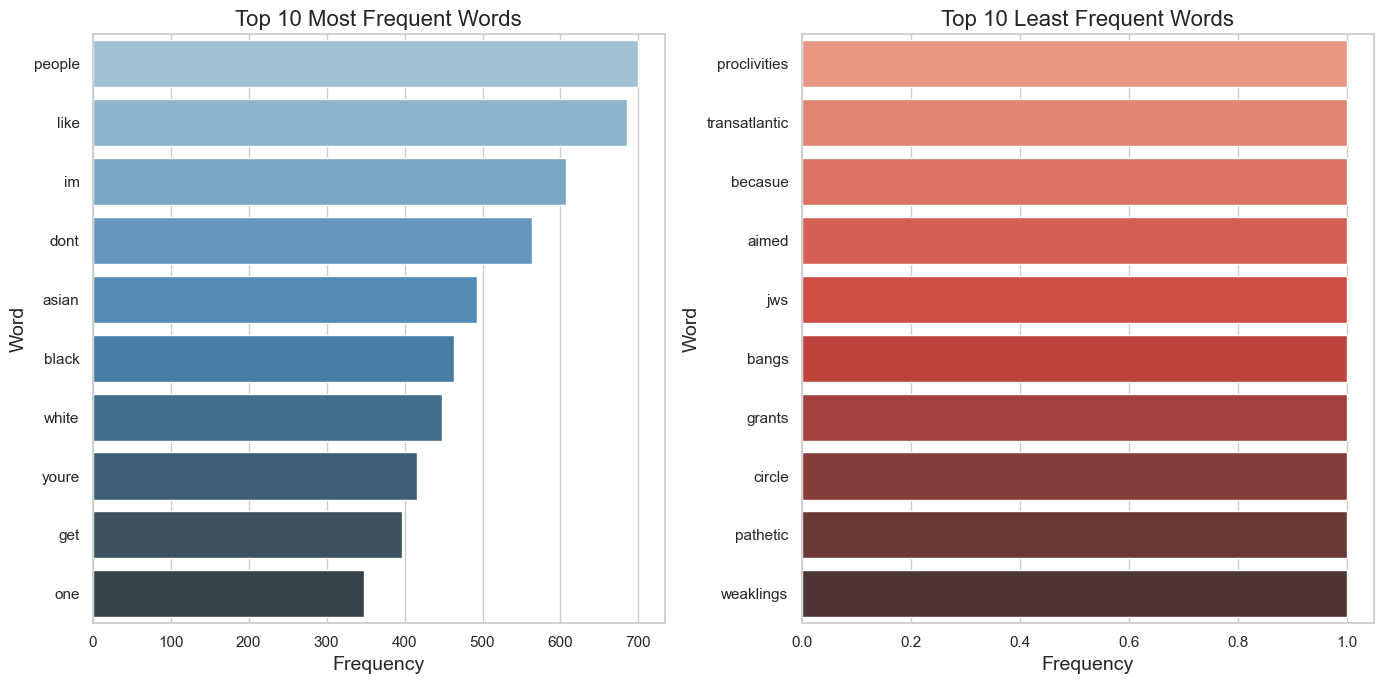

In [63]:
def preprocess_text(text):
    text = re.sub(r"[^\w\s]", "", text)  
    text = re.sub(r"\d+", "", text)  
    text = text.lower()

    words = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    words = [word.strip() for word in words if word not in stop_words]
    
    return words

all_words = train_df['meme_text'].apply(preprocess_text).explode()

word_counts = Counter(all_words)

most_frequent = word_counts.most_common(10)
least_frequent = word_counts.most_common()[-10:]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

most_frequent_words, most_frequent_counts = zip(*most_frequent)
sns.barplot(x=most_frequent_counts, y=most_frequent_words, ax=axes[0], palette="Blues_d")
axes[0].set_title('Top 10 Most Frequent Words', fontsize=16)
axes[0].set_xlabel('Frequency', fontsize=14)
axes[0].set_ylabel('Word', fontsize=14)

least_frequent_words, least_frequent_counts = zip(*least_frequent)
sns.barplot(x=least_frequent_counts, y=least_frequent_words, ax=axes[1], palette="Reds_d")
axes[1].set_title('Top 10 Least Frequent Words', fontsize=16)
axes[1].set_xlabel('Frequency', fontsize=14)
axes[1].set_ylabel('Word', fontsize=14)

plt.tight_layout()
plt.show()

In [75]:
hate_text = train_df[train_df['label'] == 1]['meme_text']
non_hate_text = train_df[train_df['label'] == 0]['meme_text']

hate_words = hate_text.apply(preprocess_text).explode().dropna().map(str)
non_hate_words = non_hate_text.apply(preprocess_text).explode().dropna().map(str)

hate_wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(' '.join(hate_words))
non_hate_wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(' '.join(non_hate_words))

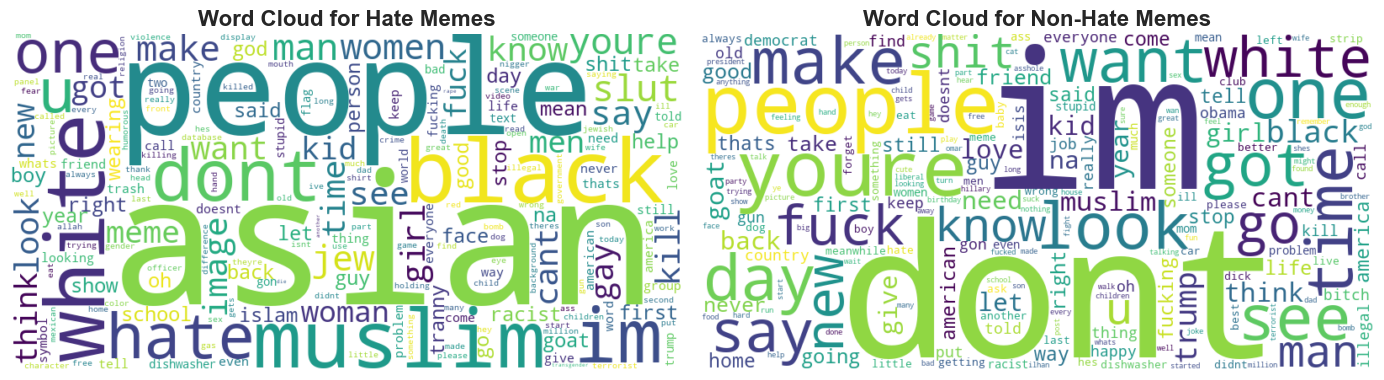

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(hate_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud for Hate Memes', fontsize=16, fontweight='bold')

axes[1].imshow(non_hate_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud for Non-Hate Memes', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

### 5.2 Image Based EDA

In [ ]:
# aspect ratio analysis



In [88]:
# color analysis

def extract_dominant_colors(image_path, n_colors=5):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((100, 100))  
    data = np.array(image).reshape(-1, 3)

    kmeans = KMeans(n_clusters=n_colors, random_state=0)
    kmeans.fit(data)
    colors = kmeans.cluster_centers_
    return colors

In [79]:
hate_images = train_df[train_df['label'] == 1]['image_path']
non_hate_images = train_df[train_df['label'] == 0]['image_path']

hate_colors = []
non_hate_colors = []

In [81]:
for image_path in tqdm(hate_images, desc="Processing hate images"):
    if os.path.exists(image_path):
        hate_colors.extend(extract_dominant_colors(image_path))
    else:
        print(f"File not found: {image_path}. Skipping.")

for image_path in tqdm(non_hate_images, desc="Processing non-hate images"):
    if os.path.exists(image_path):
        non_hate_colors.extend(extract_dominant_colors(image_path))
    else:
        print(f"File not found: {image_path}. Skipping.")

Processing hate images:  37%|██████████████████████▍                                      | 1757/4768 [00:31<00:48, 62.53it/s]

File not found: ./hateful_memes/img/25489.png. Skipping.
File not found: ./hateful_memes/img/20619.png. Skipping.


Processing hate images:  38%|██████████████████████▉                                      | 1791/4768 [00:31<00:34, 85.13it/s]

File not found: ./hateful_memes/img/34508.png. Skipping.
File not found: ./hateful_memes/img/25468.png. Skipping.
File not found: ./hateful_memes/img/96258.png. Skipping.
File not found: ./hateful_memes/img/96578.png. Skipping.
File not found: ./hateful_memes/img/78409.png. Skipping.
File not found: ./hateful_memes/img/84269.png. Skipping.
File not found: ./hateful_memes/img/68079.png. Skipping.
File not found: ./hateful_memes/img/26759.png. Skipping.
File not found: ./hateful_memes/img/03258.png. Skipping.


Processing hate images:  38%|███████████████████████▏                                     | 1809/4768 [00:31<00:34, 85.47it/s]

File not found: ./hateful_memes/img/35219.png. Skipping.
File not found: ./hateful_memes/img/25368.png. Skipping.
File not found: ./hateful_memes/img/45938.png. Skipping.


Processing hate images:  38%|███████████████████████▎                                     | 1827/4768 [00:31<00:34, 84.91it/s]

File not found: ./hateful_memes/img/07968.png. Skipping.
File not found: ./hateful_memes/img/81259.png. Skipping.
File not found: ./hateful_memes/img/31479.png. Skipping.


Processing hate images:  39%|███████████████████████▊                                     | 1864/4768 [00:32<00:36, 80.26it/s]

File not found: ./hateful_memes/img/56378.png. Skipping.
File not found: ./hateful_memes/img/46058.png. Skipping.
File not found: ./hateful_memes/img/02849.png. Skipping.
File not found: ./hateful_memes/img/27489.png. Skipping.
File not found: ./hateful_memes/img/68379.png. Skipping.
File not found: ./hateful_memes/img/59478.png. Skipping.


Processing hate images:  39%|████████████████████████                                     | 1881/4768 [00:32<00:39, 73.02it/s]

File not found: ./hateful_memes/img/56389.png. Skipping.
File not found: ./hateful_memes/img/34658.png. Skipping.
File not found: ./hateful_memes/img/42309.png. Skipping.


Processing hate images:  40%|████████████████████████▏                                    | 1890/4768 [00:32<00:39, 73.25it/s]

File not found: ./hateful_memes/img/75428.png. Skipping.
File not found: ./hateful_memes/img/67159.png. Skipping.
File not found: ./hateful_memes/img/80169.png. Skipping.
File not found: ./hateful_memes/img/42368.png. Skipping.


Processing hate images:  40%|████████████████████████▌                                    | 1916/4768 [00:32<00:31, 91.54it/s]

File not found: ./hateful_memes/img/41568.png. Skipping.
File not found: ./hateful_memes/img/60128.png. Skipping.
File not found: ./hateful_memes/img/25639.png. Skipping.
File not found: ./hateful_memes/img/47598.png. Skipping.
File not found: ./hateful_memes/img/20759.png. Skipping.
File not found: ./hateful_memes/img/62849.png. Skipping.
File not found: ./hateful_memes/img/12349.png. Skipping.
File not found: ./hateful_memes/img/43128.png. Skipping.
File not found: ./hateful_memes/img/78469.png. Skipping.
File not found: ./hateful_memes/img/16278.png. Skipping.
File not found: ./hateful_memes/img/82379.png. Skipping.


Processing hate images:  41%|████████████████████████▊                                    | 1936/4768 [00:33<00:34, 82.65it/s]

File not found: ./hateful_memes/img/60729.png. Skipping.
File not found: ./hateful_memes/img/65328.png. Skipping.
File not found: ./hateful_memes/img/15648.png. Skipping.


Processing hate images:  41%|█████████████████████████                                    | 1955/4768 [00:33<00:32, 85.49it/s]

File not found: ./hateful_memes/img/67109.png. Skipping.
File not found: ./hateful_memes/img/10328.png. Skipping.
File not found: ./hateful_memes/img/70849.png. Skipping.


Processing hate images:  41%|█████████████████████████▎                                   | 1977/4768 [00:33<00:29, 93.14it/s]

File not found: ./hateful_memes/img/83619.png. Skipping.
File not found: ./hateful_memes/img/21408.png. Skipping.
File not found: ./hateful_memes/img/90278.png. Skipping.
File not found: ./hateful_memes/img/36048.png. Skipping.


Processing hate images:  42%|█████████████████████████▋                                   | 2008/4768 [00:33<00:30, 90.09it/s]

File not found: ./hateful_memes/img/53678.png. Skipping.
File not found: ./hateful_memes/img/13249.png. Skipping.
File not found: ./hateful_memes/img/20379.png. Skipping.
File not found: ./hateful_memes/img/83219.png. Skipping.
File not found: ./hateful_memes/img/51489.png. Skipping.


Processing hate images:  43%|█████████████████████████▉                                   | 2027/4768 [00:34<00:34, 80.16it/s]

File not found: ./hateful_memes/img/21078.png. Skipping.
File not found: ./hateful_memes/img/70329.png. Skipping.
File not found: ./hateful_memes/img/13958.png. Skipping.


Processing hate images:  43%|██████████████████████████▏                                  | 2045/4768 [00:34<00:34, 80.01it/s]

File not found: ./hateful_memes/img/36079.png. Skipping.
File not found: ./hateful_memes/img/23648.png. Skipping.


Processing hate images:  43%|██████████████████████████▍                                  | 2062/4768 [00:34<00:35, 76.16it/s]

File not found: ./hateful_memes/img/75468.png. Skipping.
File not found: ./hateful_memes/img/16548.png. Skipping.
File not found: ./hateful_memes/img/23908.png. Skipping.


Processing hate images:  44%|██████████████████████████▌                                  | 2081/4768 [00:34<00:33, 81.21it/s]

File not found: ./hateful_memes/img/92148.png. Skipping.
File not found: ./hateful_memes/img/13209.png. Skipping.
File not found: ./hateful_memes/img/08349.png. Skipping.
File not found: ./hateful_memes/img/94628.png. Skipping.


Processing hate images:  44%|██████████████████████████▊                                  | 2099/4768 [00:35<00:35, 75.02it/s]

File not found: ./hateful_memes/img/57348.png. Skipping.
File not found: ./hateful_memes/img/45389.png. Skipping.


Processing hate images:  44%|███████████████████████████                                  | 2116/4768 [00:35<00:37, 71.11it/s]

File not found: ./hateful_memes/img/82539.png. Skipping.
File not found: ./hateful_memes/img/74098.png. Skipping.
File not found: ./hateful_memes/img/76348.png. Skipping.


Processing hate images:  45%|███████████████████████████▎                                 | 2136/4768 [00:35<00:33, 78.66it/s]

File not found: ./hateful_memes/img/72698.png. Skipping.
File not found: ./hateful_memes/img/04619.png. Skipping.
File not found: ./hateful_memes/img/28319.png. Skipping.
File not found: ./hateful_memes/img/80259.png. Skipping.
File not found: ./hateful_memes/img/19408.png. Skipping.
File not found: ./hateful_memes/img/35608.png. Skipping.
File not found: ./hateful_memes/img/50738.png. Skipping.


Processing hate images:  45%|███████████████████████████▌                                 | 2154/4768 [00:35<00:33, 77.99it/s]

File not found: ./hateful_memes/img/67259.png. Skipping.
File not found: ./hateful_memes/img/12649.png. Skipping.
File not found: ./hateful_memes/img/18679.png. Skipping.
File not found: ./hateful_memes/img/86159.png. Skipping.
File not found: ./hateful_memes/img/10948.png. Skipping.


Processing hate images:  46%|███████████████████████████▊                                 | 2172/4768 [00:36<00:34, 74.29it/s]

File not found: ./hateful_memes/img/37859.png. Skipping.
File not found: ./hateful_memes/img/47629.png. Skipping.
File not found: ./hateful_memes/img/41538.png. Skipping.


Processing hate images:  46%|████████████████████████████▎                                | 2210/4768 [00:36<00:28, 90.21it/s]

File not found: ./hateful_memes/img/17589.png. Skipping.
File not found: ./hateful_memes/img/05148.png. Skipping.
File not found: ./hateful_memes/img/41679.png. Skipping.
File not found: ./hateful_memes/img/17948.png. Skipping.
File not found: ./hateful_memes/img/47569.png. Skipping.
File not found: ./hateful_memes/img/75209.png. Skipping.
File not found: ./hateful_memes/img/56128.png. Skipping.


Processing hate images:  47%|████████████████████████████▌                                | 2230/4768 [00:36<00:30, 83.47it/s]

File not found: ./hateful_memes/img/87409.png. Skipping.
File not found: ./hateful_memes/img/47518.png. Skipping.
File not found: ./hateful_memes/img/92768.png. Skipping.
File not found: ./hateful_memes/img/41869.png. Skipping.
File not found: ./hateful_memes/img/35048.png. Skipping.
File not found: ./hateful_memes/img/04918.png. Skipping.


Processing hate images:  47%|████████████████████████████▊                                | 2249/4768 [00:37<00:31, 79.41it/s]

File not found: ./hateful_memes/img/74198.png. Skipping.
File not found: ./hateful_memes/img/32549.png. Skipping.
File not found: ./hateful_memes/img/23158.png. Skipping.
File not found: ./hateful_memes/img/93208.png. Skipping.
File not found: ./hateful_memes/img/95478.png. Skipping.


Processing hate images:  48%|█████████████████████████████                                | 2270/4768 [00:37<00:28, 86.86it/s]

File not found: ./hateful_memes/img/05719.png. Skipping.
File not found: ./hateful_memes/img/01568.png. Skipping.
File not found: ./hateful_memes/img/17458.png. Skipping.
File not found: ./hateful_memes/img/23478.png. Skipping.


Processing hate images:  48%|█████████████████████████████▎                               | 2288/4768 [00:37<00:29, 83.66it/s]

File not found: ./hateful_memes/img/74609.png. Skipping.
File not found: ./hateful_memes/img/21089.png. Skipping.
File not found: ./hateful_memes/img/27169.png. Skipping.
File not found: ./hateful_memes/img/69728.png. Skipping.


Processing hate images:  49%|█████████████████████████████▌                               | 2315/4768 [00:37<00:31, 78.55it/s]

File not found: ./hateful_memes/img/20738.png. Skipping.
File not found: ./hateful_memes/img/48739.png. Skipping.
File not found: ./hateful_memes/img/58019.png. Skipping.
File not found: ./hateful_memes/img/16849.png. Skipping.
File not found: ./hateful_memes/img/27468.png. Skipping.
File not found: ./hateful_memes/img/62178.png. Skipping.
File not found: ./hateful_memes/img/87149.png. Skipping.


Processing hate images:  49%|██████████████████████████████                               | 2345/4768 [00:38<00:28, 85.70it/s]

File not found: ./hateful_memes/img/93728.png. Skipping.
File not found: ./hateful_memes/img/61948.png. Skipping.
File not found: ./hateful_memes/img/85439.png. Skipping.


Processing hate images:  50%|██████████████████████████████▎                              | 2374/4768 [00:38<00:29, 81.58it/s]

File not found: ./hateful_memes/img/61859.png. Skipping.
File not found: ./hateful_memes/img/47918.png. Skipping.
File not found: ./hateful_memes/img/50149.png. Skipping.
File not found: ./hateful_memes/img/26538.png. Skipping.
File not found: ./hateful_memes/img/34078.png. Skipping.
File not found: ./hateful_memes/img/45209.png. Skipping.


Processing hate images:  50%|██████████████████████████████▋                              | 2394/4768 [00:38<00:26, 87.97it/s]

File not found: ./hateful_memes/img/52619.png. Skipping.
File not found: ./hateful_memes/img/15029.png. Skipping.
File not found: ./hateful_memes/img/31629.png. Skipping.
File not found: ./hateful_memes/img/38209.png. Skipping.
File not found: ./hateful_memes/img/86329.png. Skipping.
File not found: ./hateful_memes/img/46978.png. Skipping.
File not found: ./hateful_memes/img/93128.png. Skipping.
File not found: ./hateful_memes/img/37058.png. Skipping.
File not found: ./hateful_memes/img/21569.png. Skipping.
File not found: ./hateful_memes/img/87429.png. Skipping.


Processing hate images:  51%|██████████████████████████████▉                              | 2418/4768 [00:39<00:24, 95.45it/s]

File not found: ./hateful_memes/img/24189.png. Skipping.
File not found: ./hateful_memes/img/26318.png. Skipping.
File not found: ./hateful_memes/img/70368.png. Skipping.
File not found: ./hateful_memes/img/15738.png. Skipping.
File not found: ./hateful_memes/img/41958.png. Skipping.


Processing hate images:  52%|███████████████████████████████▋                             | 2475/4768 [00:39<00:27, 83.19it/s]

File not found: ./hateful_memes/img/01578.png. Skipping.
File not found: ./hateful_memes/img/41389.png. Skipping.
File not found: ./hateful_memes/img/68549.png. Skipping.
File not found: ./hateful_memes/img/69518.png. Skipping.
File not found: ./hateful_memes/img/24958.png. Skipping.


Processing hate images:  52%|███████████████████████████████▊                             | 2485/4768 [00:39<00:26, 86.67it/s]

File not found: ./hateful_memes/img/70189.png. Skipping.
File not found: ./hateful_memes/img/76938.png. Skipping.
File not found: ./hateful_memes/img/42598.png. Skipping.
File not found: ./hateful_memes/img/14679.png. Skipping.


Processing hate images:  53%|████████████████████████████████                             | 2511/4768 [00:40<00:28, 78.07it/s]

File not found: ./hateful_memes/img/83509.png. Skipping.
File not found: ./hateful_memes/img/75139.png. Skipping.
File not found: ./hateful_memes/img/67439.png. Skipping.
File not found: ./hateful_memes/img/30598.png. Skipping.
File not found: ./hateful_memes/img/48269.png. Skipping.


Processing hate images:  53%|████████████████████████████████▍                            | 2532/4768 [00:40<00:26, 83.06it/s]

File not found: ./hateful_memes/img/58209.png. Skipping.
File not found: ./hateful_memes/img/03178.png. Skipping.
File not found: ./hateful_memes/img/36508.png. Skipping.
File not found: ./hateful_memes/img/91358.png. Skipping.


Processing hate images:  53%|████████████████████████████████▌                            | 2545/4768 [00:40<00:24, 91.67it/s]

File not found: ./hateful_memes/img/37018.png. Skipping.
File not found: ./hateful_memes/img/30629.png. Skipping.
File not found: ./hateful_memes/img/49728.png. Skipping.
File not found: ./hateful_memes/img/68019.png. Skipping.
File not found: ./hateful_memes/img/62198.png. Skipping.


Processing hate images:  54%|████████████████████████████████▉                            | 2573/4768 [00:40<00:26, 83.96it/s]

File not found: ./hateful_memes/img/65349.png. Skipping.
File not found: ./hateful_memes/img/82079.png. Skipping.
File not found: ./hateful_memes/img/04859.png. Skipping.
File not found: ./hateful_memes/img/29178.png. Skipping.


Processing hate images:  55%|█████████████████████████████████▍                           | 2611/4768 [00:41<00:25, 85.04it/s]

File not found: ./hateful_memes/img/60598.png. Skipping.
File not found: ./hateful_memes/img/29158.png. Skipping.
File not found: ./hateful_memes/img/24038.png. Skipping.
File not found: ./hateful_memes/img/31268.png. Skipping.
File not found: ./hateful_memes/img/82359.png. Skipping.


Processing hate images:  55%|█████████████████████████████████▌                           | 2628/4768 [00:41<00:27, 77.86it/s]

File not found: ./hateful_memes/img/41589.png. Skipping.
File not found: ./hateful_memes/img/29138.png. Skipping.
File not found: ./hateful_memes/img/37509.png. Skipping.
File not found: ./hateful_memes/img/73568.png. Skipping.
File not found: ./hateful_memes/img/36598.png. Skipping.


Processing hate images:  55%|█████████████████████████████████▊                           | 2645/4768 [00:41<00:27, 77.06it/s]

File not found: ./hateful_memes/img/31429.png. Skipping.
File not found: ./hateful_memes/img/20149.png. Skipping.
File not found: ./hateful_memes/img/16359.png. Skipping.


Processing hate images:  56%|██████████████████████████████████                           | 2664/4768 [00:42<00:26, 80.64it/s]

File not found: ./hateful_memes/img/71659.png. Skipping.
File not found: ./hateful_memes/img/59408.png. Skipping.


Processing hate images:  56%|██████████████████████████████████▎                          | 2681/4768 [00:42<00:28, 74.07it/s]

File not found: ./hateful_memes/img/07628.png. Skipping.
File not found: ./hateful_memes/img/01589.png. Skipping.
File not found: ./hateful_memes/img/50789.png. Skipping.


Processing hate images:  57%|██████████████████████████████████▌                          | 2697/4768 [00:42<00:28, 71.85it/s]

File not found: ./hateful_memes/img/36098.png. Skipping.
File not found: ./hateful_memes/img/43579.png. Skipping.


Processing hate images:  57%|██████████████████████████████████▋                          | 2715/4768 [00:42<00:27, 75.68it/s]

File not found: ./hateful_memes/img/29708.png. Skipping.
File not found: ./hateful_memes/img/13269.png. Skipping.
File not found: ./hateful_memes/img/93648.png. Skipping.
File not found: ./hateful_memes/img/21869.png. Skipping.


Processing hate images:  57%|███████████████████████████████████                          | 2736/4768 [00:43<00:24, 84.54it/s]

File not found: ./hateful_memes/img/45198.png. Skipping.
File not found: ./hateful_memes/img/71689.png. Skipping.
File not found: ./hateful_memes/img/75098.png. Skipping.
File not found: ./hateful_memes/img/30618.png. Skipping.
File not found: ./hateful_memes/img/73168.png. Skipping.


Processing hate images:  58%|███████████████████████████████████▏                         | 2754/4768 [00:43<00:24, 81.43it/s]

File not found: ./hateful_memes/img/51679.png. Skipping.
File not found: ./hateful_memes/img/95078.png. Skipping.
File not found: ./hateful_memes/img/79368.png. Skipping.
File not found: ./hateful_memes/img/86249.png. Skipping.
File not found: ./hateful_memes/img/65809.png. Skipping.
File not found: ./hateful_memes/img/09478.png. Skipping.


Processing hate images:  59%|███████████████████████████████████▊                         | 2796/4768 [00:43<00:21, 90.57it/s]

File not found: ./hateful_memes/img/39748.png. Skipping.
File not found: ./hateful_memes/img/01469.png. Skipping.
File not found: ./hateful_memes/img/50748.png. Skipping.
File not found: ./hateful_memes/img/50679.png. Skipping.
File not found: ./hateful_memes/img/65178.png. Skipping.
File not found: ./hateful_memes/img/36498.png. Skipping.
File not found: ./hateful_memes/img/10479.png. Skipping.
File not found: ./hateful_memes/img/51348.png. Skipping.


Processing hate images:  59%|████████████████████████████████████                         | 2816/4768 [00:43<00:22, 85.72it/s]

File not found: ./hateful_memes/img/20968.png. Skipping.
File not found: ./hateful_memes/img/15049.png. Skipping.
File not found: ./hateful_memes/img/35789.png. Skipping.


Processing hate images:  59%|████████████████████████████████████▎                        | 2834/4768 [00:44<00:23, 83.25it/s]

File not found: ./hateful_memes/img/42759.png. Skipping.
File not found: ./hateful_memes/img/45108.png. Skipping.
File not found: ./hateful_memes/img/92168.png. Skipping.
File not found: ./hateful_memes/img/21059.png. Skipping.
File not found: ./hateful_memes/img/50278.png. Skipping.


Processing hate images:  60%|████████████████████████████████████▌                        | 2855/4768 [00:44<00:21, 89.85it/s]

File not found: ./hateful_memes/img/47308.png. Skipping.
File not found: ./hateful_memes/img/87219.png. Skipping.
File not found: ./hateful_memes/img/83429.png. Skipping.
File not found: ./hateful_memes/img/76429.png. Skipping.
File not found: ./hateful_memes/img/82719.png. Skipping.


Processing hate images:  60%|████████████████████████████████████▊                        | 2875/4768 [00:44<00:20, 93.99it/s]

File not found: ./hateful_memes/img/31209.png. Skipping.
File not found: ./hateful_memes/img/47029.png. Skipping.
File not found: ./hateful_memes/img/28479.png. Skipping.
File not found: ./hateful_memes/img/08439.png. Skipping.
File not found: ./hateful_memes/img/21589.png. Skipping.


Processing hate images:  61%|█████████████████████████████████████                        | 2894/4768 [00:44<00:23, 80.89it/s]

File not found: ./hateful_memes/img/10579.png. Skipping.
File not found: ./hateful_memes/img/71509.png. Skipping.
File not found: ./hateful_memes/img/09268.png. Skipping.
File not found: ./hateful_memes/img/67058.png. Skipping.


Processing hate images:  61%|█████████████████████████████████████▍                       | 2923/4768 [00:45<00:23, 76.99it/s]

File not found: ./hateful_memes/img/94078.png. Skipping.
File not found: ./hateful_memes/img/70429.png. Skipping.
File not found: ./hateful_memes/img/64029.png. Skipping.
File not found: ./hateful_memes/img/70169.png. Skipping.


Processing hate images:  62%|█████████████████████████████████████▋                       | 2941/4768 [00:45<00:25, 72.90it/s]

File not found: ./hateful_memes/img/16389.png. Skipping.
File not found: ./hateful_memes/img/05749.png. Skipping.
File not found: ./hateful_memes/img/39408.png. Skipping.


Processing hate images:  62%|█████████████████████████████████████▊                       | 2957/4768 [00:45<00:25, 70.62it/s]

File not found: ./hateful_memes/img/81079.png. Skipping.


Processing hate images:  62%|██████████████████████████████████████                       | 2975/4768 [00:46<00:24, 73.90it/s]

File not found: ./hateful_memes/img/76539.png. Skipping.
File not found: ./hateful_memes/img/05329.png. Skipping.
File not found: ./hateful_memes/img/79068.png. Skipping.
File not found: ./hateful_memes/img/82139.png. Skipping.


Processing hate images:  63%|██████████████████████████████████████▎                      | 2999/4768 [00:46<00:23, 75.23it/s]

File not found: ./hateful_memes/img/73498.png. Skipping.
File not found: ./hateful_memes/img/30168.png. Skipping.
File not found: ./hateful_memes/img/18469.png. Skipping.


Processing hate images:  63%|██████████████████████████████████████▌                      | 3017/4768 [00:46<00:24, 70.70it/s]

File not found: ./hateful_memes/img/10528.png. Skipping.
File not found: ./hateful_memes/img/21769.png. Skipping.
File not found: ./hateful_memes/img/37298.png. Skipping.


Processing hate images:  64%|██████████████████████████████████████▊                      | 3029/4768 [00:46<00:21, 79.27it/s]

File not found: ./hateful_memes/img/52918.png. Skipping.
File not found: ./hateful_memes/img/95278.png. Skipping.
File not found: ./hateful_memes/img/76239.png. Skipping.
File not found: ./hateful_memes/img/09518.png. Skipping.
File not found: ./hateful_memes/img/65248.png. Skipping.
File not found: ./hateful_memes/img/83549.png. Skipping.


Processing hate images:  64%|███████████████████████████████████████                      | 3056/4768 [00:47<00:21, 79.73it/s]

File not found: ./hateful_memes/img/67298.png. Skipping.
File not found: ./hateful_memes/img/87059.png. Skipping.
File not found: ./hateful_memes/img/29438.png. Skipping.
File not found: ./hateful_memes/img/47359.png. Skipping.


Processing hate images:  64%|███████████████████████████████████████▎                     | 3074/4768 [00:47<00:21, 78.08it/s]

File not found: ./hateful_memes/img/38419.png. Skipping.
File not found: ./hateful_memes/img/94068.png. Skipping.
File not found: ./hateful_memes/img/31278.png. Skipping.


Processing hate images:  65%|███████████████████████████████████████▋                     | 3106/4768 [00:47<00:22, 73.45it/s]

File not found: ./hateful_memes/img/48579.png. Skipping.
File not found: ./hateful_memes/img/14829.png. Skipping.
File not found: ./hateful_memes/img/43569.png. Skipping.
File not found: ./hateful_memes/img/30918.png. Skipping.
File not found: ./hateful_memes/img/35178.png. Skipping.


Processing hate images:  66%|███████████████████████████████████████▉                     | 3124/4768 [00:47<00:22, 74.50it/s]

File not found: ./hateful_memes/img/06519.png. Skipping.
File not found: ./hateful_memes/img/67438.png. Skipping.


Processing hate images:  66%|████████████████████████████████████████▎                    | 3151/4768 [00:48<00:19, 83.17it/s]

File not found: ./hateful_memes/img/12389.png. Skipping.
File not found: ./hateful_memes/img/26438.png. Skipping.
File not found: ./hateful_memes/img/45819.png. Skipping.
File not found: ./hateful_memes/img/20948.png. Skipping.


Processing hate images:  67%|████████████████████████████████████████▌                    | 3171/4768 [00:48<00:19, 81.54it/s]

File not found: ./hateful_memes/img/27068.png. Skipping.
File not found: ./hateful_memes/img/19268.png. Skipping.
File not found: ./hateful_memes/img/36248.png. Skipping.
File not found: ./hateful_memes/img/52479.png. Skipping.
File not found: ./hateful_memes/img/13428.png. Skipping.


Processing hate images:  67%|████████████████████████████████████████▋                    | 3182/4768 [00:48<00:18, 87.31it/s]

File not found: ./hateful_memes/img/23759.png. Skipping.
File not found: ./hateful_memes/img/65308.png. Skipping.
File not found: ./hateful_memes/img/35948.png. Skipping.
File not found: ./hateful_memes/img/50438.png. Skipping.
File not found: ./hateful_memes/img/90748.png. Skipping.


Processing hate images:  68%|█████████████████████████████████████████▏                   | 3220/4768 [00:49<00:19, 78.80it/s]

File not found: ./hateful_memes/img/40819.png. Skipping.
File not found: ./hateful_memes/img/25109.png. Skipping.
File not found: ./hateful_memes/img/72018.png. Skipping.
File not found: ./hateful_memes/img/24178.png. Skipping.
File not found: ./hateful_memes/img/64078.png. Skipping.
File not found: ./hateful_memes/img/47159.png. Skipping.


Processing hate images:  68%|█████████████████████████████████████████▍                   | 3238/4768 [00:49<00:19, 77.95it/s]

File not found: ./hateful_memes/img/62578.png. Skipping.
File not found: ./hateful_memes/img/57638.png. Skipping.
File not found: ./hateful_memes/img/41208.png. Skipping.
File not found: ./hateful_memes/img/43178.png. Skipping.
File not found: ./hateful_memes/img/61089.png. Skipping.


Processing hate images:  68%|█████████████████████████████████████████▋                   | 3258/4768 [00:49<00:20, 73.47it/s]

File not found: ./hateful_memes/img/08469.png. Skipping.
File not found: ./hateful_memes/img/54608.png. Skipping.


Processing hate images:  69%|██████████████████████████████████████████                   | 3286/4768 [00:50<00:18, 79.09it/s]

File not found: ./hateful_memes/img/67148.png. Skipping.
File not found: ./hateful_memes/img/40758.png. Skipping.
File not found: ./hateful_memes/img/02158.png. Skipping.
File not found: ./hateful_memes/img/52018.png. Skipping.
File not found: ./hateful_memes/img/03479.png. Skipping.
File not found: ./hateful_memes/img/31748.png. Skipping.


Processing hate images:  69%|██████████████████████████████████████████▍                  | 3313/4768 [00:50<00:17, 81.91it/s]

File not found: ./hateful_memes/img/14968.png. Skipping.
File not found: ./hateful_memes/img/12648.png. Skipping.
File not found: ./hateful_memes/img/58609.png. Skipping.
File not found: ./hateful_memes/img/38129.png. Skipping.
File not found: ./hateful_memes/img/06759.png. Skipping.


Processing hate images:  70%|██████████████████████████████████████████▌                  | 3331/4768 [00:50<00:18, 78.47it/s]

File not found: ./hateful_memes/img/10398.png. Skipping.
File not found: ./hateful_memes/img/40378.png. Skipping.
File not found: ./hateful_memes/img/06378.png. Skipping.
File not found: ./hateful_memes/img/60578.png. Skipping.


Processing hate images:  70%|██████████████████████████████████████████▉                  | 3357/4768 [00:50<00:17, 81.12it/s]

File not found: ./hateful_memes/img/60759.png. Skipping.
File not found: ./hateful_memes/img/39058.png. Skipping.
File not found: ./hateful_memes/img/28659.png. Skipping.
File not found: ./hateful_memes/img/50689.png. Skipping.
File not found: ./hateful_memes/img/25498.png. Skipping.
File not found: ./hateful_memes/img/27059.png. Skipping.
File not found: ./hateful_memes/img/07458.png. Skipping.
File not found: ./hateful_memes/img/10358.png. Skipping.


Processing hate images:  71%|███████████████████████████████████████████▏                 | 3380/4768 [00:51<00:14, 94.28it/s]

File not found: ./hateful_memes/img/63078.png. Skipping.
File not found: ./hateful_memes/img/14908.png. Skipping.
File not found: ./hateful_memes/img/67948.png. Skipping.
File not found: ./hateful_memes/img/85269.png. Skipping.
File not found: ./hateful_memes/img/74268.png. Skipping.


Processing hate images:  71%|███████████████████████████████████████████▌                 | 3401/4768 [00:51<00:14, 95.01it/s]

File not found: ./hateful_memes/img/64329.png. Skipping.
File not found: ./hateful_memes/img/60798.png. Skipping.
File not found: ./hateful_memes/img/90728.png. Skipping.
File not found: ./hateful_memes/img/90468.png. Skipping.
File not found: ./hateful_memes/img/25179.png. Skipping.
File not found: ./hateful_memes/img/51089.png. Skipping.
File not found: ./hateful_memes/img/64708.png. Skipping.


Processing hate images:  72%|███████████████████████████████████████████▊                 | 3429/4768 [00:51<00:16, 83.40it/s]

File not found: ./hateful_memes/img/56108.png. Skipping.
File not found: ./hateful_memes/img/12068.png. Skipping.
File not found: ./hateful_memes/img/27069.png. Skipping.
File not found: ./hateful_memes/img/46509.png. Skipping.
File not found: ./hateful_memes/img/64839.png. Skipping.
File not found: ./hateful_memes/img/08219.png. Skipping.


Processing hate images:  72%|████████████████████████████████████████████▏                | 3449/4768 [00:51<00:16, 80.87it/s]

File not found: ./hateful_memes/img/56248.png. Skipping.
File not found: ./hateful_memes/img/25178.png. Skipping.


Processing hate images:  73%|████████████████████████████████████████████▎                | 3468/4768 [00:52<00:15, 81.33it/s]

File not found: ./hateful_memes/img/12748.png. Skipping.
File not found: ./hateful_memes/img/43279.png. Skipping.
File not found: ./hateful_memes/img/31058.png. Skipping.
File not found: ./hateful_memes/img/40158.png. Skipping.


Processing hate images:  73%|████████████████████████████████████████████▌                | 3485/4768 [00:52<00:17, 74.63it/s]

File not found: ./hateful_memes/img/68739.png. Skipping.


Processing hate images:  74%|████████████████████████████████████████████▉                | 3509/4768 [00:52<00:17, 70.80it/s]

File not found: ./hateful_memes/img/15209.png. Skipping.
File not found: ./hateful_memes/img/28019.png. Skipping.
File not found: ./hateful_memes/img/59128.png. Skipping.


Processing hate images:  74%|████████████████████████████████████████████▉                | 3517/4768 [00:52<00:17, 70.49it/s]

File not found: ./hateful_memes/img/34598.png. Skipping.
File not found: ./hateful_memes/img/59238.png. Skipping.


Processing hate images:  74%|█████████████████████████████████████████████▎               | 3538/4768 [00:53<00:15, 81.04it/s]

File not found: ./hateful_memes/img/17358.png. Skipping.
File not found: ./hateful_memes/img/74608.png. Skipping.
File not found: ./hateful_memes/img/75498.png. Skipping.
File not found: ./hateful_memes/img/73619.png. Skipping.
File not found: ./hateful_memes/img/35408.png. Skipping.
File not found: ./hateful_memes/img/70649.png. Skipping.


Processing hate images:  75%|█████████████████████████████████████████████▌               | 3563/4768 [00:53<00:17, 69.34it/s]

File not found: ./hateful_memes/img/41368.png. Skipping.


Processing hate images:  75%|█████████████████████████████████████████████▊               | 3582/4768 [00:53<00:15, 77.34it/s]

File not found: ./hateful_memes/img/81759.png. Skipping.
File not found: ./hateful_memes/img/76519.png. Skipping.
File not found: ./hateful_memes/img/13528.png. Skipping.
File not found: ./hateful_memes/img/54978.png. Skipping.


Processing hate images:  76%|██████████████████████████████████████████████▏              | 3606/4768 [00:54<00:16, 72.00it/s]

File not found: ./hateful_memes/img/63129.png. Skipping.
File not found: ./hateful_memes/img/85379.png. Skipping.
File not found: ./hateful_memes/img/70948.png. Skipping.
File not found: ./hateful_memes/img/28439.png. Skipping.


Processing hate images:  76%|██████████████████████████████████████████████▍              | 3626/4768 [00:54<00:14, 79.75it/s]

File not found: ./hateful_memes/img/18379.png. Skipping.
File not found: ./hateful_memes/img/53948.png. Skipping.
File not found: ./hateful_memes/img/60839.png. Skipping.
File not found: ./hateful_memes/img/52439.png. Skipping.
File not found: ./hateful_memes/img/29308.png. Skipping.


Processing hate images:  77%|██████████████████████████████████████████████▋              | 3652/4768 [00:54<00:14, 77.59it/s]

File not found: ./hateful_memes/img/37948.png. Skipping.
File not found: ./hateful_memes/img/78459.png. Skipping.
File not found: ./hateful_memes/img/05398.png. Skipping.
File not found: ./hateful_memes/img/56719.png. Skipping.
File not found: ./hateful_memes/img/07159.png. Skipping.


Processing hate images:  77%|███████████████████████████████████████████████              | 3678/4768 [00:55<00:14, 77.08it/s]

File not found: ./hateful_memes/img/14059.png. Skipping.
File not found: ./hateful_memes/img/68309.png. Skipping.


Processing hate images:  78%|███████████████████████████████████████████████▎             | 3702/4768 [00:55<00:14, 74.51it/s]

File not found: ./hateful_memes/img/01269.png. Skipping.
File not found: ./hateful_memes/img/03789.png. Skipping.
File not found: ./hateful_memes/img/86509.png. Skipping.
File not found: ./hateful_memes/img/09468.png. Skipping.
File not found: ./hateful_memes/img/60538.png. Skipping.


Processing hate images:  78%|███████████████████████████████████████████████▋             | 3723/4768 [00:55<00:12, 84.69it/s]

File not found: ./hateful_memes/img/61458.png. Skipping.
File not found: ./hateful_memes/img/60478.png. Skipping.
File not found: ./hateful_memes/img/64978.png. Skipping.
File not found: ./hateful_memes/img/57968.png. Skipping.
File not found: ./hateful_memes/img/17359.png. Skipping.
File not found: ./hateful_memes/img/16509.png. Skipping.


Processing hate images:  78%|███████████████████████████████████████████████▋             | 3732/4768 [00:55<00:12, 84.70it/s]

File not found: ./hateful_memes/img/73609.png. Skipping.
File not found: ./hateful_memes/img/34618.png. Skipping.


Processing hate images:  79%|████████████████████████████████████████████████             | 3760/4768 [00:56<00:12, 81.11it/s]

File not found: ./hateful_memes/img/37629.png. Skipping.
File not found: ./hateful_memes/img/47859.png. Skipping.
File not found: ./hateful_memes/img/92308.png. Skipping.
File not found: ./hateful_memes/img/16948.png. Skipping.
File not found: ./hateful_memes/img/71089.png. Skipping.
File not found: ./hateful_memes/img/75239.png. Skipping.
File not found: ./hateful_memes/img/15208.png. Skipping.


Processing hate images:  79%|████████████████████████████████████████████████▍            | 3788/4768 [00:56<00:11, 81.73it/s]

File not found: ./hateful_memes/img/19678.png. Skipping.
File not found: ./hateful_memes/img/07419.png. Skipping.
File not found: ./hateful_memes/img/16439.png. Skipping.
File not found: ./hateful_memes/img/14789.png. Skipping.
File not found: ./hateful_memes/img/10489.png. Skipping.
File not found: ./hateful_memes/img/15728.png. Skipping.


Processing hate images:  80%|████████████████████████████████████████████████▌            | 3799/4768 [00:56<00:10, 89.20it/s]

File not found: ./hateful_memes/img/97058.png. Skipping.
File not found: ./hateful_memes/img/06479.png. Skipping.
File not found: ./hateful_memes/img/13098.png. Skipping.
File not found: ./hateful_memes/img/21859.png. Skipping.
File not found: ./hateful_memes/img/56819.png. Skipping.
File not found: ./hateful_memes/img/52469.png. Skipping.


Processing hate images:  80%|████████████████████████████████████████████████▉            | 3827/4768 [00:56<00:12, 72.67it/s]

File not found: ./hateful_memes/img/52819.png. Skipping.
File not found: ./hateful_memes/img/31508.png. Skipping.
File not found: ./hateful_memes/img/27058.png. Skipping.
File not found: ./hateful_memes/img/57189.png. Skipping.


Processing hate images:  81%|█████████████████████████████████████████████████▏           | 3848/4768 [00:57<00:11, 78.23it/s]

File not found: ./hateful_memes/img/65819.png. Skipping.
File not found: ./hateful_memes/img/51629.png. Skipping.
File not found: ./hateful_memes/img/46358.png. Skipping.
File not found: ./hateful_memes/img/04928.png. Skipping.
File not found: ./hateful_memes/img/31549.png. Skipping.
File not found: ./hateful_memes/img/60238.png. Skipping.
File not found: ./hateful_memes/img/42168.png. Skipping.


Processing hate images:  81%|█████████████████████████████████████████████████▍           | 3866/4768 [00:57<00:11, 75.17it/s]

File not found: ./hateful_memes/img/19258.png. Skipping.
File not found: ./hateful_memes/img/14879.png. Skipping.
File not found: ./hateful_memes/img/76358.png. Skipping.


Processing hate images:  81%|█████████████████████████████████████████████████▋           | 3883/4768 [00:57<00:11, 78.18it/s]

File not found: ./hateful_memes/img/39148.png. Skipping.
File not found: ./hateful_memes/img/41308.png. Skipping.
File not found: ./hateful_memes/img/93268.png. Skipping.
File not found: ./hateful_memes/img/15478.png. Skipping.


Processing hate images:  82%|█████████████████████████████████████████████████▉           | 3899/4768 [00:57<00:12, 68.60it/s]

File not found: ./hateful_memes/img/54179.png. Skipping.
File not found: ./hateful_memes/img/14958.png. Skipping.


Processing hate images:  82%|██████████████████████████████████████████████████▏          | 3920/4768 [00:58<00:13, 61.24it/s]

File not found: ./hateful_memes/img/83579.png. Skipping.
File not found: ./hateful_memes/img/50239.png. Skipping.
File not found: ./hateful_memes/img/15349.png. Skipping.


Processing hate images:  83%|██████████████████████████████████████████████████▍          | 3941/4768 [00:58<00:10, 76.58it/s]

File not found: ./hateful_memes/img/02358.png. Skipping.
File not found: ./hateful_memes/img/04328.png. Skipping.
File not found: ./hateful_memes/img/96328.png. Skipping.
File not found: ./hateful_memes/img/13849.png. Skipping.


Processing hate images:  83%|██████████████████████████████████████████████████▌          | 3957/4768 [00:58<00:10, 75.00it/s]

File not found: ./hateful_memes/img/73059.png. Skipping.
File not found: ./hateful_memes/img/40718.png. Skipping.
File not found: ./hateful_memes/img/97128.png. Skipping.
File not found: ./hateful_memes/img/36749.png. Skipping.


Processing hate images:  83%|██████████████████████████████████████████████████▊          | 3973/4768 [00:59<00:11, 66.44it/s]

File not found: ./hateful_memes/img/36028.png. Skipping.


Processing hate images:  84%|███████████████████████████████████████████████████          | 3995/4768 [00:59<00:09, 84.88it/s]

File not found: ./hateful_memes/img/92718.png. Skipping.
File not found: ./hateful_memes/img/60718.png. Skipping.
File not found: ./hateful_memes/img/06179.png. Skipping.
File not found: ./hateful_memes/img/68349.png. Skipping.
File not found: ./hateful_memes/img/25748.png. Skipping.
File not found: ./hateful_memes/img/35729.png. Skipping.
File not found: ./hateful_memes/img/23198.png. Skipping.
File not found: ./hateful_memes/img/46239.png. Skipping.
File not found: ./hateful_memes/img/71459.png. Skipping.


Processing hate images:  84%|███████████████████████████████████████████████████▎         | 4013/4768 [00:59<00:09, 79.26it/s]

File not found: ./hateful_memes/img/53268.png. Skipping.
File not found: ./hateful_memes/img/16759.png. Skipping.
File not found: ./hateful_memes/img/18759.png. Skipping.


Processing hate images:  85%|███████████████████████████████████████████████████▌         | 4030/4768 [00:59<00:10, 73.52it/s]

File not found: ./hateful_memes/img/67059.png. Skipping.
File not found: ./hateful_memes/img/90618.png. Skipping.


Processing hate images:  85%|███████████████████████████████████████████████████▊         | 4047/4768 [00:59<00:10, 71.57it/s]

File not found: ./hateful_memes/img/20459.png. Skipping.
File not found: ./hateful_memes/img/87519.png. Skipping.
File not found: ./hateful_memes/img/25318.png. Skipping.
File not found: ./hateful_memes/img/61028.png. Skipping.


Processing hate images:  85%|████████████████████████████████████████████████████         | 4070/4768 [01:00<00:10, 64.03it/s]

File not found: ./hateful_memes/img/58649.png. Skipping.
File not found: ./hateful_memes/img/37569.png. Skipping.


Processing hate images:  86%|████████████████████████████████████████████████████▎        | 4086/4768 [01:00<00:09, 70.20it/s]

File not found: ./hateful_memes/img/64089.png. Skipping.
File not found: ./hateful_memes/img/65478.png. Skipping.
File not found: ./hateful_memes/img/67129.png. Skipping.
File not found: ./hateful_memes/img/90718.png. Skipping.


Processing hate images:  86%|████████████████████████████████████████████████████▍        | 4103/4768 [01:00<00:09, 69.63it/s]

File not found: ./hateful_memes/img/72459.png. Skipping.
File not found: ./hateful_memes/img/09138.png. Skipping.
File not found: ./hateful_memes/img/20869.png. Skipping.
File not found: ./hateful_memes/img/39528.png. Skipping.


Processing hate images:  87%|████████████████████████████████████████████████████▊        | 4129/4768 [01:01<00:08, 73.41it/s]

File not found: ./hateful_memes/img/74218.png. Skipping.
File not found: ./hateful_memes/img/60549.png. Skipping.
File not found: ./hateful_memes/img/81529.png. Skipping.
File not found: ./hateful_memes/img/73518.png. Skipping.


Processing hate images:  87%|█████████████████████████████████████████████████████        | 4152/4768 [01:01<00:06, 91.40it/s]

File not found: ./hateful_memes/img/34219.png. Skipping.
File not found: ./hateful_memes/img/47189.png. Skipping.
File not found: ./hateful_memes/img/52649.png. Skipping.
File not found: ./hateful_memes/img/03128.png. Skipping.
File not found: ./hateful_memes/img/25478.png. Skipping.
File not found: ./hateful_memes/img/01349.png. Skipping.
File not found: ./hateful_memes/img/51498.png. Skipping.
File not found: ./hateful_memes/img/56048.png. Skipping.
File not found: ./hateful_memes/img/12059.png. Skipping.
File not found: ./hateful_memes/img/47809.png. Skipping.


Processing hate images:  87%|█████████████████████████████████████████████████████▎       | 4171/4768 [01:01<00:07, 84.56it/s]

File not found: ./hateful_memes/img/01579.png. Skipping.


Processing hate images:  88%|█████████████████████████████████████████████████████▋       | 4197/4768 [01:02<00:07, 75.95it/s]

File not found: ./hateful_memes/img/21038.png. Skipping.
File not found: ./hateful_memes/img/34109.png. Skipping.
File not found: ./hateful_memes/img/14278.png. Skipping.
File not found: ./hateful_memes/img/53618.png. Skipping.
File not found: ./hateful_memes/img/45069.png. Skipping.
File not found: ./hateful_memes/img/37628.png. Skipping.


Processing hate images:  88%|█████████████████████████████████████████████████████▉       | 4216/4768 [01:02<00:07, 78.40it/s]

File not found: ./hateful_memes/img/65389.png. Skipping.
File not found: ./hateful_memes/img/37619.png. Skipping.


Processing hate images:  89%|██████████████████████████████████████████████████████▎      | 4242/4768 [01:02<00:07, 74.36it/s]

File not found: ./hateful_memes/img/73128.png. Skipping.
File not found: ./hateful_memes/img/82609.png. Skipping.
File not found: ./hateful_memes/img/17849.png. Skipping.
File not found: ./hateful_memes/img/93578.png. Skipping.
File not found: ./hateful_memes/img/02719.png. Skipping.
File not found: ./hateful_memes/img/47369.png. Skipping.


Processing hate images:  89%|██████████████████████████████████████████████████████▌      | 4263/4768 [01:02<00:05, 86.70it/s]

File not found: ./hateful_memes/img/01258.png. Skipping.
File not found: ./hateful_memes/img/65149.png. Skipping.
File not found: ./hateful_memes/img/31649.png. Skipping.
File not found: ./hateful_memes/img/43198.png. Skipping.
File not found: ./hateful_memes/img/90648.png. Skipping.
File not found: ./hateful_memes/img/54039.png. Skipping.
File not found: ./hateful_memes/img/79128.png. Skipping.


Processing hate images:  90%|██████████████████████████████████████████████████████▊      | 4281/4768 [01:03<00:05, 84.88it/s]

File not found: ./hateful_memes/img/81279.png. Skipping.
File not found: ./hateful_memes/img/17308.png. Skipping.
File not found: ./hateful_memes/img/87539.png. Skipping.
File not found: ./hateful_memes/img/85429.png. Skipping.
File not found: ./hateful_memes/img/82369.png. Skipping.
File not found: ./hateful_memes/img/84069.png. Skipping.
File not found: ./hateful_memes/img/54389.png. Skipping.


Processing hate images:  90%|███████████████████████████████████████████████████████▏     | 4312/4768 [01:03<00:04, 92.23it/s]

File not found: ./hateful_memes/img/26839.png. Skipping.
File not found: ./hateful_memes/img/10259.png. Skipping.
File not found: ./hateful_memes/img/04658.png. Skipping.
File not found: ./hateful_memes/img/47609.png. Skipping.
File not found: ./hateful_memes/img/84059.png. Skipping.
File not found: ./hateful_memes/img/67309.png. Skipping.
File not found: ./hateful_memes/img/43928.png. Skipping.
File not found: ./hateful_memes/img/06489.png. Skipping.


Processing hate images:  91%|███████████████████████████████████████████████████████▍     | 4333/4768 [01:03<00:05, 86.31it/s]

File not found: ./hateful_memes/img/15768.png. Skipping.
File not found: ./hateful_memes/img/62409.png. Skipping.
File not found: ./hateful_memes/img/14329.png. Skipping.
File not found: ./hateful_memes/img/83719.png. Skipping.


Processing hate images:  91%|██████████████████████████████████████████████████████▊     | 4358/4768 [01:03<00:04, 101.15it/s]

File not found: ./hateful_memes/img/79138.png. Skipping.
File not found: ./hateful_memes/img/85139.png. Skipping.
File not found: ./hateful_memes/img/27038.png. Skipping.
File not found: ./hateful_memes/img/36158.png. Skipping.
File not found: ./hateful_memes/img/34659.png. Skipping.
File not found: ./hateful_memes/img/52708.png. Skipping.
File not found: ./hateful_memes/img/34179.png. Skipping.
File not found: ./hateful_memes/img/02768.png. Skipping.
File not found: ./hateful_memes/img/10258.png. Skipping.
File not found: ./hateful_memes/img/31059.png. Skipping.
File not found: ./hateful_memes/img/17528.png. Skipping.


Processing hate images:  92%|██████████████████████████████████████████████████████▉     | 4370/4768 [01:03<00:03, 101.52it/s]

File not found: ./hateful_memes/img/16538.png. Skipping.
File not found: ./hateful_memes/img/06349.png. Skipping.
File not found: ./hateful_memes/img/47358.png. Skipping.
File not found: ./hateful_memes/img/73028.png. Skipping.


Processing hate images:  92%|████████████████████████████████████████████████████████▎    | 4402/4768 [01:04<00:04, 88.30it/s]

File not found: ./hateful_memes/img/45189.png. Skipping.
File not found: ./hateful_memes/img/02389.png. Skipping.
File not found: ./hateful_memes/img/21749.png. Skipping.
File not found: ./hateful_memes/img/47589.png. Skipping.
File not found: ./hateful_memes/img/14078.png. Skipping.
File not found: ./hateful_memes/img/04579.png. Skipping.
File not found: ./hateful_memes/img/06859.png. Skipping.
File not found: ./hateful_memes/img/36578.png. Skipping.


Processing hate images:  93%|████████████████████████████████████████████████████████▋    | 4430/4768 [01:04<00:04, 80.04it/s]

File not found: ./hateful_memes/img/53879.png. Skipping.
File not found: ./hateful_memes/img/72489.png. Skipping.
File not found: ./hateful_memes/img/31048.png. Skipping.
File not found: ./hateful_memes/img/31769.png. Skipping.
File not found: ./hateful_memes/img/86479.png. Skipping.


Processing hate images:  93%|████████████████████████████████████████████████████████▉    | 4448/4768 [01:04<00:03, 80.03it/s]

File not found: ./hateful_memes/img/02169.png. Skipping.
File not found: ./hateful_memes/img/39028.png. Skipping.
File not found: ./hateful_memes/img/87209.png. Skipping.


Processing hate images:  94%|█████████████████████████████████████████████████████████▎   | 4475/4768 [01:05<00:03, 77.93it/s]

File not found: ./hateful_memes/img/61378.png. Skipping.
File not found: ./hateful_memes/img/41689.png. Skipping.
File not found: ./hateful_memes/img/34079.png. Skipping.
File not found: ./hateful_memes/img/97348.png. Skipping.
File not found: ./hateful_memes/img/79608.png. Skipping.


Processing hate images:  95%|█████████████████████████████████████████████████████████▋   | 4510/4768 [01:05<00:03, 77.39it/s]

File not found: ./hateful_memes/img/74968.png. Skipping.
File not found: ./hateful_memes/img/21509.png. Skipping.
File not found: ./hateful_memes/img/56138.png. Skipping.
File not found: ./hateful_memes/img/63579.png. Skipping.


Processing hate images:  95%|█████████████████████████████████████████████████████████▉   | 4530/4768 [01:06<00:03, 77.03it/s]

File not found: ./hateful_memes/img/27438.png. Skipping.
File not found: ./hateful_memes/img/50879.png. Skipping.
File not found: ./hateful_memes/img/64309.png. Skipping.


Processing hate images:  95%|██████████████████████████████████████████████████████████▏  | 4548/4768 [01:06<00:02, 78.33it/s]

File not found: ./hateful_memes/img/34798.png. Skipping.
File not found: ./hateful_memes/img/24039.png. Skipping.
File not found: ./hateful_memes/img/30928.png. Skipping.
File not found: ./hateful_memes/img/65978.png. Skipping.
File not found: ./hateful_memes/img/57438.png. Skipping.
File not found: ./hateful_memes/img/54719.png. Skipping.
File not found: ./hateful_memes/img/17698.png. Skipping.


Processing hate images:  96%|██████████████████████████████████████████████████████████▌  | 4580/4768 [01:06<00:02, 91.40it/s]

File not found: ./hateful_memes/img/40918.png. Skipping.
File not found: ./hateful_memes/img/52379.png. Skipping.
File not found: ./hateful_memes/img/71869.png. Skipping.
File not found: ./hateful_memes/img/17398.png. Skipping.
File not found: ./hateful_memes/img/43109.png. Skipping.
File not found: ./hateful_memes/img/57918.png. Skipping.
File not found: ./hateful_memes/img/04138.png. Skipping.
File not found: ./hateful_memes/img/94138.png. Skipping.


Processing hate images:  97%|██████████████████████████████████████████████████████████▉  | 4610/4768 [01:06<00:01, 89.61it/s]

File not found: ./hateful_memes/img/07849.png. Skipping.
File not found: ./hateful_memes/img/72318.png. Skipping.
File not found: ./hateful_memes/img/69428.png. Skipping.
File not found: ./hateful_memes/img/52049.png. Skipping.
File not found: ./hateful_memes/img/71058.png. Skipping.
File not found: ./hateful_memes/img/03148.png. Skipping.


Processing hate images:  97%|███████████████████████████████████████████████████████████▏ | 4629/4768 [01:07<00:01, 79.60it/s]

File not found: ./hateful_memes/img/26709.png. Skipping.
File not found: ./hateful_memes/img/04819.png. Skipping.
File not found: ./hateful_memes/img/75308.png. Skipping.
File not found: ./hateful_memes/img/15479.png. Skipping.
File not found: ./hateful_memes/img/47128.png. Skipping.
File not found: ./hateful_memes/img/06589.png. Skipping.
File not found: ./hateful_memes/img/70319.png. Skipping.
File not found: ./hateful_memes/img/20578.png. Skipping.


Processing hate images:  98%|███████████████████████████████████████████████████████████▌ | 4651/4768 [01:07<00:01, 89.97it/s]

File not found: ./hateful_memes/img/61298.png. Skipping.
File not found: ./hateful_memes/img/31409.png. Skipping.
File not found: ./hateful_memes/img/72509.png. Skipping.
File not found: ./hateful_memes/img/54789.png. Skipping.
File not found: ./hateful_memes/img/09768.png. Skipping.


Processing hate images:  98%|███████████████████████████████████████████████████████████▋ | 4670/4768 [01:07<00:01, 74.21it/s]

File not found: ./hateful_memes/img/62758.png. Skipping.
File not found: ./hateful_memes/img/75349.png. Skipping.


Processing hate images:  98%|████████████████████████████████████████████████████████████ | 4695/4768 [01:08<00:00, 73.49it/s]

File not found: ./hateful_memes/img/71429.png. Skipping.
File not found: ./hateful_memes/img/53469.png. Skipping.
File not found: ./hateful_memes/img/16248.png. Skipping.
File not found: ./hateful_memes/img/69178.png. Skipping.


Processing hate images:  99%|████████████████████████████████████████████████████████████▎| 4712/4768 [01:08<00:00, 74.06it/s]

File not found: ./hateful_memes/img/70598.png. Skipping.
File not found: ./hateful_memes/img/84329.png. Skipping.
File not found: ./hateful_memes/img/04529.png. Skipping.
File not found: ./hateful_memes/img/01649.png. Skipping.


Processing hate images:  99%|████████████████████████████████████████████████████████████▍| 4728/4768 [01:08<00:00, 68.55it/s]

File not found: ./hateful_memes/img/54028.png. Skipping.
File not found: ./hateful_memes/img/42379.png. Skipping.
File not found: ./hateful_memes/img/38179.png. Skipping.
File not found: ./hateful_memes/img/87239.png. Skipping.
File not found: ./hateful_memes/img/71038.png. Skipping.
File not found: ./hateful_memes/img/04268.png. Skipping.


Processing hate images: 100%|████████████████████████████████████████████████████████████▋| 4746/4768 [01:08<00:00, 74.53it/s]

File not found: ./hateful_memes/img/13679.png. Skipping.


Processing hate images: 100%|█████████████████████████████████████████████████████████████| 4768/4768 [01:09<00:00, 68.95it/s]


File not found: ./hateful_memes/img/60938.png. Skipping.
File not found: ./hateful_memes/img/50739.png. Skipping.


Processing non-hate images:   0%|                                                                    | 0/5481 [00:00<?, ?it/s]

File not found: ./hateful_memes/img/23058.png. Skipping.


Processing non-hate images:   0%|                                                            | 9/5481 [00:00<01:01, 88.93it/s]

File not found: ./hateful_memes/img/37408.png. Skipping.
File not found: ./hateful_memes/img/97628.png. Skipping.
File not found: ./hateful_memes/img/14238.png. Skipping.


Processing non-hate images:   1%|▍                                                          | 36/5481 [00:00<01:13, 74.20it/s]

File not found: ./hateful_memes/img/64318.png. Skipping.
File not found: ./hateful_memes/img/25719.png. Skipping.
File not found: ./hateful_memes/img/72598.png. Skipping.
File not found: ./hateful_memes/img/43078.png. Skipping.
File not found: ./hateful_memes/img/01569.png. Skipping.
File not found: ./hateful_memes/img/06418.png. Skipping.


Processing non-hate images:   1%|▌                                                          | 52/5481 [00:00<01:19, 68.07it/s]

File not found: ./hateful_memes/img/48279.png. Skipping.
File not found: ./hateful_memes/img/81059.png. Skipping.


Processing non-hate images:   1%|▋                                                          | 68/5481 [00:00<01:16, 70.56it/s]

File not found: ./hateful_memes/img/12548.png. Skipping.
File not found: ./hateful_memes/img/40259.png. Skipping.


Processing non-hate images:   2%|▉                                                          | 84/5481 [00:01<01:24, 63.95it/s]

File not found: ./hateful_memes/img/53289.png. Skipping.
File not found: ./hateful_memes/img/35618.png. Skipping.
File not found: ./hateful_memes/img/05249.png. Skipping.
File not found: ./hateful_memes/img/57349.png. Skipping.
File not found: ./hateful_memes/img/20568.png. Skipping.


Processing non-hate images:   2%|█                                                         | 103/5481 [00:01<01:11, 74.88it/s]

File not found: ./hateful_memes/img/12348.png. Skipping.
File not found: ./hateful_memes/img/21948.png. Skipping.
File not found: ./hateful_memes/img/27398.png. Skipping.


Processing non-hate images:   2%|█▎                                                        | 119/5481 [00:01<01:18, 68.29it/s]

File not found: ./hateful_memes/img/23748.png. Skipping.


Processing non-hate images:   2%|█▍                                                        | 135/5481 [00:01<01:15, 71.19it/s]

File not found: ./hateful_memes/img/81069.png. Skipping.
File not found: ./hateful_memes/img/06359.png. Skipping.
File not found: ./hateful_memes/img/40839.png. Skipping.
File not found: ./hateful_memes/img/26198.png. Skipping.
File not found: ./hateful_memes/img/80269.png. Skipping.
File not found: ./hateful_memes/img/51278.png. Skipping.


Processing non-hate images:   3%|█▌                                                        | 152/5481 [00:02<01:13, 72.78it/s]

File not found: ./hateful_memes/img/96058.png. Skipping.
File not found: ./hateful_memes/img/37259.png. Skipping.
File not found: ./hateful_memes/img/24368.png. Skipping.


Processing non-hate images:   3%|█▊                                                        | 169/5481 [00:02<01:17, 68.93it/s]

File not found: ./hateful_memes/img/91708.png. Skipping.
File not found: ./hateful_memes/img/16098.png. Skipping.
File not found: ./hateful_memes/img/92608.png. Skipping.


Processing non-hate images:   3%|█▉                                                        | 184/5481 [00:02<01:20, 65.96it/s]

File not found: ./hateful_memes/img/81579.png. Skipping.
File not found: ./hateful_memes/img/10659.png. Skipping.


Processing non-hate images:   4%|██▏                                                       | 203/5481 [00:02<01:12, 73.26it/s]

File not found: ./hateful_memes/img/70928.png. Skipping.
File not found: ./hateful_memes/img/24309.png. Skipping.
File not found: ./hateful_memes/img/05269.png. Skipping.
File not found: ./hateful_memes/img/61278.png. Skipping.
File not found: ./hateful_memes/img/38629.png. Skipping.
File not found: ./hateful_memes/img/06458.png. Skipping.
File not found: ./hateful_memes/img/91268.png. Skipping.
File not found: ./hateful_memes/img/42179.png. Skipping.
File not found: ./hateful_memes/img/25068.png. Skipping.


Processing non-hate images:   4%|██▎                                                       | 220/5481 [00:03<01:14, 70.77it/s]

File not found: ./hateful_memes/img/50768.png. Skipping.
File not found: ./hateful_memes/img/61578.png. Skipping.
File not found: ./hateful_memes/img/17659.png. Skipping.
File not found: ./hateful_memes/img/15649.png. Skipping.
File not found: ./hateful_memes/img/60329.png. Skipping.


Processing non-hate images:   4%|██▌                                                       | 245/5481 [00:03<01:13, 71.59it/s]

File not found: ./hateful_memes/img/42319.png. Skipping.
File not found: ./hateful_memes/img/02139.png. Skipping.
File not found: ./hateful_memes/img/93568.png. Skipping.
File not found: ./hateful_memes/img/04278.png. Skipping.


Processing non-hate images:   5%|██▊                                                       | 260/5481 [00:03<01:18, 66.93it/s]

File not found: ./hateful_memes/img/76258.png. Skipping.
File not found: ./hateful_memes/img/01389.png. Skipping.
File not found: ./hateful_memes/img/38529.png. Skipping.
File not found: ./hateful_memes/img/07698.png. Skipping.


Processing non-hate images:   5%|███                                                       | 293/5481 [00:04<01:12, 71.26it/s]

File not found: ./hateful_memes/img/06218.png. Skipping.
File not found: ./hateful_memes/img/68159.png. Skipping.
File not found: ./hateful_memes/img/70549.png. Skipping.


Processing non-hate images:   6%|███▎                                                      | 310/5481 [00:04<01:15, 68.90it/s]

File not found: ./hateful_memes/img/13859.png. Skipping.
File not found: ./hateful_memes/img/71249.png. Skipping.


Processing non-hate images:   6%|███▍                                                      | 327/5481 [00:04<01:16, 67.00it/s]

File not found: ./hateful_memes/img/80239.png. Skipping.
File not found: ./hateful_memes/img/74038.png. Skipping.
File not found: ./hateful_memes/img/67198.png. Skipping.
File not found: ./hateful_memes/img/15938.png. Skipping.
File not found: ./hateful_memes/img/87049.png. Skipping.
File not found: ./hateful_memes/img/30628.png. Skipping.


Processing non-hate images:   6%|███▋                                                      | 353/5481 [00:05<01:08, 74.63it/s]

File not found: ./hateful_memes/img/05129.png. Skipping.
File not found: ./hateful_memes/img/07249.png. Skipping.
File not found: ./hateful_memes/img/30948.png. Skipping.
File not found: ./hateful_memes/img/93658.png. Skipping.
File not found: ./hateful_memes/img/04568.png. Skipping.


Processing non-hate images:   7%|███▉                                                      | 368/5481 [00:05<01:22, 61.80it/s]

File not found: ./hateful_memes/img/67219.png. Skipping.
File not found: ./hateful_memes/img/32468.png. Skipping.


Processing non-hate images:   7%|████▏                                                     | 394/5481 [00:05<01:11, 71.64it/s]

File not found: ./hateful_memes/img/17829.png. Skipping.
File not found: ./hateful_memes/img/41258.png. Skipping.
File not found: ./hateful_memes/img/01658.png. Skipping.
File not found: ./hateful_memes/img/53278.png. Skipping.
File not found: ./hateful_memes/img/16409.png. Skipping.
File not found: ./hateful_memes/img/62739.png. Skipping.
File not found: ./hateful_memes/img/79358.png. Skipping.


Processing non-hate images:   8%|████▍                                                     | 419/5481 [00:05<01:07, 74.86it/s]

File not found: ./hateful_memes/img/25968.png. Skipping.
File not found: ./hateful_memes/img/71289.png. Skipping.
File not found: ./hateful_memes/img/07258.png. Skipping.
File not found: ./hateful_memes/img/52738.png. Skipping.


Processing non-hate images:   8%|████▌                                                     | 436/5481 [00:06<01:13, 68.90it/s]

File not found: ./hateful_memes/img/62358.png. Skipping.
File not found: ./hateful_memes/img/76328.png. Skipping.
File not found: ./hateful_memes/img/20879.png. Skipping.


Processing non-hate images:   8%|████▊                                                     | 451/5481 [00:06<01:21, 62.02it/s]

File not found: ./hateful_memes/img/15409.png. Skipping.
File not found: ./hateful_memes/img/27139.png. Skipping.


Processing non-hate images:   9%|█████                                                     | 475/5481 [00:06<01:13, 68.07it/s]

File not found: ./hateful_memes/img/37548.png. Skipping.
File not found: ./hateful_memes/img/67809.png. Skipping.
File not found: ./hateful_memes/img/32768.png. Skipping.
File not found: ./hateful_memes/img/76138.png. Skipping.
File not found: ./hateful_memes/img/23849.png. Skipping.


Processing non-hate images:   9%|█████▏                                                    | 490/5481 [00:07<01:12, 69.16it/s]

File not found: ./hateful_memes/img/45698.png. Skipping.
File not found: ./hateful_memes/img/16539.png. Skipping.
File not found: ./hateful_memes/img/95108.png. Skipping.
File not found: ./hateful_memes/img/46178.png. Skipping.
File not found: ./hateful_memes/img/37809.png. Skipping.


Processing non-hate images:   9%|█████▍                                                    | 509/5481 [00:07<01:06, 75.22it/s]

File not found: ./hateful_memes/img/96508.png. Skipping.
File not found: ./hateful_memes/img/56708.png. Skipping.
File not found: ./hateful_memes/img/75928.png. Skipping.
File not found: ./hateful_memes/img/13459.png. Skipping.
File not found: ./hateful_memes/img/02519.png. Skipping.
File not found: ./hateful_memes/img/94378.png. Skipping.


Processing non-hate images:  10%|█████▌                                                    | 525/5481 [00:07<01:07, 73.44it/s]

File not found: ./hateful_memes/img/80629.png. Skipping.
File not found: ./hateful_memes/img/03298.png. Skipping.


Processing non-hate images:  10%|█████▊                                                    | 552/5481 [00:07<01:01, 79.51it/s]

File not found: ./hateful_memes/img/62408.png. Skipping.
File not found: ./hateful_memes/img/30958.png. Skipping.
File not found: ./hateful_memes/img/35218.png. Skipping.
File not found: ./hateful_memes/img/92478.png. Skipping.
File not found: ./hateful_memes/img/13068.png. Skipping.
File not found: ./hateful_memes/img/10538.png. Skipping.
File not found: ./hateful_memes/img/31568.png. Skipping.


Processing non-hate images:  10%|██████                                                    | 570/5481 [00:08<01:01, 79.49it/s]

File not found: ./hateful_memes/img/21908.png. Skipping.
File not found: ./hateful_memes/img/04798.png. Skipping.
File not found: ./hateful_memes/img/47618.png. Skipping.
File not found: ./hateful_memes/img/85729.png. Skipping.
File not found: ./hateful_memes/img/69158.png. Skipping.


Processing non-hate images:  11%|██████▏                                                   | 589/5481 [00:08<01:00, 80.99it/s]

File not found: ./hateful_memes/img/16058.png. Skipping.
File not found: ./hateful_memes/img/62458.png. Skipping.
File not found: ./hateful_memes/img/38069.png. Skipping.
File not found: ./hateful_memes/img/20819.png. Skipping.
File not found: ./hateful_memes/img/50248.png. Skipping.
File not found: ./hateful_memes/img/26459.png. Skipping.


Processing non-hate images:  11%|██████▍                                                   | 606/5481 [00:08<01:16, 64.02it/s]

File not found: ./hateful_memes/img/65728.png. Skipping.


Processing non-hate images:  11%|██████▌                                                   | 622/5481 [00:08<01:18, 62.19it/s]

File not found: ./hateful_memes/img/13769.png. Skipping.
File not found: ./hateful_memes/img/73258.png. Skipping.
File not found: ./hateful_memes/img/74019.png. Skipping.
File not found: ./hateful_memes/img/72058.png. Skipping.


Processing non-hate images:  12%|██████▋                                                   | 636/5481 [00:09<01:19, 61.17it/s]

File not found: ./hateful_memes/img/69078.png. Skipping.
File not found: ./hateful_memes/img/71398.png. Skipping.
File not found: ./hateful_memes/img/06439.png. Skipping.
File not found: ./hateful_memes/img/05798.png. Skipping.
File not found: ./hateful_memes/img/75138.png. Skipping.


Processing non-hate images:  12%|██████▉                                                   | 661/5481 [00:09<01:09, 69.36it/s]

File not found: ./hateful_memes/img/32089.png. Skipping.
File not found: ./hateful_memes/img/49128.png. Skipping.


Processing non-hate images:  12%|███████                                                   | 670/5481 [00:09<01:06, 72.74it/s]

File not found: ./hateful_memes/img/02769.png. Skipping.
File not found: ./hateful_memes/img/06239.png. Skipping.
File not found: ./hateful_memes/img/94678.png. Skipping.
File not found: ./hateful_memes/img/71839.png. Skipping.
File not found: ./hateful_memes/img/06798.png. Skipping.
File not found: ./hateful_memes/img/69018.png. Skipping.


Processing non-hate images:  13%|███████▎                                                  | 691/5481 [00:09<00:59, 80.72it/s]

File not found: ./hateful_memes/img/08259.png. Skipping.
File not found: ./hateful_memes/img/67319.png. Skipping.
File not found: ./hateful_memes/img/57029.png. Skipping.
File not found: ./hateful_memes/img/65139.png. Skipping.


Processing non-hate images:  13%|███████▌                                                  | 709/5481 [00:10<01:00, 78.71it/s]

File not found: ./hateful_memes/img/91738.png. Skipping.
File not found: ./hateful_memes/img/51768.png. Skipping.
File not found: ./hateful_memes/img/58029.png. Skipping.
File not found: ./hateful_memes/img/75698.png. Skipping.
File not found: ./hateful_memes/img/19458.png. Skipping.


Processing non-hate images:  13%|███████▋                                                  | 725/5481 [00:10<01:05, 72.24it/s]

File not found: ./hateful_memes/img/15078.png. Skipping.
File not found: ./hateful_memes/img/93068.png. Skipping.


Processing non-hate images:  14%|███████▊                                                  | 744/5481 [00:10<01:01, 76.80it/s]

File not found: ./hateful_memes/img/54319.png. Skipping.
File not found: ./hateful_memes/img/19438.png. Skipping.
File not found: ./hateful_memes/img/01468.png. Skipping.
File not found: ./hateful_memes/img/10589.png. Skipping.
File not found: ./hateful_memes/img/65319.png. Skipping.


Processing non-hate images:  14%|████████                                                  | 767/5481 [00:10<01:13, 63.72it/s]

File not found: ./hateful_memes/img/63749.png. Skipping.
File not found: ./hateful_memes/img/56208.png. Skipping.
File not found: ./hateful_memes/img/97108.png. Skipping.


Processing non-hate images:  14%|████████▎                                                 | 788/5481 [00:11<01:20, 58.31it/s]

File not found: ./hateful_memes/img/41739.png. Skipping.


Processing non-hate images:  15%|████████▌                                                 | 809/5481 [00:11<01:18, 59.49it/s]

File not found: ./hateful_memes/img/64059.png. Skipping.
File not found: ./hateful_memes/img/01749.png. Skipping.
File not found: ./hateful_memes/img/43798.png. Skipping.


Processing non-hate images:  15%|████████▋                                                 | 826/5481 [00:11<01:07, 68.95it/s]

File not found: ./hateful_memes/img/48679.png. Skipping.
File not found: ./hateful_memes/img/15638.png. Skipping.
File not found: ./hateful_memes/img/73198.png. Skipping.
File not found: ./hateful_memes/img/30548.png. Skipping.


Processing non-hate images:  15%|████████▉                                                 | 849/5481 [00:12<01:16, 60.61it/s]

File not found: ./hateful_memes/img/72658.png. Skipping.


Processing non-hate images:  16%|█████████▏                                                | 863/5481 [00:12<01:16, 60.35it/s]

File not found: ./hateful_memes/img/54639.png. Skipping.
File not found: ./hateful_memes/img/69348.png. Skipping.
File not found: ./hateful_memes/img/30128.png. Skipping.


Processing non-hate images:  16%|█████████▎                                                | 880/5481 [00:12<01:05, 69.98it/s]

File not found: ./hateful_memes/img/36478.png. Skipping.
File not found: ./hateful_memes/img/20739.png. Skipping.
File not found: ./hateful_memes/img/30549.png. Skipping.
File not found: ./hateful_memes/img/34178.png. Skipping.
File not found: ./hateful_memes/img/27608.png. Skipping.
File not found: ./hateful_memes/img/31729.png. Skipping.


Processing non-hate images:  16%|█████████▌                                                | 903/5481 [00:13<01:15, 60.45it/s]

File not found: ./hateful_memes/img/08569.png. Skipping.


Processing non-hate images:  17%|█████████▋                                                | 917/5481 [00:13<01:15, 60.58it/s]

File not found: ./hateful_memes/img/74658.png. Skipping.
File not found: ./hateful_memes/img/67938.png. Skipping.
File not found: ./hateful_memes/img/65108.png. Skipping.


Processing non-hate images:  17%|██████████                                                | 948/5481 [00:13<01:08, 66.23it/s]

File not found: ./hateful_memes/img/43759.png. Skipping.
File not found: ./hateful_memes/img/54728.png. Skipping.
File not found: ./hateful_memes/img/76489.png. Skipping.
File not found: ./hateful_memes/img/87639.png. Skipping.
File not found: ./hateful_memes/img/12839.png. Skipping.


Processing non-hate images:  18%|██████████▏                                               | 962/5481 [00:14<01:07, 67.29it/s]

File not found: ./hateful_memes/img/74589.png. Skipping.
File not found: ./hateful_memes/img/94278.png. Skipping.
File not found: ./hateful_memes/img/43608.png. Skipping.
File not found: ./hateful_memes/img/13478.png. Skipping.


Processing non-hate images:  18%|██████████▍                                               | 982/5481 [00:14<00:54, 81.99it/s]

File not found: ./hateful_memes/img/13049.png. Skipping.
File not found: ./hateful_memes/img/68719.png. Skipping.
File not found: ./hateful_memes/img/64789.png. Skipping.
File not found: ./hateful_memes/img/23068.png. Skipping.
File not found: ./hateful_memes/img/82549.png. Skipping.
File not found: ./hateful_memes/img/54629.png. Skipping.
File not found: ./hateful_memes/img/07248.png. Skipping.


Processing non-hate images:  18%|██████████▍                                              | 1001/5481 [00:14<00:53, 83.31it/s]

File not found: ./hateful_memes/img/43758.png. Skipping.
File not found: ./hateful_memes/img/31809.png. Skipping.
File not found: ./hateful_memes/img/30829.png. Skipping.
File not found: ./hateful_memes/img/20318.png. Skipping.
File not found: ./hateful_memes/img/09248.png. Skipping.
File not found: ./hateful_memes/img/48309.png. Skipping.
File not found: ./hateful_memes/img/61289.png. Skipping.


Processing non-hate images:  19%|██████████▌                                              | 1018/5481 [00:14<01:05, 68.28it/s]

File not found: ./hateful_memes/img/90378.png. Skipping.


Processing non-hate images:  19%|██████████▊                                              | 1036/5481 [00:15<00:59, 74.41it/s]

File not found: ./hateful_memes/img/71849.png. Skipping.
File not found: ./hateful_memes/img/51349.png. Skipping.
File not found: ./hateful_memes/img/16298.png. Skipping.
File not found: ./hateful_memes/img/12958.png. Skipping.
File not found: ./hateful_memes/img/32798.png. Skipping.
File not found: ./hateful_memes/img/63548.png. Skipping.
File not found: ./hateful_memes/img/03759.png. Skipping.
File not found: ./hateful_memes/img/59048.png. Skipping.
File not found: ./hateful_memes/img/34728.png. Skipping.
File not found: ./hateful_memes/img/78619.png. Skipping.
File not found: ./hateful_memes/img/18029.png. Skipping.
File not found: ./hateful_memes/img/43658.png. Skipping.
File not found: ./hateful_memes/img/80769.png. Skipping.


Processing non-hate images:  19%|███████████                                              | 1058/5481 [00:15<00:54, 81.55it/s]

File not found: ./hateful_memes/img/78639.png. Skipping.
File not found: ./hateful_memes/img/38609.png. Skipping.
File not found: ./hateful_memes/img/46938.png. Skipping.


Processing non-hate images:  20%|███████████▍                                             | 1098/5481 [00:15<01:06, 66.26it/s]

File not found: ./hateful_memes/img/51708.png. Skipping.
File not found: ./hateful_memes/img/31029.png. Skipping.
File not found: ./hateful_memes/img/40759.png. Skipping.


Processing non-hate images:  20%|███████████▌                                             | 1112/5481 [00:16<01:12, 60.62it/s]

File not found: ./hateful_memes/img/84629.png. Skipping.
File not found: ./hateful_memes/img/45208.png. Skipping.
File not found: ./hateful_memes/img/03268.png. Skipping.
File not found: ./hateful_memes/img/46238.png. Skipping.


Processing non-hate images:  21%|███████████▋                                             | 1127/5481 [00:16<01:08, 64.02it/s]

File not found: ./hateful_memes/img/49178.png. Skipping.
File not found: ./hateful_memes/img/54038.png. Skipping.
File not found: ./hateful_memes/img/84209.png. Skipping.
File not found: ./hateful_memes/img/49618.png. Skipping.
File not found: ./hateful_memes/img/28639.png. Skipping.
File not found: ./hateful_memes/img/34698.png. Skipping.


Processing non-hate images:  21%|███████████▉                                             | 1152/5481 [00:16<01:09, 62.17it/s]

File not found: ./hateful_memes/img/15298.png. Skipping.


Processing non-hate images:  21%|████████████▏                                            | 1175/5481 [00:17<01:08, 63.15it/s]

File not found: ./hateful_memes/img/03418.png. Skipping.
File not found: ./hateful_memes/img/63578.png. Skipping.
File not found: ./hateful_memes/img/67348.png. Skipping.
File not found: ./hateful_memes/img/54708.png. Skipping.


Processing non-hate images:  22%|████████████▍                                            | 1196/5481 [00:17<01:06, 64.09it/s]

File not found: ./hateful_memes/img/04719.png. Skipping.
File not found: ./hateful_memes/img/39158.png. Skipping.
File not found: ./hateful_memes/img/02548.png. Skipping.
File not found: ./hateful_memes/img/42608.png. Skipping.
File not found: ./hateful_memes/img/35168.png. Skipping.
File not found: ./hateful_memes/img/58329.png. Skipping.


Processing non-hate images:  22%|████████████▋                                            | 1220/5481 [00:17<01:03, 66.70it/s]

File not found: ./hateful_memes/img/81349.png. Skipping.
File not found: ./hateful_memes/img/69708.png. Skipping.
File not found: ./hateful_memes/img/85209.png. Skipping.
File not found: ./hateful_memes/img/72638.png. Skipping.


Processing non-hate images:  23%|████████████▊                                            | 1236/5481 [00:18<01:05, 65.24it/s]

File not found: ./hateful_memes/img/26419.png. Skipping.
File not found: ./hateful_memes/img/10839.png. Skipping.
File not found: ./hateful_memes/img/38109.png. Skipping.


Processing non-hate images:  23%|█████████████▏                                           | 1264/5481 [00:18<01:10, 60.24it/s]

File not found: ./hateful_memes/img/57298.png. Skipping.
File not found: ./hateful_memes/img/30518.png. Skipping.
File not found: ./hateful_memes/img/87649.png. Skipping.
File not found: ./hateful_memes/img/26409.png. Skipping.


Processing non-hate images:  23%|█████████████▏                                           | 1274/5481 [00:18<01:03, 66.54it/s]

File not found: ./hateful_memes/img/40629.png. Skipping.
File not found: ./hateful_memes/img/37829.png. Skipping.
File not found: ./hateful_memes/img/26489.png. Skipping.
File not found: ./hateful_memes/img/23048.png. Skipping.


Processing non-hate images:  24%|█████████████▍                                           | 1289/5481 [00:18<01:01, 67.91it/s]

File not found: ./hateful_memes/img/14728.png. Skipping.
File not found: ./hateful_memes/img/56938.png. Skipping.
File not found: ./hateful_memes/img/68429.png. Skipping.


Processing non-hate images:  24%|█████████████▋                                           | 1311/5481 [00:19<01:06, 62.85it/s]

File not found: ./hateful_memes/img/65829.png. Skipping.
File not found: ./hateful_memes/img/76098.png. Skipping.


Processing non-hate images:  24%|█████████████▊                                           | 1325/5481 [00:19<01:05, 63.46it/s]

File not found: ./hateful_memes/img/62158.png. Skipping.
File not found: ./hateful_memes/img/37459.png. Skipping.
File not found: ./hateful_memes/img/62108.png. Skipping.
File not found: ./hateful_memes/img/43259.png. Skipping.
File not found: ./hateful_memes/img/14259.png. Skipping.


Processing non-hate images:  25%|██████████████                                           | 1351/5481 [00:19<00:54, 75.33it/s]

File not found: ./hateful_memes/img/46928.png. Skipping.
File not found: ./hateful_memes/img/21809.png. Skipping.
File not found: ./hateful_memes/img/71309.png. Skipping.
File not found: ./hateful_memes/img/45609.png. Skipping.
File not found: ./hateful_memes/img/20498.png. Skipping.
File not found: ./hateful_memes/img/31678.png. Skipping.
File not found: ./hateful_memes/img/49168.png. Skipping.


Processing non-hate images:  25%|██████████████▏                                          | 1369/5481 [00:20<00:50, 80.74it/s]

File not found: ./hateful_memes/img/71389.png. Skipping.
File not found: ./hateful_memes/img/75018.png. Skipping.
File not found: ./hateful_memes/img/72358.png. Skipping.
File not found: ./hateful_memes/img/36429.png. Skipping.
File not found: ./hateful_memes/img/71528.png. Skipping.
File not found: ./hateful_memes/img/16059.png. Skipping.
File not found: ./hateful_memes/img/52068.png. Skipping.


Processing non-hate images:  25%|██████████████▍                                          | 1386/5481 [00:20<00:55, 73.79it/s]

File not found: ./hateful_memes/img/51248.png. Skipping.
File not found: ./hateful_memes/img/41769.png. Skipping.
File not found: ./hateful_memes/img/27048.png. Skipping.


Processing non-hate images:  26%|██████████████▌                                          | 1403/5481 [00:20<00:51, 78.86it/s]

File not found: ./hateful_memes/img/52978.png. Skipping.
File not found: ./hateful_memes/img/05468.png. Skipping.
File not found: ./hateful_memes/img/19248.png. Skipping.
File not found: ./hateful_memes/img/07618.png. Skipping.


Processing non-hate images:  26%|██████████████▊                                          | 1419/5481 [00:20<00:58, 68.90it/s]

File not found: ./hateful_memes/img/49758.png. Skipping.
File not found: ./hateful_memes/img/29148.png. Skipping.
File not found: ./hateful_memes/img/37819.png. Skipping.


Processing non-hate images:  26%|███████████████                                          | 1448/5481 [00:21<01:04, 62.84it/s]

File not found: ./hateful_memes/img/31709.png. Skipping.


Processing non-hate images:  27%|███████████████▏                                         | 1463/5481 [00:21<01:01, 65.18it/s]

File not found: ./hateful_memes/img/07469.png. Skipping.
File not found: ./hateful_memes/img/12039.png. Skipping.
File not found: ./hateful_memes/img/28049.png. Skipping.
File not found: ./hateful_memes/img/56249.png. Skipping.
File not found: ./hateful_memes/img/78039.png. Skipping.
File not found: ./hateful_memes/img/72608.png. Skipping.
File not found: ./hateful_memes/img/10238.png. Skipping.


Processing non-hate images:  27%|███████████████▍                                         | 1480/5481 [00:21<01:00, 65.92it/s]

File not found: ./hateful_memes/img/34028.png. Skipping.
File not found: ./hateful_memes/img/61908.png. Skipping.
File not found: ./hateful_memes/img/26179.png. Skipping.


Processing non-hate images:  27%|███████████████▌                                         | 1494/5481 [00:21<01:08, 58.10it/s]

File not found: ./hateful_memes/img/12608.png. Skipping.
File not found: ./hateful_memes/img/65908.png. Skipping.


Processing non-hate images:  28%|███████████████▊                                         | 1518/5481 [00:22<00:58, 67.25it/s]

File not found: ./hateful_memes/img/26319.png. Skipping.
File not found: ./hateful_memes/img/13248.png. Skipping.
File not found: ./hateful_memes/img/92408.png. Skipping.
File not found: ./hateful_memes/img/52318.png. Skipping.


Processing non-hate images:  28%|███████████████▉                                         | 1532/5481 [00:22<01:02, 63.32it/s]

File not found: ./hateful_memes/img/15439.png. Skipping.
File not found: ./hateful_memes/img/26379.png. Skipping.


Processing non-hate images:  28%|████████████████                                         | 1548/5481 [00:22<00:59, 66.34it/s]

File not found: ./hateful_memes/img/51978.png. Skipping.
File not found: ./hateful_memes/img/07839.png. Skipping.
File not found: ./hateful_memes/img/46198.png. Skipping.
File not found: ./hateful_memes/img/65378.png. Skipping.


Processing non-hate images:  29%|████████████████▎                                        | 1571/5481 [00:23<01:03, 61.18it/s]

File not found: ./hateful_memes/img/12309.png. Skipping.
File not found: ./hateful_memes/img/17598.png. Skipping.


Processing non-hate images:  29%|████████████████▌                                        | 1588/5481 [00:23<00:58, 66.65it/s]

File not found: ./hateful_memes/img/52089.png. Skipping.
File not found: ./hateful_memes/img/05189.png. Skipping.
File not found: ./hateful_memes/img/96078.png. Skipping.
File not found: ./hateful_memes/img/90568.png. Skipping.


Processing non-hate images:  29%|████████████████▋                                        | 1609/5481 [00:23<01:02, 62.04it/s]

File not found: ./hateful_memes/img/35708.png. Skipping.
File not found: ./hateful_memes/img/76498.png. Skipping.
File not found: ./hateful_memes/img/90148.png. Skipping.


Processing non-hate images:  30%|█████████████████                                        | 1637/5481 [00:24<01:02, 61.41it/s]

File not found: ./hateful_memes/img/23109.png. Skipping.
File not found: ./hateful_memes/img/58479.png. Skipping.
File not found: ./hateful_memes/img/93718.png. Skipping.
File not found: ./hateful_memes/img/60389.png. Skipping.


Processing non-hate images:  30%|█████████████████▎                                       | 1667/5481 [00:24<00:57, 66.42it/s]

File not found: ./hateful_memes/img/13968.png. Skipping.
File not found: ./hateful_memes/img/52768.png. Skipping.
File not found: ./hateful_memes/img/65298.png. Skipping.
File not found: ./hateful_memes/img/63709.png. Skipping.
File not found: ./hateful_memes/img/43089.png. Skipping.


Processing non-hate images:  31%|█████████████████▌                                       | 1688/5481 [00:25<00:56, 66.76it/s]

File not found: ./hateful_memes/img/86129.png. Skipping.
File not found: ./hateful_memes/img/47208.png. Skipping.
File not found: ./hateful_memes/img/50148.png. Skipping.


Processing non-hate images:  31%|█████████████████▊                                       | 1713/5481 [00:25<00:54, 69.30it/s]

File not found: ./hateful_memes/img/79258.png. Skipping.
File not found: ./hateful_memes/img/45289.png. Skipping.


Processing non-hate images:  32%|█████████████████▉                                       | 1727/5481 [00:25<00:57, 64.85it/s]

File not found: ./hateful_memes/img/16089.png. Skipping.
File not found: ./hateful_memes/img/13469.png. Skipping.
File not found: ./hateful_memes/img/58769.png. Skipping.
File not found: ./hateful_memes/img/67138.png. Skipping.


Processing non-hate images:  32%|██████████████████▏                                      | 1746/5481 [00:25<00:49, 76.04it/s]

File not found: ./hateful_memes/img/54019.png. Skipping.
File not found: ./hateful_memes/img/45708.png. Skipping.
File not found: ./hateful_memes/img/69528.png. Skipping.
File not found: ./hateful_memes/img/40539.png. Skipping.
File not found: ./hateful_memes/img/91208.png. Skipping.
File not found: ./hateful_memes/img/58349.png. Skipping.
File not found: ./hateful_memes/img/13798.png. Skipping.
File not found: ./hateful_memes/img/06579.png. Skipping.


Processing non-hate images:  32%|██████████████████▍                                      | 1775/5481 [00:26<00:47, 78.58it/s]

File not found: ./hateful_memes/img/59328.png. Skipping.
File not found: ./hateful_memes/img/01598.png. Skipping.
File not found: ./hateful_memes/img/21468.png. Skipping.
File not found: ./hateful_memes/img/06539.png. Skipping.


Processing non-hate images:  33%|██████████████████▋                                      | 1791/5481 [00:26<00:49, 73.95it/s]

File not found: ./hateful_memes/img/64918.png. Skipping.
File not found: ./hateful_memes/img/71348.png. Skipping.
File not found: ./hateful_memes/img/02459.png. Skipping.
File not found: ./hateful_memes/img/34518.png. Skipping.
File not found: ./hateful_memes/img/31758.png. Skipping.


Processing non-hate images:  33%|██████████████████▉                                      | 1818/5481 [00:26<00:46, 79.23it/s]

File not found: ./hateful_memes/img/38549.png. Skipping.
File not found: ./hateful_memes/img/56709.png. Skipping.
File not found: ./hateful_memes/img/21648.png. Skipping.
File not found: ./hateful_memes/img/76208.png. Skipping.


Processing non-hate images:  33%|███████████████████                                      | 1834/5481 [00:26<00:50, 72.11it/s]

File not found: ./hateful_memes/img/75319.png. Skipping.
File not found: ./hateful_memes/img/72968.png. Skipping.
File not found: ./hateful_memes/img/37419.png. Skipping.


Processing non-hate images:  34%|███████████████████▏                                     | 1850/5481 [00:27<00:55, 65.83it/s]

File not found: ./hateful_memes/img/35709.png. Skipping.
File not found: ./hateful_memes/img/57248.png. Skipping.
File not found: ./hateful_memes/img/04639.png. Skipping.
File not found: ./hateful_memes/img/78069.png. Skipping.


Processing non-hate images:  34%|███████████████████▍                                     | 1867/5481 [00:27<00:50, 72.07it/s]

File not found: ./hateful_memes/img/14569.png. Skipping.
File not found: ./hateful_memes/img/75298.png. Skipping.
File not found: ./hateful_memes/img/64758.png. Skipping.
File not found: ./hateful_memes/img/94108.png. Skipping.


Processing non-hate images:  34%|███████████████████▌                                     | 1884/5481 [00:27<00:48, 73.56it/s]

File not found: ./hateful_memes/img/31609.png. Skipping.
File not found: ./hateful_memes/img/18739.png. Skipping.
File not found: ./hateful_memes/img/25198.png. Skipping.
File not found: ./hateful_memes/img/60348.png. Skipping.
File not found: ./hateful_memes/img/14658.png. Skipping.
File not found: ./hateful_memes/img/01379.png. Skipping.
File not found: ./hateful_memes/img/27418.png. Skipping.


Processing non-hate images:  35%|███████████████████▊                                     | 1901/5481 [00:27<00:50, 70.26it/s]

File not found: ./hateful_memes/img/75908.png. Skipping.
File not found: ./hateful_memes/img/26149.png. Skipping.
File not found: ./hateful_memes/img/37208.png. Skipping.
File not found: ./hateful_memes/img/76139.png. Skipping.
File not found: ./hateful_memes/img/43679.png. Skipping.
File not found: ./hateful_memes/img/49278.png. Skipping.


Processing non-hate images:  35%|████████████████████                                     | 1926/5481 [00:28<00:50, 70.19it/s]

File not found: ./hateful_memes/img/90178.png. Skipping.
File not found: ./hateful_memes/img/61459.png. Skipping.
File not found: ./hateful_memes/img/91428.png. Skipping.
File not found: ./hateful_memes/img/90138.png. Skipping.
File not found: ./hateful_memes/img/15238.png. Skipping.


Processing non-hate images:  35%|████████████████████▏                                    | 1941/5481 [00:28<00:57, 61.38it/s]

File not found: ./hateful_memes/img/51029.png. Skipping.
File not found: ./hateful_memes/img/69758.png. Skipping.


Processing non-hate images:  36%|████████████████████▎                                    | 1956/5481 [00:28<00:52, 67.19it/s]

File not found: ./hateful_memes/img/62789.png. Skipping.
File not found: ./hateful_memes/img/02718.png. Skipping.


Processing non-hate images:  36%|████████████████████▌                                    | 1979/5481 [00:29<00:50, 69.45it/s]

File not found: ./hateful_memes/img/75068.png. Skipping.
File not found: ./hateful_memes/img/56429.png. Skipping.
File not found: ./hateful_memes/img/53068.png. Skipping.


Processing non-hate images:  36%|████████████████████▋                                    | 1995/5481 [00:29<00:48, 71.69it/s]

File not found: ./hateful_memes/img/94518.png. Skipping.
File not found: ./hateful_memes/img/84729.png. Skipping.
File not found: ./hateful_memes/img/68579.png. Skipping.
File not found: ./hateful_memes/img/72958.png. Skipping.
File not found: ./hateful_memes/img/65019.png. Skipping.
File not found: ./hateful_memes/img/68179.png. Skipping.


Processing non-hate images:  37%|████████████████████▉                                    | 2011/5481 [00:29<00:50, 69.32it/s]

File not found: ./hateful_memes/img/56489.png. Skipping.
File not found: ./hateful_memes/img/08719.png. Skipping.
File not found: ./hateful_memes/img/13458.png. Skipping.
File not found: ./hateful_memes/img/06728.png. Skipping.


Processing non-hate images:  37%|█████████████████████                                    | 2029/5481 [00:29<00:50, 68.41it/s]

File not found: ./hateful_memes/img/24918.png. Skipping.
File not found: ./hateful_memes/img/93618.png. Skipping.


Processing non-hate images:  37%|█████████████████████▎                                   | 2050/5481 [00:30<00:56, 60.89it/s]

File not found: ./hateful_memes/img/32189.png. Skipping.
File not found: ./hateful_memes/img/05869.png. Skipping.


Processing non-hate images:  38%|█████████████████████▍                                   | 2064/5481 [00:30<00:55, 62.07it/s]

File not found: ./hateful_memes/img/05138.png. Skipping.
File not found: ./hateful_memes/img/03528.png. Skipping.


Processing non-hate images:  38%|█████████████████████▌                                   | 2078/5481 [00:30<00:56, 60.04it/s]

File not found: ./hateful_memes/img/01829.png. Skipping.


Processing non-hate images:  38%|█████████████████████▊                                   | 2101/5481 [00:30<00:51, 65.26it/s]

File not found: ./hateful_memes/img/03429.png. Skipping.
File not found: ./hateful_memes/img/16259.png. Skipping.
File not found: ./hateful_memes/img/02918.png. Skipping.


Processing non-hate images:  39%|██████████████████████▏                                  | 2130/5481 [00:31<00:55, 60.50it/s]

File not found: ./hateful_memes/img/23498.png. Skipping.
File not found: ./hateful_memes/img/05198.png. Skipping.
File not found: ./hateful_memes/img/50649.png. Skipping.
File not found: ./hateful_memes/img/27918.png. Skipping.


Processing non-hate images:  39%|██████████████████████▎                                  | 2150/5481 [00:31<00:59, 55.73it/s]

File not found: ./hateful_memes/img/78509.png. Skipping.
File not found: ./hateful_memes/img/30489.png. Skipping.


Processing non-hate images:  40%|██████████████████████▌                                  | 2168/5481 [00:32<00:47, 69.18it/s]

File not found: ./hateful_memes/img/74598.png. Skipping.
File not found: ./hateful_memes/img/45739.png. Skipping.
File not found: ./hateful_memes/img/57268.png. Skipping.
File not found: ./hateful_memes/img/32849.png. Skipping.
File not found: ./hateful_memes/img/72469.png. Skipping.
File not found: ./hateful_memes/img/79428.png. Skipping.


Processing non-hate images:  40%|██████████████████████▋                                  | 2182/5481 [00:32<00:53, 62.22it/s]

File not found: ./hateful_memes/img/41068.png. Skipping.
File not found: ./hateful_memes/img/05789.png. Skipping.


Processing non-hate images:  40%|██████████████████████▊                                  | 2199/5481 [00:32<00:48, 67.13it/s]

File not found: ./hateful_memes/img/48079.png. Skipping.
File not found: ./hateful_memes/img/35628.png. Skipping.
File not found: ./hateful_memes/img/80279.png. Skipping.
File not found: ./hateful_memes/img/17289.png. Skipping.
File not found: ./hateful_memes/img/51049.png. Skipping.
File not found: ./hateful_memes/img/18529.png. Skipping.


Processing non-hate images:  41%|███████████████████████                                  | 2223/5481 [00:32<00:46, 69.41it/s]

File not found: ./hateful_memes/img/95048.png. Skipping.
File not found: ./hateful_memes/img/69128.png. Skipping.
File not found: ./hateful_memes/img/07539.png. Skipping.
File not found: ./hateful_memes/img/51309.png. Skipping.


Processing non-hate images:  41%|███████████████████████▎                                 | 2240/5481 [00:33<00:46, 69.31it/s]

File not found: ./hateful_memes/img/24769.png. Skipping.
File not found: ./hateful_memes/img/74839.png. Skipping.
File not found: ./hateful_memes/img/78139.png. Skipping.
File not found: ./hateful_memes/img/56928.png. Skipping.
File not found: ./hateful_memes/img/84179.png. Skipping.


Processing non-hate images:  41%|███████████████████████▍                                 | 2256/5481 [00:33<00:47, 67.47it/s]

File not found: ./hateful_memes/img/10329.png. Skipping.
File not found: ./hateful_memes/img/06319.png. Skipping.
File not found: ./hateful_memes/img/42078.png. Skipping.


Processing non-hate images:  41%|███████████████████████▌                                 | 2270/5481 [00:33<00:52, 61.72it/s]

File not found: ./hateful_memes/img/40529.png. Skipping.
File not found: ./hateful_memes/img/87309.png. Skipping.


Processing non-hate images:  42%|███████████████████████▊                                 | 2285/5481 [00:33<00:51, 61.67it/s]

File not found: ./hateful_memes/img/04938.png. Skipping.
File not found: ./hateful_memes/img/16039.png. Skipping.
File not found: ./hateful_memes/img/16048.png. Skipping.


Processing non-hate images:  42%|███████████████████████▉                                 | 2307/5481 [00:34<00:48, 65.73it/s]

File not found: ./hateful_memes/img/93168.png. Skipping.
File not found: ./hateful_memes/img/51269.png. Skipping.
File not found: ./hateful_memes/img/49328.png. Skipping.
File not found: ./hateful_memes/img/09648.png. Skipping.


Processing non-hate images:  42%|████████████████████████▏                                | 2328/5481 [00:34<00:54, 58.12it/s]

File not found: ./hateful_memes/img/16049.png. Skipping.


Processing non-hate images:  43%|████████████████████████▍                                | 2353/5481 [00:34<00:44, 70.82it/s]

File not found: ./hateful_memes/img/51249.png. Skipping.
File not found: ./hateful_memes/img/21048.png. Skipping.
File not found: ./hateful_memes/img/74158.png. Skipping.
File not found: ./hateful_memes/img/59708.png. Skipping.
File not found: ./hateful_memes/img/07269.png. Skipping.
File not found: ./hateful_memes/img/45219.png. Skipping.
File not found: ./hateful_memes/img/37129.png. Skipping.
File not found: ./hateful_memes/img/57619.png. Skipping.
File not found: ./hateful_memes/img/32168.png. Skipping.


Processing non-hate images:  43%|████████████████████████▋                                | 2369/5481 [00:35<00:45, 67.75it/s]

File not found: ./hateful_memes/img/38029.png. Skipping.
File not found: ./hateful_memes/img/21348.png. Skipping.
File not found: ./hateful_memes/img/71358.png. Skipping.


Processing non-hate images:  44%|████████████████████████▉                                | 2393/5481 [00:35<00:44, 69.94it/s]

File not found: ./hateful_memes/img/10759.png. Skipping.
File not found: ./hateful_memes/img/54018.png. Skipping.
File not found: ./hateful_memes/img/21598.png. Skipping.
File not found: ./hateful_memes/img/13548.png. Skipping.
File not found: ./hateful_memes/img/87619.png. Skipping.
File not found: ./hateful_memes/img/25438.png. Skipping.


Processing non-hate images:  44%|█████████████████████████                                | 2411/5481 [00:35<00:39, 78.59it/s]

File not found: ./hateful_memes/img/84709.png. Skipping.
File not found: ./hateful_memes/img/07389.png. Skipping.
File not found: ./hateful_memes/img/20718.png. Skipping.
File not found: ./hateful_memes/img/75839.png. Skipping.
File not found: ./hateful_memes/img/03718.png. Skipping.
File not found: ./hateful_memes/img/52108.png. Skipping.
File not found: ./hateful_memes/img/57608.png. Skipping.
File not found: ./hateful_memes/img/97258.png. Skipping.
File not found: ./hateful_memes/img/59248.png. Skipping.


Processing non-hate images:  44%|█████████████████████████▎                               | 2433/5481 [00:36<00:36, 82.48it/s]

File not found: ./hateful_memes/img/36179.png. Skipping.
File not found: ./hateful_memes/img/07268.png. Skipping.
File not found: ./hateful_memes/img/17459.png. Skipping.


Processing non-hate images:  45%|█████████████████████████▌                               | 2454/5481 [00:36<00:33, 90.55it/s]

File not found: ./hateful_memes/img/04768.png. Skipping.
File not found: ./hateful_memes/img/10478.png. Skipping.
File not found: ./hateful_memes/img/60398.png. Skipping.
File not found: ./hateful_memes/img/40239.png. Skipping.
File not found: ./hateful_memes/img/57198.png. Skipping.
File not found: ./hateful_memes/img/41908.png. Skipping.
File not found: ./hateful_memes/img/24069.png. Skipping.
File not found: ./hateful_memes/img/57249.png. Skipping.
File not found: ./hateful_memes/img/73159.png. Skipping.
File not found: ./hateful_memes/img/82179.png. Skipping.
File not found: ./hateful_memes/img/70529.png. Skipping.


Processing non-hate images:  45%|█████████████████████████▋                               | 2466/5481 [00:36<00:31, 96.04it/s]

File not found: ./hateful_memes/img/26598.png. Skipping.
File not found: ./hateful_memes/img/36928.png. Skipping.


Processing non-hate images:  45%|█████████████████████████▊                               | 2485/5481 [00:36<00:36, 83.16it/s]

File not found: ./hateful_memes/img/63028.png. Skipping.
File not found: ./hateful_memes/img/10689.png. Skipping.
File not found: ./hateful_memes/img/58679.png. Skipping.
File not found: ./hateful_memes/img/79658.png. Skipping.


Processing non-hate images:  46%|██████████████████████████▏                              | 2514/5481 [00:36<00:36, 80.26it/s]

File not found: ./hateful_memes/img/23519.png. Skipping.
File not found: ./hateful_memes/img/42178.png. Skipping.
File not found: ./hateful_memes/img/10639.png. Skipping.
File not found: ./hateful_memes/img/93428.png. Skipping.
File not found: ./hateful_memes/img/64958.png. Skipping.
File not found: ./hateful_memes/img/65189.png. Skipping.
File not found: ./hateful_memes/img/41678.png. Skipping.


Processing non-hate images:  46%|██████████████████████████▎                              | 2526/5481 [00:37<00:34, 85.70it/s]

File not found: ./hateful_memes/img/61589.png. Skipping.
File not found: ./hateful_memes/img/67548.png. Skipping.
File not found: ./hateful_memes/img/75648.png. Skipping.


Processing non-hate images:  47%|██████████████████████████▌                              | 2552/5481 [00:37<00:42, 68.19it/s]

File not found: ./hateful_memes/img/73219.png. Skipping.
File not found: ./hateful_memes/img/68259.png. Skipping.


Processing non-hate images:  47%|██████████████████████████▋                              | 2567/5481 [00:37<00:46, 62.68it/s]

File not found: ./hateful_memes/img/62018.png. Skipping.
File not found: ./hateful_memes/img/02439.png. Skipping.
File not found: ./hateful_memes/img/76458.png. Skipping.


Processing non-hate images:  47%|██████████████████████████▉                              | 2590/5481 [00:38<00:42, 67.71it/s]

File not found: ./hateful_memes/img/05689.png. Skipping.
File not found: ./hateful_memes/img/60789.png. Skipping.
File not found: ./hateful_memes/img/38469.png. Skipping.
File not found: ./hateful_memes/img/71539.png. Skipping.


Processing non-hate images:  48%|███████████████████████████                              | 2607/5481 [00:38<00:40, 70.51it/s]

File not found: ./hateful_memes/img/20438.png. Skipping.
File not found: ./hateful_memes/img/24108.png. Skipping.
File not found: ./hateful_memes/img/47608.png. Skipping.
File not found: ./hateful_memes/img/42638.png. Skipping.
File not found: ./hateful_memes/img/41298.png. Skipping.


Processing non-hate images:  48%|███████████████████████████▎                             | 2623/5481 [00:38<00:40, 70.60it/s]

File not found: ./hateful_memes/img/35419.png. Skipping.
File not found: ./hateful_memes/img/79018.png. Skipping.
File not found: ./hateful_memes/img/76819.png. Skipping.


Processing non-hate images:  48%|███████████████████████████▍                             | 2638/5481 [00:38<00:45, 62.74it/s]

File not found: ./hateful_memes/img/96238.png. Skipping.
File not found: ./hateful_memes/img/07218.png. Skipping.


Processing non-hate images:  49%|███████████████████████████▋                             | 2662/5481 [00:39<00:40, 69.75it/s]

File not found: ./hateful_memes/img/94638.png. Skipping.
File not found: ./hateful_memes/img/73819.png. Skipping.
File not found: ./hateful_memes/img/46538.png. Skipping.
File not found: ./hateful_memes/img/37649.png. Skipping.
File not found: ./hateful_memes/img/76038.png. Skipping.
File not found: ./hateful_memes/img/36748.png. Skipping.


Processing non-hate images:  49%|███████████████████████████▊                             | 2678/5481 [00:39<00:39, 71.39it/s]

File not found: ./hateful_memes/img/90318.png. Skipping.
File not found: ./hateful_memes/img/67029.png. Skipping.
File not found: ./hateful_memes/img/52609.png. Skipping.


Processing non-hate images:  49%|████████████████████████████                             | 2696/5481 [00:39<00:39, 71.28it/s]

File not found: ./hateful_memes/img/06749.png. Skipping.
File not found: ./hateful_memes/img/60829.png. Skipping.
File not found: ./hateful_memes/img/71368.png. Skipping.
File not found: ./hateful_memes/img/61258.png. Skipping.
File not found: ./hateful_memes/img/49208.png. Skipping.
File not found: ./hateful_memes/img/13579.png. Skipping.
File not found: ./hateful_memes/img/92578.png. Skipping.


Processing non-hate images:  50%|████████████████████████████▎                            | 2722/5481 [00:39<00:37, 74.33it/s]

File not found: ./hateful_memes/img/60739.png. Skipping.
File not found: ./hateful_memes/img/81409.png. Skipping.
File not found: ./hateful_memes/img/92038.png. Skipping.
File not found: ./hateful_memes/img/48069.png. Skipping.


Processing non-hate images:  50%|████████████████████████████▌                            | 2742/5481 [00:40<00:34, 80.09it/s]

File not found: ./hateful_memes/img/47309.png. Skipping.
File not found: ./hateful_memes/img/73218.png. Skipping.
File not found: ./hateful_memes/img/81679.png. Skipping.
File not found: ./hateful_memes/img/06158.png. Skipping.
File not found: ./hateful_memes/img/10389.png. Skipping.
File not found: ./hateful_memes/img/51839.png. Skipping.


Processing non-hate images:  50%|████████████████████████████▊                            | 2766/5481 [00:40<00:41, 66.08it/s]

File not found: ./hateful_memes/img/14268.png. Skipping.
File not found: ./hateful_memes/img/12549.png. Skipping.


Processing non-hate images:  51%|████████████████████████████▉                            | 2787/5481 [00:41<00:44, 60.18it/s]

File not found: ./hateful_memes/img/71048.png. Skipping.
File not found: ./hateful_memes/img/46529.png. Skipping.


Processing non-hate images:  51%|█████████████████████████████                            | 2800/5481 [00:41<00:46, 58.01it/s]

File not found: ./hateful_memes/img/34068.png. Skipping.


Processing non-hate images:  52%|█████████████████████████████▍                           | 2830/5481 [00:41<00:39, 66.62it/s]

File not found: ./hateful_memes/img/56189.png. Skipping.
File not found: ./hateful_memes/img/58129.png. Skipping.
File not found: ./hateful_memes/img/29608.png. Skipping.
File not found: ./hateful_memes/img/15948.png. Skipping.
File not found: ./hateful_memes/img/70829.png. Skipping.
File not found: ./hateful_memes/img/72508.png. Skipping.
File not found: ./hateful_memes/img/65179.png. Skipping.
File not found: ./hateful_memes/img/83609.png. Skipping.


Processing non-hate images:  52%|█████████████████████████████▋                           | 2853/5481 [00:42<00:37, 69.35it/s]

File not found: ./hateful_memes/img/05489.png. Skipping.
File not found: ./hateful_memes/img/34768.png. Skipping.
File not found: ./hateful_memes/img/28459.png. Skipping.
File not found: ./hateful_memes/img/85369.png. Skipping.
File not found: ./hateful_memes/img/46528.png. Skipping.
File not found: ./hateful_memes/img/34628.png. Skipping.
File not found: ./hateful_memes/img/14378.png. Skipping.


Processing non-hate images:  52%|█████████████████████████████▊                           | 2871/5481 [00:42<00:36, 72.29it/s]

File not found: ./hateful_memes/img/46829.png. Skipping.
File not found: ./hateful_memes/img/51809.png. Skipping.
File not found: ./hateful_memes/img/53108.png. Skipping.
File not found: ./hateful_memes/img/34619.png. Skipping.


Processing non-hate images:  53%|██████████████████████████████                           | 2887/5481 [00:42<00:37, 68.74it/s]

File not found: ./hateful_memes/img/80649.png. Skipping.
File not found: ./hateful_memes/img/76549.png. Skipping.
File not found: ./hateful_memes/img/45179.png. Skipping.


Processing non-hate images:  53%|██████████████████████████████▍                          | 2932/5481 [00:43<00:37, 68.35it/s]

File not found: ./hateful_memes/img/25079.png. Skipping.
File not found: ./hateful_memes/img/27948.png. Skipping.
File not found: ./hateful_memes/img/52748.png. Skipping.
File not found: ./hateful_memes/img/75438.png. Skipping.


Processing non-hate images:  54%|██████████████████████████████▋                          | 2947/5481 [00:43<00:36, 68.99it/s]

File not found: ./hateful_memes/img/56749.png. Skipping.
File not found: ./hateful_memes/img/27568.png. Skipping.
File not found: ./hateful_memes/img/19308.png. Skipping.
File not found: ./hateful_memes/img/63159.png. Skipping.


Processing non-hate images:  54%|██████████████████████████████▊                          | 2965/5481 [00:43<00:35, 71.57it/s]

File not found: ./hateful_memes/img/75269.png. Skipping.
File not found: ./hateful_memes/img/15328.png. Skipping.
File not found: ./hateful_memes/img/74298.png. Skipping.
File not found: ./hateful_memes/img/34978.png. Skipping.


Processing non-hate images:  54%|██████████████████████████████▉                          | 2980/5481 [00:43<00:36, 68.26it/s]

File not found: ./hateful_memes/img/61438.png. Skipping.
File not found: ./hateful_memes/img/85409.png. Skipping.
File not found: ./hateful_memes/img/62308.png. Skipping.


Processing non-hate images:  55%|███████████████████████████████▏                         | 2996/5481 [00:44<00:36, 68.16it/s]

File not found: ./hateful_memes/img/62149.png. Skipping.
File not found: ./hateful_memes/img/21309.png. Skipping.
File not found: ./hateful_memes/img/57849.png. Skipping.
File not found: ./hateful_memes/img/60439.png. Skipping.


Processing non-hate images:  55%|███████████████████████████████▍                         | 3028/5481 [00:44<00:34, 71.41it/s]

File not found: ./hateful_memes/img/46279.png. Skipping.
File not found: ./hateful_memes/img/17238.png. Skipping.
File not found: ./hateful_memes/img/75629.png. Skipping.
File not found: ./hateful_memes/img/32649.png. Skipping.
File not found: ./hateful_memes/img/23159.png. Skipping.
File not found: ./hateful_memes/img/43218.png. Skipping.
File not found: ./hateful_memes/img/78429.png. Skipping.
File not found: ./hateful_memes/img/80379.png. Skipping.


Processing non-hate images:  56%|███████████████████████████████▊                         | 3054/5481 [00:45<00:33, 71.51it/s]

File not found: ./hateful_memes/img/75618.png. Skipping.
File not found: ./hateful_memes/img/72369.png. Skipping.
File not found: ./hateful_memes/img/51209.png. Skipping.
File not found: ./hateful_memes/img/65708.png. Skipping.
File not found: ./hateful_memes/img/61379.png. Skipping.
File not found: ./hateful_memes/img/03629.png. Skipping.


Processing non-hate images:  56%|███████████████████████████████▉                         | 3069/5481 [00:45<00:37, 63.53it/s]

File not found: ./hateful_memes/img/43519.png. Skipping.
File not found: ./hateful_memes/img/40679.png. Skipping.


Processing non-hate images:  56%|████████████████████████████████                         | 3083/5481 [00:45<00:37, 63.68it/s]

File not found: ./hateful_memes/img/61408.png. Skipping.
File not found: ./hateful_memes/img/17439.png. Skipping.
File not found: ./hateful_memes/img/24389.png. Skipping.
File not found: ./hateful_memes/img/14589.png. Skipping.


Processing non-hate images:  57%|████████████████████████████████▏                        | 3098/5481 [00:45<00:37, 63.06it/s]

File not found: ./hateful_memes/img/67398.png. Skipping.
File not found: ./hateful_memes/img/30249.png. Skipping.
File not found: ./hateful_memes/img/61208.png. Skipping.


Processing non-hate images:  57%|████████████████████████████████▎                        | 3112/5481 [00:46<00:39, 59.26it/s]

File not found: ./hateful_memes/img/14598.png. Skipping.
File not found: ./hateful_memes/img/35189.png. Skipping.
File not found: ./hateful_memes/img/94578.png. Skipping.


Processing non-hate images:  57%|████████████████████████████████▌                        | 3127/5481 [00:46<00:37, 63.60it/s]

File not found: ./hateful_memes/img/68329.png. Skipping.
File not found: ./hateful_memes/img/83059.png. Skipping.


Processing non-hate images:  57%|████████████████████████████████▋                        | 3140/5481 [00:46<00:50, 45.91it/s]

File not found: ./hateful_memes/img/07318.png. Skipping.
File not found: ./hateful_memes/img/17469.png. Skipping.
File not found: ./hateful_memes/img/70628.png. Skipping.


Processing non-hate images:  58%|████████████████████████████████▊                        | 3161/5481 [00:47<01:04, 36.12it/s]

File not found: ./hateful_memes/img/71568.png. Skipping.
File not found: ./hateful_memes/img/48639.png. Skipping.


Processing non-hate images:  58%|████████████████████████████████▉                        | 3172/5481 [00:47<00:57, 40.06it/s]

File not found: ./hateful_memes/img/59178.png. Skipping.
File not found: ./hateful_memes/img/03728.png. Skipping.


Processing non-hate images:  58%|█████████████████████████████████                        | 3178/5481 [00:47<00:53, 43.34it/s]

File not found: ./hateful_memes/img/20978.png. Skipping.


Processing non-hate images:  58%|█████████████████████████████████▏                       | 3190/5481 [00:47<00:48, 47.00it/s]

File not found: ./hateful_memes/img/03289.png. Skipping.
File not found: ./hateful_memes/img/02168.png. Skipping.
File not found: ./hateful_memes/img/51469.png. Skipping.
File not found: ./hateful_memes/img/17089.png. Skipping.
File not found: ./hateful_memes/img/47368.png. Skipping.


Processing non-hate images:  58%|█████████████████████████████████▎                       | 3204/5481 [00:48<00:43, 52.52it/s]

File not found: ./hateful_memes/img/17208.png. Skipping.


Processing non-hate images:  59%|█████████████████████████████████▍                       | 3216/5481 [00:48<00:43, 51.99it/s]

File not found: ./hateful_memes/img/32459.png. Skipping.
File not found: ./hateful_memes/img/23059.png. Skipping.
File not found: ./hateful_memes/img/14028.png. Skipping.


Processing non-hate images:  59%|█████████████████████████████████▌                       | 3228/5481 [00:48<00:43, 52.23it/s]

File not found: ./hateful_memes/img/26579.png. Skipping.
File not found: ./hateful_memes/img/52349.png. Skipping.
File not found: ./hateful_memes/img/81249.png. Skipping.


Processing non-hate images:  59%|█████████████████████████████████▋                       | 3242/5481 [00:48<00:36, 60.52it/s]

File not found: ./hateful_memes/img/24109.png. Skipping.
File not found: ./hateful_memes/img/19758.png. Skipping.
File not found: ./hateful_memes/img/65429.png. Skipping.
File not found: ./hateful_memes/img/49658.png. Skipping.


Processing non-hate images:  60%|█████████████████████████████████▉                       | 3268/5481 [00:49<00:40, 54.53it/s]

File not found: ./hateful_memes/img/14079.png. Skipping.
File not found: ./hateful_memes/img/94158.png. Skipping.
File not found: ./hateful_memes/img/36049.png. Skipping.
File not found: ./hateful_memes/img/09148.png. Skipping.


Processing non-hate images:  60%|██████████████████████████████████▏                      | 3285/5481 [00:49<00:32, 67.03it/s]

File not found: ./hateful_memes/img/50428.png. Skipping.
File not found: ./hateful_memes/img/65289.png. Skipping.
File not found: ./hateful_memes/img/31068.png. Skipping.
File not found: ./hateful_memes/img/95718.png. Skipping.


Processing non-hate images:  60%|██████████████████████████████████▎                      | 3299/5481 [00:49<00:35, 62.24it/s]

File not found: ./hateful_memes/img/15839.png. Skipping.
File not found: ./hateful_memes/img/05369.png. Skipping.
File not found: ./hateful_memes/img/04379.png. Skipping.
File not found: ./hateful_memes/img/94358.png. Skipping.


Processing non-hate images:  61%|██████████████████████████████████▌                      | 3329/5481 [00:50<00:32, 66.12it/s]

File not found: ./hateful_memes/img/54709.png. Skipping.
File not found: ./hateful_memes/img/63029.png. Skipping.
File not found: ./hateful_memes/img/09368.png. Skipping.
File not found: ./hateful_memes/img/38409.png. Skipping.


Processing non-hate images:  61%|██████████████████████████████████▊                      | 3349/5481 [00:50<00:36, 58.39it/s]

File not found: ./hateful_memes/img/23968.png. Skipping.


Processing non-hate images:  61%|██████████████████████████████████▉                      | 3362/5481 [00:50<00:34, 61.13it/s]

File not found: ./hateful_memes/img/08649.png. Skipping.
File not found: ./hateful_memes/img/49608.png. Skipping.
File not found: ./hateful_memes/img/31849.png. Skipping.
File not found: ./hateful_memes/img/06739.png. Skipping.


Processing non-hate images:  62%|███████████████████████████████████▏                     | 3386/5481 [00:51<00:33, 62.63it/s]

File not found: ./hateful_memes/img/53219.png. Skipping.


Processing non-hate images:  62%|███████████████████████████████████▌                     | 3415/5481 [00:51<00:33, 62.56it/s]

File not found: ./hateful_memes/img/51369.png. Skipping.
File not found: ./hateful_memes/img/63798.png. Skipping.
File not found: ./hateful_memes/img/70528.png. Skipping.
File not found: ./hateful_memes/img/50938.png. Skipping.


Processing non-hate images:  63%|███████████████████████████████████▋                     | 3431/5481 [00:51<00:29, 69.18it/s]

File not found: ./hateful_memes/img/45318.png. Skipping.
File not found: ./hateful_memes/img/46318.png. Skipping.
File not found: ./hateful_memes/img/37508.png. Skipping.
File not found: ./hateful_memes/img/75198.png. Skipping.
File not found: ./hateful_memes/img/40269.png. Skipping.


Processing non-hate images:  63%|███████████████████████████████████▊                     | 3449/5481 [00:52<00:29, 69.51it/s]

File not found: ./hateful_memes/img/50398.png. Skipping.
File not found: ./hateful_memes/img/25168.png. Skipping.
File not found: ./hateful_memes/img/37609.png. Skipping.


Processing non-hate images:  63%|████████████████████████████████████                     | 3465/5481 [00:52<00:29, 69.35it/s]

File not found: ./hateful_memes/img/38509.png. Skipping.
File not found: ./hateful_memes/img/72609.png. Skipping.
File not found: ./hateful_memes/img/34258.png. Skipping.
File not found: ./hateful_memes/img/28039.png. Skipping.
File not found: ./hateful_memes/img/50289.png. Skipping.
File not found: ./hateful_memes/img/73248.png. Skipping.


Processing non-hate images:  64%|████████████████████████████████████▏                    | 3483/5481 [00:52<00:26, 76.17it/s]

File not found: ./hateful_memes/img/52698.png. Skipping.
File not found: ./hateful_memes/img/53849.png. Skipping.
File not found: ./hateful_memes/img/90128.png. Skipping.
File not found: ./hateful_memes/img/84609.png. Skipping.
File not found: ./hateful_memes/img/17928.png. Skipping.
File not found: ./hateful_memes/img/04629.png. Skipping.


Processing non-hate images:  64%|████████████████████████████████████▍                    | 3499/5481 [00:52<00:26, 75.76it/s]

File not found: ./hateful_memes/img/17268.png. Skipping.
File not found: ./hateful_memes/img/61749.png. Skipping.
File not found: ./hateful_memes/img/45978.png. Skipping.
File not found: ./hateful_memes/img/20159.png. Skipping.
File not found: ./hateful_memes/img/64198.png. Skipping.


Processing non-hate images:  64%|████████████████████████████████████▌                    | 3521/5481 [00:53<00:32, 60.58it/s]

File not found: ./hateful_memes/img/86039.png. Skipping.
File not found: ./hateful_memes/img/47098.png. Skipping.
File not found: ./hateful_memes/img/63418.png. Skipping.


Processing non-hate images:  65%|████████████████████████████████████▊                    | 3537/5481 [00:53<00:30, 62.80it/s]

File not found: ./hateful_memes/img/70519.png. Skipping.
File not found: ./hateful_memes/img/43859.png. Skipping.
File not found: ./hateful_memes/img/63859.png. Skipping.


Processing non-hate images:  65%|████████████████████████████████████▉                    | 3555/5481 [00:53<00:30, 63.96it/s]

File not found: ./hateful_memes/img/26189.png. Skipping.
File not found: ./hateful_memes/img/26418.png. Skipping.
File not found: ./hateful_memes/img/42618.png. Skipping.
File not found: ./hateful_memes/img/13748.png. Skipping.
File not found: ./hateful_memes/img/01348.png. Skipping.


Processing non-hate images:  65%|█████████████████████████████████████                    | 3565/5481 [00:53<00:26, 72.54it/s]

File not found: ./hateful_memes/img/63718.png. Skipping.
File not found: ./hateful_memes/img/63289.png. Skipping.
File not found: ./hateful_memes/img/24738.png. Skipping.
File not found: ./hateful_memes/img/25768.png. Skipping.


Processing non-hate images:  65%|█████████████████████████████████████▏                   | 3580/5481 [00:54<00:29, 64.20it/s]

File not found: ./hateful_memes/img/51608.png. Skipping.
File not found: ./hateful_memes/img/47528.png. Skipping.
File not found: ./hateful_memes/img/62019.png. Skipping.
File not found: ./hateful_memes/img/01698.png. Skipping.
File not found: ./hateful_memes/img/84719.png. Skipping.


Processing non-hate images:  66%|█████████████████████████████████████▍                   | 3598/5481 [00:54<00:26, 72.33it/s]

File not found: ./hateful_memes/img/53908.png. Skipping.
File not found: ./hateful_memes/img/65129.png. Skipping.
File not found: ./hateful_memes/img/01498.png. Skipping.


Processing non-hate images:  66%|█████████████████████████████████████▋                   | 3620/5481 [00:54<00:28, 64.20it/s]

File not found: ./hateful_memes/img/72689.png. Skipping.
File not found: ./hateful_memes/img/86059.png. Skipping.
File not found: ./hateful_memes/img/10539.png. Skipping.
File not found: ./hateful_memes/img/67859.png. Skipping.
File not found: ./hateful_memes/img/26378.png. Skipping.


Processing non-hate images:  66%|█████████████████████████████████████▊                   | 3634/5481 [00:54<00:29, 61.60it/s]

File not found: ./hateful_memes/img/07238.png. Skipping.
File not found: ./hateful_memes/img/17438.png. Skipping.


Processing non-hate images:  67%|█████████████████████████████████████▉                   | 3649/5481 [00:55<00:30, 60.10it/s]

File not found: ./hateful_memes/img/90638.png. Skipping.
File not found: ./hateful_memes/img/17548.png. Skipping.


Processing non-hate images:  67%|██████████████████████████████████████                   | 3663/5481 [00:55<00:32, 56.55it/s]

File not found: ./hateful_memes/img/56739.png. Skipping.
File not found: ./hateful_memes/img/52168.png. Skipping.
File not found: ./hateful_memes/img/34609.png. Skipping.


Processing non-hate images:  67%|██████████████████████████████████████▎                  | 3681/5481 [00:55<00:32, 54.93it/s]

File not found: ./hateful_memes/img/25849.png. Skipping.
File not found: ./hateful_memes/img/73508.png. Skipping.
File not found: ./hateful_memes/img/42658.png. Skipping.
File not found: ./hateful_memes/img/37049.png. Skipping.


Processing non-hate images:  68%|██████████████████████████████████████▍                  | 3700/5481 [00:56<00:25, 69.48it/s]

File not found: ./hateful_memes/img/24859.png. Skipping.
File not found: ./hateful_memes/img/68249.png. Skipping.
File not found: ./hateful_memes/img/47289.png. Skipping.
File not found: ./hateful_memes/img/76219.png. Skipping.
File not found: ./hateful_memes/img/52019.png. Skipping.


Processing non-hate images:  68%|██████████████████████████████████████▋                  | 3722/5481 [00:56<00:25, 68.83it/s]

File not found: ./hateful_memes/img/02958.png. Skipping.
File not found: ./hateful_memes/img/91768.png. Skipping.
File not found: ./hateful_memes/img/15809.png. Skipping.


Processing non-hate images:  68%|██████████████████████████████████████▊                  | 3736/5481 [00:56<00:26, 64.69it/s]

File not found: ./hateful_memes/img/24698.png. Skipping.
File not found: ./hateful_memes/img/05479.png. Skipping.
File not found: ./hateful_memes/img/30248.png. Skipping.


Processing non-hate images:  68%|███████████████████████████████████████                  | 3753/5481 [00:56<00:25, 69.08it/s]

File not found: ./hateful_memes/img/03659.png. Skipping.
File not found: ./hateful_memes/img/04729.png. Skipping.
File not found: ./hateful_memes/img/20598.png. Skipping.
File not found: ./hateful_memes/img/28369.png. Skipping.
File not found: ./hateful_memes/img/35869.png. Skipping.


Processing non-hate images:  69%|███████████████████████████████████████▎                 | 3777/5481 [00:57<00:23, 73.56it/s]

File not found: ./hateful_memes/img/67849.png. Skipping.
File not found: ./hateful_memes/img/04689.png. Skipping.
File not found: ./hateful_memes/img/03189.png. Skipping.
File not found: ./hateful_memes/img/57319.png. Skipping.
File not found: ./hateful_memes/img/97508.png. Skipping.
File not found: ./hateful_memes/img/38259.png. Skipping.
File not found: ./hateful_memes/img/35068.png. Skipping.


Processing non-hate images:  69%|███████████████████████████████████████▌                 | 3799/5481 [00:57<00:26, 64.08it/s]

File not found: ./hateful_memes/img/54318.png. Skipping.
File not found: ./hateful_memes/img/45128.png. Skipping.
File not found: ./hateful_memes/img/78219.png. Skipping.


Processing non-hate images:  70%|███████████████████████████████████████▋                 | 3818/5481 [00:57<00:22, 75.45it/s]

File not found: ./hateful_memes/img/24579.png. Skipping.
File not found: ./hateful_memes/img/57469.png. Skipping.
File not found: ./hateful_memes/img/03849.png. Skipping.
File not found: ./hateful_memes/img/57618.png. Skipping.


Processing non-hate images:  70%|███████████████████████████████████████▉                 | 3836/5481 [00:57<00:21, 75.85it/s]

File not found: ./hateful_memes/img/27518.png. Skipping.
File not found: ./hateful_memes/img/50129.png. Skipping.
File not found: ./hateful_memes/img/41209.png. Skipping.
File not found: ./hateful_memes/img/02538.png. Skipping.
File not found: ./hateful_memes/img/71428.png. Skipping.


Processing non-hate images:  70%|████████████████████████████████████████                 | 3852/5481 [00:58<00:23, 69.95it/s]

File not found: ./hateful_memes/img/64359.png. Skipping.
File not found: ./hateful_memes/img/73549.png. Skipping.
File not found: ./hateful_memes/img/30819.png. Skipping.
File not found: ./hateful_memes/img/30258.png. Skipping.
File not found: ./hateful_memes/img/23859.png. Skipping.
File not found: ./hateful_memes/img/53249.png. Skipping.


Processing non-hate images:  71%|████████████████████████████████████████▎                | 3877/5481 [00:58<00:24, 65.02it/s]

File not found: ./hateful_memes/img/23178.png. Skipping.
File not found: ./hateful_memes/img/62859.png. Skipping.


Processing non-hate images:  71%|████████████████████████████████████████▍                | 3891/5481 [00:58<00:27, 58.13it/s]

File not found: ./hateful_memes/img/21748.png. Skipping.
File not found: ./hateful_memes/img/10278.png. Skipping.
File not found: ./hateful_memes/img/47938.png. Skipping.


Processing non-hate images:  71%|████████████████████████████████████████▋                | 3912/5481 [00:59<00:27, 57.20it/s]

File not found: ./hateful_memes/img/19358.png. Skipping.
File not found: ./hateful_memes/img/43609.png. Skipping.
File not found: ./hateful_memes/img/53679.png. Skipping.


Processing non-hate images:  72%|████████████████████████████████████████▊                | 3927/5481 [00:59<00:25, 60.30it/s]

File not found: ./hateful_memes/img/41358.png. Skipping.


Processing non-hate images:  72%|█████████████████████████████████████████                | 3943/5481 [00:59<00:24, 61.84it/s]

File not found: ./hateful_memes/img/79348.png. Skipping.
File not found: ./hateful_memes/img/92368.png. Skipping.


Processing non-hate images:  72%|█████████████████████████████████████████▏               | 3958/5481 [00:59<00:23, 65.98it/s]

File not found: ./hateful_memes/img/74509.png. Skipping.
File not found: ./hateful_memes/img/23698.png. Skipping.
File not found: ./hateful_memes/img/15609.png. Skipping.
File not found: ./hateful_memes/img/41578.png. Skipping.
File not found: ./hateful_memes/img/14379.png. Skipping.
File not found: ./hateful_memes/img/07438.png. Skipping.


Processing non-hate images:  73%|█████████████████████████████████████████▍               | 3985/5481 [01:00<00:20, 73.46it/s]

File not found: ./hateful_memes/img/09238.png. Skipping.
File not found: ./hateful_memes/img/71938.png. Skipping.
File not found: ./hateful_memes/img/36459.png. Skipping.
File not found: ./hateful_memes/img/72418.png. Skipping.
File not found: ./hateful_memes/img/51789.png. Skipping.
File not found: ./hateful_memes/img/37059.png. Skipping.


Processing non-hate images:  73%|█████████████████████████████████████████▋               | 4007/5481 [01:00<00:17, 83.47it/s]

File not found: ./hateful_memes/img/35678.png. Skipping.
File not found: ./hateful_memes/img/54068.png. Skipping.
File not found: ./hateful_memes/img/91308.png. Skipping.
File not found: ./hateful_memes/img/09718.png. Skipping.
File not found: ./hateful_memes/img/92078.png. Skipping.
File not found: ./hateful_memes/img/75649.png. Skipping.


Processing non-hate images:  74%|█████████████████████████████████████████▉               | 4032/5481 [01:00<00:20, 72.17it/s]

File not found: ./hateful_memes/img/54138.png. Skipping.
File not found: ./hateful_memes/img/49038.png. Skipping.
File not found: ./hateful_memes/img/34298.png. Skipping.
File not found: ./hateful_memes/img/07319.png. Skipping.
File not found: ./hateful_memes/img/46138.png. Skipping.


Processing non-hate images:  74%|██████████████████████████████████████████               | 4048/5481 [01:01<00:20, 69.51it/s]

File not found: ./hateful_memes/img/41379.png. Skipping.
File not found: ./hateful_memes/img/53628.png. Skipping.


Processing non-hate images:  74%|██████████████████████████████████████████▎              | 4074/5481 [01:01<00:17, 78.43it/s]

File not found: ./hateful_memes/img/47698.png. Skipping.
File not found: ./hateful_memes/img/24519.png. Skipping.
File not found: ./hateful_memes/img/34059.png. Skipping.
File not found: ./hateful_memes/img/76148.png. Skipping.
File not found: ./hateful_memes/img/23408.png. Skipping.
File not found: ./hateful_memes/img/05498.png. Skipping.


Processing non-hate images:  75%|██████████████████████████████████████████▌              | 4090/5481 [01:01<00:20, 69.53it/s]

File not found: ./hateful_memes/img/10269.png. Skipping.
File not found: ./hateful_memes/img/25718.png. Skipping.


Processing non-hate images:  75%|██████████████████████████████████████████▊              | 4114/5481 [01:02<00:19, 70.17it/s]

File not found: ./hateful_memes/img/59468.png. Skipping.
File not found: ./hateful_memes/img/07219.png. Skipping.
File not found: ./hateful_memes/img/07659.png. Skipping.
File not found: ./hateful_memes/img/56019.png. Skipping.


Processing non-hate images:  75%|██████████████████████████████████████████▉              | 4132/5481 [01:02<00:17, 75.95it/s]

File not found: ./hateful_memes/img/31708.png. Skipping.
File not found: ./hateful_memes/img/56738.png. Skipping.
File not found: ./hateful_memes/img/05948.png. Skipping.
File not found: ./hateful_memes/img/46179.png. Skipping.
File not found: ./hateful_memes/img/19768.png. Skipping.


Processing non-hate images:  76%|███████████████████████████████████████████▏             | 4157/5481 [01:02<00:18, 72.08it/s]

File not found: ./hateful_memes/img/95208.png. Skipping.
File not found: ./hateful_memes/img/23459.png. Skipping.
File not found: ./hateful_memes/img/54289.png. Skipping.
File not found: ./hateful_memes/img/27308.png. Skipping.


Processing non-hate images:  76%|███████████████████████████████████████████▍             | 4175/5481 [01:02<00:17, 76.52it/s]

File not found: ./hateful_memes/img/42039.png. Skipping.
File not found: ./hateful_memes/img/14869.png. Skipping.
File not found: ./hateful_memes/img/57209.png. Skipping.
File not found: ./hateful_memes/img/36789.png. Skipping.
File not found: ./hateful_memes/img/03248.png. Skipping.
File not found: ./hateful_memes/img/59148.png. Skipping.


Processing non-hate images:  77%|███████████████████████████████████████████▋             | 4195/5481 [01:03<00:16, 80.06it/s]

File not found: ./hateful_memes/img/31408.png. Skipping.
File not found: ./hateful_memes/img/45829.png. Skipping.
File not found: ./hateful_memes/img/58109.png. Skipping.
File not found: ./hateful_memes/img/75089.png. Skipping.
File not found: ./hateful_memes/img/56789.png. Skipping.
File not found: ./hateful_memes/img/34129.png. Skipping.


Processing non-hate images:  77%|███████████████████████████████████████████▋             | 4204/5481 [01:03<00:15, 80.32it/s]

File not found: ./hateful_memes/img/20348.png. Skipping.
File not found: ./hateful_memes/img/43258.png. Skipping.
File not found: ./hateful_memes/img/36178.png. Skipping.
File not found: ./hateful_memes/img/60249.png. Skipping.


Processing non-hate images:  77%|███████████████████████████████████████████▉             | 4229/5481 [01:03<00:18, 68.35it/s]

File not found: ./hateful_memes/img/63589.png. Skipping.
File not found: ./hateful_memes/img/16579.png. Skipping.


Processing non-hate images:  78%|████████████████████████████████████████████▏            | 4248/5481 [01:03<00:15, 78.61it/s]

File not found: ./hateful_memes/img/50328.png. Skipping.
File not found: ./hateful_memes/img/60758.png. Skipping.
File not found: ./hateful_memes/img/03279.png. Skipping.
File not found: ./hateful_memes/img/50918.png. Skipping.
File not found: ./hateful_memes/img/34089.png. Skipping.
File not found: ./hateful_memes/img/51948.png. Skipping.
File not found: ./hateful_memes/img/92708.png. Skipping.
File not found: ./hateful_memes/img/91348.png. Skipping.


Processing non-hate images:  78%|████████████████████████████████████████████▎            | 4265/5481 [01:04<00:16, 73.59it/s]

File not found: ./hateful_memes/img/30259.png. Skipping.
File not found: ./hateful_memes/img/14859.png. Skipping.
File not found: ./hateful_memes/img/31728.png. Skipping.
File not found: ./hateful_memes/img/29508.png. Skipping.


Processing non-hate images:  78%|████████████████████████████████████████████▌            | 4280/5481 [01:04<00:18, 66.39it/s]

File not found: ./hateful_memes/img/97438.png. Skipping.
File not found: ./hateful_memes/img/46918.png. Skipping.


Processing non-hate images:  79%|████████████████████████████████████████████▊            | 4308/5481 [01:04<00:15, 78.01it/s]

File not found: ./hateful_memes/img/71529.png. Skipping.
File not found: ./hateful_memes/img/25948.png. Skipping.
File not found: ./hateful_memes/img/15308.png. Skipping.
File not found: ./hateful_memes/img/61798.png. Skipping.
File not found: ./hateful_memes/img/35298.png. Skipping.
File not found: ./hateful_memes/img/37128.png. Skipping.
File not found: ./hateful_memes/img/56419.png. Skipping.


Processing non-hate images:  79%|████████████████████████████████████████████▉            | 4324/5481 [01:04<00:17, 66.41it/s]

File not found: ./hateful_memes/img/36189.png. Skipping.


Processing non-hate images:  79%|█████████████████████████████████████████████            | 4332/5481 [01:05<00:16, 67.92it/s]

File not found: ./hateful_memes/img/75829.png. Skipping.
File not found: ./hateful_memes/img/14769.png. Skipping.
File not found: ./hateful_memes/img/47209.png. Skipping.
File not found: ./hateful_memes/img/40159.png. Skipping.
File not found: ./hateful_memes/img/65789.png. Skipping.


Processing non-hate images:  79%|█████████████████████████████████████████████▎           | 4356/5481 [01:05<00:16, 68.37it/s]

File not found: ./hateful_memes/img/09128.png. Skipping.
File not found: ./hateful_memes/img/67498.png. Skipping.


Processing non-hate images:  80%|█████████████████████████████████████████████▍           | 4372/5481 [01:05<00:15, 72.83it/s]

File not found: ./hateful_memes/img/76538.png. Skipping.
File not found: ./hateful_memes/img/09618.png. Skipping.
File not found: ./hateful_memes/img/93548.png. Skipping.
File not found: ./hateful_memes/img/92568.png. Skipping.


Processing non-hate images:  80%|█████████████████████████████████████████████▋           | 4390/5481 [01:05<00:13, 81.05it/s]

File not found: ./hateful_memes/img/63758.png. Skipping.
File not found: ./hateful_memes/img/73259.png. Skipping.
File not found: ./hateful_memes/img/45109.png. Skipping.
File not found: ./hateful_memes/img/16438.png. Skipping.
File not found: ./hateful_memes/img/57418.png. Skipping.


Processing non-hate images:  80%|█████████████████████████████████████████████▊           | 4410/5481 [01:06<00:13, 81.71it/s]

File not found: ./hateful_memes/img/30569.png. Skipping.
File not found: ./hateful_memes/img/15278.png. Skipping.
File not found: ./hateful_memes/img/30859.png. Skipping.
File not found: ./hateful_memes/img/58739.png. Skipping.
File not found: ./hateful_memes/img/70459.png. Skipping.
File not found: ./hateful_memes/img/64128.png. Skipping.


Processing non-hate images:  81%|██████████████████████████████████████████████           | 4435/5481 [01:06<00:14, 71.72it/s]

File not found: ./hateful_memes/img/65739.png. Skipping.
File not found: ./hateful_memes/img/12358.png. Skipping.


Processing non-hate images:  81%|██████████████████████████████████████████████▎          | 4451/5481 [01:06<00:15, 65.19it/s]

File not found: ./hateful_memes/img/69418.png. Skipping.
File not found: ./hateful_memes/img/85329.png. Skipping.
File not found: ./hateful_memes/img/64138.png. Skipping.
File not found: ./hateful_memes/img/56948.png. Skipping.


Processing non-hate images:  82%|██████████████████████████████████████████████▌          | 4472/5481 [01:06<00:12, 77.67it/s]

File not found: ./hateful_memes/img/13289.png. Skipping.
File not found: ./hateful_memes/img/17248.png. Skipping.
File not found: ./hateful_memes/img/32069.png. Skipping.
File not found: ./hateful_memes/img/30648.png. Skipping.
File not found: ./hateful_memes/img/37498.png. Skipping.


Processing non-hate images:  82%|██████████████████████████████████████████████▌          | 4482/5481 [01:07<00:12, 80.51it/s]

File not found: ./hateful_memes/img/24319.png. Skipping.
File not found: ./hateful_memes/img/05619.png. Skipping.
File not found: ./hateful_memes/img/26478.png. Skipping.
File not found: ./hateful_memes/img/82169.png. Skipping.
File not found: ./hateful_memes/img/71259.png. Skipping.
File not found: ./hateful_memes/img/61538.png. Skipping.


Processing non-hate images:  82%|██████████████████████████████████████████████▊          | 4500/5481 [01:07<00:13, 72.15it/s]

File not found: ./hateful_memes/img/01329.png. Skipping.
File not found: ./hateful_memes/img/48039.png. Skipping.


Processing non-hate images:  82%|██████████████████████████████████████████████▉          | 4509/5481 [01:07<00:12, 75.14it/s]

File not found: ./hateful_memes/img/01529.png. Skipping.
File not found: ./hateful_memes/img/47529.png. Skipping.
File not found: ./hateful_memes/img/70658.png. Skipping.


Processing non-hate images:  83%|███████████████████████████████████████████████          | 4525/5481 [01:07<00:14, 67.12it/s]

File not found: ./hateful_memes/img/73598.png. Skipping.


Processing non-hate images:  83%|███████████████████████████████████████████████▏         | 4542/5481 [01:07<00:13, 71.66it/s]

File not found: ./hateful_memes/img/79168.png. Skipping.
File not found: ./hateful_memes/img/79328.png. Skipping.
File not found: ./hateful_memes/img/10459.png. Skipping.
File not found: ./hateful_memes/img/10458.png. Skipping.


Processing non-hate images:  83%|███████████████████████████████████████████████▍         | 4559/5481 [01:08<00:13, 66.76it/s]

File not found: ./hateful_memes/img/26018.png. Skipping.
File not found: ./hateful_memes/img/06948.png. Skipping.
File not found: ./hateful_memes/img/23578.png. Skipping.
File not found: ./hateful_memes/img/76108.png. Skipping.
File not found: ./hateful_memes/img/04718.png. Skipping.


Processing non-hate images:  83%|███████████████████████████████████████████████▌         | 4573/5481 [01:08<00:16, 56.31it/s]

File not found: ./hateful_memes/img/65238.png. Skipping.


Processing non-hate images:  84%|███████████████████████████████████████████████▊         | 4594/5481 [01:08<00:14, 60.10it/s]

File not found: ./hateful_memes/img/80539.png. Skipping.
File not found: ./hateful_memes/img/54679.png. Skipping.
File not found: ./hateful_memes/img/56219.png. Skipping.


Processing non-hate images:  84%|███████████████████████████████████████████████▉         | 4609/5481 [01:09<00:13, 62.37it/s]

File not found: ./hateful_memes/img/67048.png. Skipping.
File not found: ./hateful_memes/img/50368.png. Skipping.


Processing non-hate images:  84%|████████████████████████████████████████████████         | 4626/5481 [01:09<00:12, 67.16it/s]

File not found: ./hateful_memes/img/41638.png. Skipping.
File not found: ./hateful_memes/img/76419.png. Skipping.
File not found: ./hateful_memes/img/52938.png. Skipping.
File not found: ./hateful_memes/img/20539.png. Skipping.
File not found: ./hateful_memes/img/16458.png. Skipping.


Processing non-hate images:  85%|████████████████████████████████████████████████▎        | 4640/5481 [01:09<00:12, 65.26it/s]

File not found: ./hateful_memes/img/78539.png. Skipping.
File not found: ./hateful_memes/img/09738.png. Skipping.
File not found: ./hateful_memes/img/34629.png. Skipping.


Processing non-hate images:  85%|████████████████████████████████████████████████▍        | 4655/5481 [01:09<00:12, 64.96it/s]

File not found: ./hateful_memes/img/47259.png. Skipping.
File not found: ./hateful_memes/img/07239.png. Skipping.
File not found: ./hateful_memes/img/47628.png. Skipping.


Processing non-hate images:  85%|████████████████████████████████████████████████▌        | 4670/5481 [01:10<00:12, 66.77it/s]

File not found: ./hateful_memes/img/60379.png. Skipping.
File not found: ./hateful_memes/img/17609.png. Skipping.
File not found: ./hateful_memes/img/03468.png. Skipping.


Processing non-hate images:  85%|████████████████████████████████████████████████▋        | 4684/5481 [01:10<00:12, 61.61it/s]

File not found: ./hateful_memes/img/26708.png. Skipping.
File not found: ./hateful_memes/img/80179.png. Skipping.


Processing non-hate images:  86%|████████████████████████████████████████████████▊        | 4698/5481 [01:10<00:12, 60.93it/s]

File not found: ./hateful_memes/img/36089.png. Skipping.
File not found: ./hateful_memes/img/70269.png. Skipping.
File not found: ./hateful_memes/img/81509.png. Skipping.
File not found: ./hateful_memes/img/05928.png. Skipping.


Processing non-hate images:  86%|█████████████████████████████████████████████████        | 4713/5481 [01:10<00:12, 62.13it/s]

File not found: ./hateful_memes/img/96208.png. Skipping.
File not found: ./hateful_memes/img/45608.png. Skipping.
File not found: ./hateful_memes/img/08369.png. Skipping.


Processing non-hate images:  86%|█████████████████████████████████████████████████▏       | 4732/5481 [01:10<00:10, 71.75it/s]

File not found: ./hateful_memes/img/58309.png. Skipping.
File not found: ./hateful_memes/img/40569.png. Skipping.
File not found: ./hateful_memes/img/35289.png. Skipping.


Processing non-hate images:  87%|█████████████████████████████████████████████████▌       | 4768/5481 [01:11<00:12, 58.97it/s]

File not found: ./hateful_memes/img/41078.png. Skipping.
File not found: ./hateful_memes/img/38019.png. Skipping.


Processing non-hate images:  87%|█████████████████████████████████████████████████▊       | 4795/5481 [01:12<00:11, 59.43it/s]

File not found: ./hateful_memes/img/05649.png. Skipping.
File not found: ./hateful_memes/img/56418.png. Skipping.
File not found: ./hateful_memes/img/27648.png. Skipping.


Processing non-hate images:  88%|██████████████████████████████████████████████████       | 4810/5481 [01:12<00:10, 62.67it/s]

File not found: ./hateful_memes/img/74059.png. Skipping.
File not found: ./hateful_memes/img/75408.png. Skipping.
File not found: ./hateful_memes/img/67528.png. Skipping.


Processing non-hate images:  88%|██████████████████████████████████████████████████▏      | 4826/5481 [01:12<00:09, 69.64it/s]

File not found: ./hateful_memes/img/93468.png. Skipping.
File not found: ./hateful_memes/img/45029.png. Skipping.
File not found: ./hateful_memes/img/85239.png. Skipping.
File not found: ./hateful_memes/img/10829.png. Skipping.
File not found: ./hateful_memes/img/76528.png. Skipping.


Processing non-hate images:  88%|██████████████████████████████████████████████████▎      | 4843/5481 [01:12<00:08, 75.44it/s]

File not found: ./hateful_memes/img/84379.png. Skipping.
File not found: ./hateful_memes/img/21479.png. Skipping.
File not found: ./hateful_memes/img/39478.png. Skipping.
File not found: ./hateful_memes/img/07649.png. Skipping.


Processing non-hate images:  89%|██████████████████████████████████████████████████▌      | 4859/5481 [01:12<00:09, 65.81it/s]

File not found: ./hateful_memes/img/31948.png. Skipping.
File not found: ./hateful_memes/img/12968.png. Skipping.
File not found: ./hateful_memes/img/61259.png. Skipping.


Processing non-hate images:  89%|██████████████████████████████████████████████████▋      | 4877/5481 [01:13<00:08, 71.60it/s]

File not found: ./hateful_memes/img/57938.png. Skipping.
File not found: ./hateful_memes/img/41539.png. Skipping.
File not found: ./hateful_memes/img/59678.png. Skipping.
File not found: ./hateful_memes/img/20538.png. Skipping.
File not found: ./hateful_memes/img/74238.png. Skipping.


Processing non-hate images:  89%|██████████████████████████████████████████████████▉      | 4901/5481 [01:13<00:08, 66.31it/s]

File not found: ./hateful_memes/img/12489.png. Skipping.
File not found: ./hateful_memes/img/53048.png. Skipping.
File not found: ./hateful_memes/img/43278.png. Skipping.
File not found: ./hateful_memes/img/42398.png. Skipping.
File not found: ./hateful_memes/img/35429.png. Skipping.


Processing non-hate images:  90%|███████████████████████████████████████████████████▏     | 4922/5481 [01:13<00:08, 62.12it/s]

File not found: ./hateful_memes/img/69258.png. Skipping.


Processing non-hate images:  90%|███████████████████████████████████████████████████▎     | 4936/5481 [01:14<00:08, 63.97it/s]

File not found: ./hateful_memes/img/61928.png. Skipping.
File not found: ./hateful_memes/img/71308.png. Skipping.
File not found: ./hateful_memes/img/52078.png. Skipping.
File not found: ./hateful_memes/img/72819.png. Skipping.
File not found: ./hateful_memes/img/46739.png. Skipping.
File not found: ./hateful_memes/img/06198.png. Skipping.


Processing non-hate images:  90%|███████████████████████████████████████████████████▌     | 4954/5481 [01:14<00:07, 70.94it/s]

File not found: ./hateful_memes/img/21609.png. Skipping.
File not found: ./hateful_memes/img/26049.png. Skipping.
File not found: ./hateful_memes/img/10289.png. Skipping.
File not found: ./hateful_memes/img/46078.png. Skipping.


Processing non-hate images:  91%|███████████████████████████████████████████████████▌     | 4962/5481 [01:14<00:07, 66.56it/s]

File not found: ./hateful_memes/img/28059.png. Skipping.
File not found: ./hateful_memes/img/76359.png. Skipping.
File not found: ./hateful_memes/img/07259.png. Skipping.


Processing non-hate images:  91%|███████████████████████████████████████████████████▊     | 4977/5481 [01:14<00:07, 66.96it/s]

File not found: ./hateful_memes/img/80319.png. Skipping.
File not found: ./hateful_memes/img/12509.png. Skipping.
File not found: ./hateful_memes/img/78239.png. Skipping.


Processing non-hate images:  91%|███████████████████████████████████████████████████▉     | 4994/5481 [01:14<00:06, 71.57it/s]

File not found: ./hateful_memes/img/71658.png. Skipping.
File not found: ./hateful_memes/img/70539.png. Skipping.
File not found: ./hateful_memes/img/51208.png. Skipping.
File not found: ./hateful_memes/img/25369.png. Skipping.


Processing non-hate images:  91%|████████████████████████████████████████████████████     | 5011/5481 [01:15<00:06, 71.03it/s]

File not found: ./hateful_memes/img/96708.png. Skipping.
File not found: ./hateful_memes/img/56438.png. Skipping.
File not found: ./hateful_memes/img/46578.png. Skipping.
File not found: ./hateful_memes/img/73659.png. Skipping.
File not found: ./hateful_memes/img/50489.png. Skipping.
File not found: ./hateful_memes/img/56179.png. Skipping.


Processing non-hate images:  92%|████████████████████████████████████████████████████▍    | 5037/5481 [01:15<00:05, 75.54it/s]

File not found: ./hateful_memes/img/46359.png. Skipping.
File not found: ./hateful_memes/img/26078.png. Skipping.
File not found: ./hateful_memes/img/65098.png. Skipping.
File not found: ./hateful_memes/img/10268.png. Skipping.
File not found: ./hateful_memes/img/76408.png. Skipping.
File not found: ./hateful_memes/img/94178.png. Skipping.


Processing non-hate images:  92%|████████████████████████████████████████████████████▌    | 5053/5481 [01:15<00:06, 66.30it/s]

File not found: ./hateful_memes/img/01439.png. Skipping.
File not found: ./hateful_memes/img/29478.png. Skipping.
File not found: ./hateful_memes/img/61549.png. Skipping.


Processing non-hate images:  93%|████████████████████████████████████████████████████▋    | 5072/5481 [01:16<00:05, 74.29it/s]

File not found: ./hateful_memes/img/05918.png. Skipping.
File not found: ./hateful_memes/img/45379.png. Skipping.
File not found: ./hateful_memes/img/60539.png. Skipping.
File not found: ./hateful_memes/img/21439.png. Skipping.
File not found: ./hateful_memes/img/17649.png. Skipping.
File not found: ./hateful_memes/img/70318.png. Skipping.
File not found: ./hateful_memes/img/16208.png. Skipping.
File not found: ./hateful_memes/img/39168.png. Skipping.


Processing non-hate images:  93%|████████████████████████████████████████████████████▉    | 5088/5481 [01:16<00:05, 71.99it/s]

File not found: ./hateful_memes/img/25189.png. Skipping.
File not found: ./hateful_memes/img/81359.png. Skipping.


Processing non-hate images:  93%|█████████████████████████████████████████████████████    | 5104/5481 [01:16<00:05, 67.68it/s]

File not found: ./hateful_memes/img/67328.png. Skipping.
File not found: ./hateful_memes/img/21739.png. Skipping.
File not found: ./hateful_memes/img/76158.png. Skipping.


Processing non-hate images:  94%|█████████████████████████████████████████████████████▎   | 5127/5481 [01:16<00:05, 66.02it/s]

File not found: ./hateful_memes/img/15269.png. Skipping.
File not found: ./hateful_memes/img/46218.png. Skipping.


Processing non-hate images:  94%|█████████████████████████████████████████████████████▌   | 5149/5481 [01:17<00:05, 65.73it/s]

File not found: ./hateful_memes/img/32658.png. Skipping.
File not found: ./hateful_memes/img/41268.png. Skipping.
File not found: ./hateful_memes/img/58419.png. Skipping.


Processing non-hate images:  94%|█████████████████████████████████████████████████████▋   | 5166/5481 [01:17<00:04, 72.45it/s]

File not found: ./hateful_memes/img/42568.png. Skipping.
File not found: ./hateful_memes/img/42509.png. Skipping.
File not found: ./hateful_memes/img/04759.png. Skipping.
File not found: ./hateful_memes/img/25709.png. Skipping.
File not found: ./hateful_memes/img/04758.png. Skipping.


Processing non-hate images:  95%|█████████████████████████████████████████████████████▉   | 5183/5481 [01:17<00:04, 71.98it/s]

File not found: ./hateful_memes/img/03678.png. Skipping.
File not found: ./hateful_memes/img/59718.png. Skipping.
File not found: ./hateful_memes/img/74368.png. Skipping.


Processing non-hate images:  95%|██████████████████████████████████████████████████████   | 5199/5481 [01:17<00:04, 68.72it/s]

File not found: ./hateful_memes/img/47239.png. Skipping.
File not found: ./hateful_memes/img/53649.png. Skipping.
File not found: ./hateful_memes/img/84219.png. Skipping.
File not found: ./hateful_memes/img/21698.png. Skipping.


Processing non-hate images:  95%|██████████████████████████████████████████████████████▏  | 5215/5481 [01:18<00:03, 71.51it/s]

File not found: ./hateful_memes/img/76259.png. Skipping.
File not found: ./hateful_memes/img/06248.png. Skipping.
File not found: ./hateful_memes/img/79638.png. Skipping.
File not found: ./hateful_memes/img/57148.png. Skipping.


Processing non-hate images:  96%|██████████████████████████████████████████████████████▌  | 5242/5481 [01:18<00:03, 74.29it/s]

File not found: ./hateful_memes/img/90768.png. Skipping.
File not found: ./hateful_memes/img/73849.png. Skipping.
File not found: ./hateful_memes/img/21548.png. Skipping.
File not found: ./hateful_memes/img/85709.png. Skipping.
File not found: ./hateful_memes/img/14239.png. Skipping.
File not found: ./hateful_memes/img/42019.png. Skipping.
File not found: ./hateful_memes/img/62589.png. Skipping.


Processing non-hate images:  96%|██████████████████████████████████████████████████████▋  | 5258/5481 [01:18<00:03, 71.34it/s]

File not found: ./hateful_memes/img/40329.png. Skipping.
File not found: ./hateful_memes/img/15368.png. Skipping.
File not found: ./hateful_memes/img/32409.png. Skipping.
File not found: ./hateful_memes/img/43958.png. Skipping.
File not found: ./hateful_memes/img/97208.png. Skipping.


Processing non-hate images:  96%|██████████████████████████████████████████████████████▊  | 5266/5481 [01:18<00:03, 70.21it/s]

File not found: ./hateful_memes/img/30289.png. Skipping.
File not found: ./hateful_memes/img/52948.png. Skipping.


Processing non-hate images:  97%|███████████████████████████████████████████████████████  | 5290/5481 [01:19<00:02, 65.96it/s]

File not found: ./hateful_memes/img/17369.png. Skipping.
File not found: ./hateful_memes/img/82679.png. Skipping.
File not found: ./hateful_memes/img/70158.png. Skipping.
File not found: ./hateful_memes/img/14038.png. Skipping.


Processing non-hate images:  97%|███████████████████████████████████████████████████████▏ | 5307/5481 [01:19<00:02, 66.64it/s]

File not found: ./hateful_memes/img/37918.png. Skipping.


Processing non-hate images:  97%|███████████████████████████████████████████████████████▎ | 5322/5481 [01:19<00:02, 62.47it/s]

File not found: ./hateful_memes/img/37928.png. Skipping.


Processing non-hate images:  97%|███████████████████████████████████████████████████████▌ | 5338/5481 [01:20<00:02, 65.19it/s]

File not found: ./hateful_memes/img/59278.png. Skipping.
File not found: ./hateful_memes/img/46208.png. Skipping.


Processing non-hate images:  98%|███████████████████████████████████████████████████████▋ | 5352/5481 [01:20<00:02, 64.21it/s]

File not found: ./hateful_memes/img/32608.png. Skipping.
File not found: ./hateful_memes/img/50619.png. Skipping.
File not found: ./hateful_memes/img/29678.png. Skipping.


Processing non-hate images:  98%|███████████████████████████████████████████████████████▊ | 5362/5481 [01:20<00:01, 72.74it/s]

File not found: ./hateful_memes/img/24538.png. Skipping.
File not found: ./hateful_memes/img/53089.png. Skipping.
File not found: ./hateful_memes/img/85749.png. Skipping.
File not found: ./hateful_memes/img/17058.png. Skipping.


Processing non-hate images:  98%|███████████████████████████████████████████████████████▉ | 5384/5481 [01:20<00:01, 64.02it/s]

File not found: ./hateful_memes/img/71628.png. Skipping.
File not found: ./hateful_memes/img/74318.png. Skipping.


Processing non-hate images:  99%|████████████████████████████████████████████████████████▏| 5404/5481 [01:21<00:01, 57.36it/s]

File not found: ./hateful_memes/img/28759.png. Skipping.


Processing non-hate images:  99%|████████████████████████████████████████████████████████▎| 5418/5481 [01:21<00:01, 58.68it/s]

File not found: ./hateful_memes/img/15798.png. Skipping.
File not found: ./hateful_memes/img/27318.png. Skipping.
File not found: ./hateful_memes/img/67318.png. Skipping.
File not found: ./hateful_memes/img/28739.png. Skipping.
File not found: ./hateful_memes/img/13609.png. Skipping.


Processing non-hate images:  99%|████████████████████████████████████████████████████████▌| 5441/5481 [01:21<00:00, 66.29it/s]

File not found: ./hateful_memes/img/64709.png. Skipping.
File not found: ./hateful_memes/img/72059.png. Skipping.
File not found: ./hateful_memes/img/74359.png. Skipping.


Processing non-hate images: 100%|████████████████████████████████████████████████████████▋| 5455/5481 [01:21<00:00, 65.81it/s]

File not found: ./hateful_memes/img/17348.png. Skipping.
File not found: ./hateful_memes/img/21978.png. Skipping.
File not found: ./hateful_memes/img/53768.png. Skipping.
File not found: ./hateful_memes/img/62439.png. Skipping.


Processing non-hate images: 100%|████████████████████████████████████████████████████████▉| 5469/5481 [01:22<00:00, 64.14it/s]

File not found: ./hateful_memes/img/01548.png. Skipping.
File not found: ./hateful_memes/img/36109.png. Skipping.
File not found: ./hateful_memes/img/79568.png. Skipping.


Processing non-hate images: 100%|█████████████████████████████████████████████████████████| 5481/5481 [01:22<00:00, 66.59it/s]


In [82]:
hate_colors = np.array(hate_colors)
non_hate_colors = np.array(non_hate_colors)

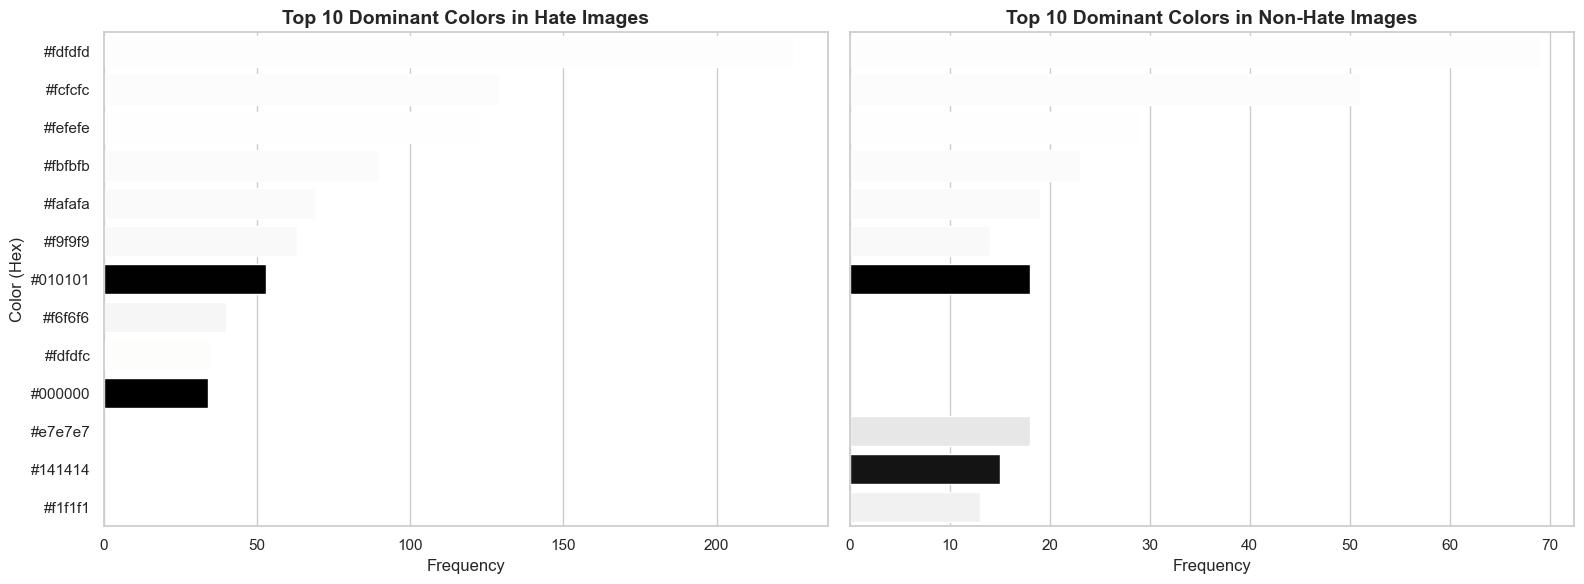

In [86]:
def color_distribution_subplot(hate_colors, non_hate_colors):
    def get_top_colors(colors):
        unique_colors, counts = np.unique(colors.astype(int), axis=0, return_counts=True)
        sorted_indices = np.argsort(counts)[::-1]
        top_colors = unique_colors[sorted_indices][:10]
        top_counts = counts[sorted_indices][:10]
        top_colors_hex = [f'#{int(c[0]):02x}{int(c[1]):02x}{int(c[2]):02x}' for c in top_colors]
        return top_colors_hex, top_counts

    hate_colors_hex, hate_counts = get_top_colors(hate_colors)
    non_hate_colors_hex, non_hate_counts = get_top_colors(non_hate_colors)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.barplot(x=hate_counts, y=hate_colors_hex, palette=hate_colors_hex, ax=axes[0])
    axes[0].set_title("Top 10 Dominant Colors in Hate Images", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Frequency", fontsize=12)
    axes[0].set_ylabel("Color (Hex)", fontsize=12)

    sns.barplot(x=non_hate_counts, y=non_hate_colors_hex, palette=non_hate_colors_hex, ax=axes[1])
    axes[1].set_title("Top 10 Dominant Colors in Non-Hate Images", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Frequency", fontsize=12)
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()

color_distribution_subplot(hate_colors, non_hate_colors)